In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "0"

In [3]:
# Parameters
ood = 3


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 255088 images
Dataset type val label type: species


Loaded 32626 images
Dataset type test label type: species


Loaded 32632 images
Dataset type train label type: species


Loaded 120355 images
Dataset type val label type: species


Loaded 15936 images
Dataset type test label type: species


Loaded 16158 images


In [6]:
# model ids
model_ids = {"0": '3qdutcy1', "1": 'czgx4bod', "2": '72y7x1fk', "3": 'cqp59iho', "4": 'fwur6c78'}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

3 cqp59iho


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                | 0/3986 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/3986 [00:00<53:10,  1.25it/s]

  0%|                                                                                                        | 3/3986 [00:00<16:57,  3.92it/s]

  0%|▏                                                                                                       | 5/3986 [00:01<10:11,  6.51it/s]

  0%|▏                                                                                                       | 7/3986 [00:01<07:26,  8.92it/s]

  0%|▏                                                                                                       | 9/3986 [00:01<06:00, 11.03it/s]

  0%|▎                                                                                                      | 11/3986 [00:01<05:10, 12.78it/s]

  0%|▎                                                                                                      | 13/3986 [00:01<04:39, 14.20it/s]

  0%|▍                                                                                                      | 15/3986 [00:01<04:19, 15.28it/s]

  0%|▍                                                                                                      | 17/3986 [00:01<04:06, 16.08it/s]

  0%|▍                                                                                                      | 19/3986 [00:01<03:58, 16.65it/s]

  1%|▌                                                                                                      | 21/3986 [00:01<03:51, 17.12it/s]

  1%|▌                                                                                                      | 23/3986 [00:02<03:47, 17.43it/s]

  1%|▋                                                                                                      | 25/3986 [00:02<03:44, 17.62it/s]

  1%|▋                                                                                                      | 27/3986 [00:02<03:42, 17.78it/s]

  1%|▋                                                                                                      | 29/3986 [00:02<03:41, 17.89it/s]

  1%|▊                                                                                                      | 31/3986 [00:02<03:40, 17.97it/s]

  1%|▊                                                                                                      | 33/3986 [00:02<03:39, 18.04it/s]

  1%|▉                                                                                                      | 35/3986 [00:02<03:39, 18.04it/s]

  1%|▉                                                                                                      | 37/3986 [00:02<03:38, 18.10it/s]

  1%|█                                                                                                      | 39/3986 [00:02<03:38, 18.09it/s]

  1%|█                                                                                                      | 41/3986 [00:03<03:37, 18.11it/s]

  1%|█                                                                                                      | 43/3986 [00:03<03:37, 18.09it/s]

  1%|█▏                                                                                                     | 45/3986 [00:03<03:37, 18.12it/s]

  1%|█▏                                                                                                     | 47/3986 [00:03<03:37, 18.13it/s]

  1%|█▎                                                                                                     | 49/3986 [00:03<03:37, 18.13it/s]

  1%|█▎                                                                                                     | 51/3986 [00:03<03:36, 18.15it/s]

  1%|█▎                                                                                                     | 53/3986 [00:03<03:36, 18.15it/s]

  1%|█▍                                                                                                     | 55/3986 [00:03<03:36, 18.12it/s]

  1%|█▍                                                                                                     | 57/3986 [00:03<03:36, 18.13it/s]

  1%|█▌                                                                                                     | 59/3986 [00:04<03:36, 18.14it/s]

  2%|█▌                                                                                                     | 61/3986 [00:04<03:36, 18.17it/s]

  2%|█▋                                                                                                     | 63/3986 [00:04<03:36, 18.16it/s]

  2%|█▋                                                                                                     | 65/3986 [00:04<03:35, 18.16it/s]

  2%|█▋                                                                                                     | 67/3986 [00:04<03:36, 18.13it/s]

  2%|█▊                                                                                                     | 69/3986 [00:04<03:35, 18.16it/s]

  2%|█▊                                                                                                     | 71/3986 [00:04<03:35, 18.15it/s]

  2%|█▉                                                                                                     | 73/3986 [00:04<03:35, 18.13it/s]

  2%|█▉                                                                                                     | 75/3986 [00:04<03:35, 18.16it/s]

  2%|█▉                                                                                                     | 77/3986 [00:05<03:35, 18.13it/s]

  2%|██                                                                                                     | 79/3986 [00:05<03:35, 18.14it/s]

  2%|██                                                                                                     | 81/3986 [00:05<03:35, 18.13it/s]

  2%|██▏                                                                                                    | 83/3986 [00:05<03:35, 18.15it/s]

  2%|██▏                                                                                                    | 85/3986 [00:05<03:34, 18.19it/s]

  2%|██▏                                                                                                    | 87/3986 [00:05<03:34, 18.18it/s]

  2%|██▎                                                                                                    | 89/3986 [00:05<03:34, 18.18it/s]

  2%|██▎                                                                                                    | 91/3986 [00:05<03:34, 18.15it/s]

  2%|██▍                                                                                                    | 93/3986 [00:05<03:34, 18.17it/s]

  2%|██▍                                                                                                    | 95/3986 [00:06<03:34, 18.17it/s]

  2%|██▌                                                                                                    | 97/3986 [00:06<03:33, 18.17it/s]

  2%|██▌                                                                                                    | 99/3986 [00:06<03:34, 18.15it/s]

  3%|██▌                                                                                                   | 101/3986 [00:06<03:33, 18.17it/s]

  3%|██▋                                                                                                   | 103/3986 [00:06<03:33, 18.16it/s]

  3%|██▋                                                                                                   | 105/3986 [00:06<03:33, 18.17it/s]

  3%|██▋                                                                                                   | 107/3986 [00:06<03:33, 18.15it/s]

  3%|██▊                                                                                                   | 109/3986 [00:06<03:33, 18.18it/s]

  3%|██▊                                                                                                   | 111/3986 [00:06<03:33, 18.16it/s]

  3%|██▉                                                                                                   | 113/3986 [00:06<03:33, 18.17it/s]

  3%|██▉                                                                                                   | 115/3986 [00:07<03:33, 18.14it/s]

  3%|██▉                                                                                                   | 117/3986 [00:07<03:33, 18.14it/s]

  3%|███                                                                                                   | 119/3986 [00:07<03:33, 18.12it/s]

  3%|███                                                                                                   | 121/3986 [00:07<03:33, 18.13it/s]

  3%|███▏                                                                                                  | 123/3986 [00:07<03:33, 18.13it/s]

  3%|███▏                                                                                                  | 125/3986 [00:07<03:32, 18.13it/s]

  3%|███▏                                                                                                  | 127/3986 [00:07<03:32, 18.14it/s]

  3%|███▎                                                                                                  | 129/3986 [00:07<03:32, 18.14it/s]

  3%|███▎                                                                                                  | 131/3986 [00:07<03:31, 18.20it/s]

  3%|███▍                                                                                                  | 133/3986 [00:08<03:31, 18.19it/s]

  3%|███▍                                                                                                  | 135/3986 [00:08<03:32, 18.16it/s]

  3%|███▌                                                                                                  | 137/3986 [00:08<03:31, 18.16it/s]

  3%|███▌                                                                                                  | 139/3986 [00:08<03:32, 18.13it/s]

  4%|███▌                                                                                                  | 141/3986 [00:08<03:32, 18.12it/s]

  4%|███▋                                                                                                  | 143/3986 [00:08<03:32, 18.12it/s]

  4%|███▋                                                                                                  | 145/3986 [00:08<03:31, 18.12it/s]

  4%|███▊                                                                                                  | 147/3986 [00:08<03:32, 18.10it/s]

  4%|███▊                                                                                                  | 149/3986 [00:08<03:31, 18.11it/s]

  4%|███▊                                                                                                  | 151/3986 [00:09<03:31, 18.10it/s]

  4%|███▉                                                                                                  | 153/3986 [00:09<03:31, 18.11it/s]

  4%|███▉                                                                                                  | 155/3986 [00:09<03:31, 18.09it/s]

  4%|████                                                                                                  | 157/3986 [00:09<03:31, 18.13it/s]

  4%|████                                                                                                  | 159/3986 [00:09<03:31, 18.13it/s]

  4%|████                                                                                                  | 161/3986 [00:09<03:31, 18.13it/s]

  4%|████▏                                                                                                 | 163/3986 [00:09<03:31, 18.10it/s]

  4%|████▏                                                                                                 | 165/3986 [00:09<03:30, 18.12it/s]

  4%|████▎                                                                                                 | 167/3986 [00:09<03:31, 18.10it/s]

  4%|████▎                                                                                                 | 169/3986 [00:10<03:30, 18.13it/s]

  4%|████▍                                                                                                 | 171/3986 [00:10<03:30, 18.11it/s]

  4%|████▍                                                                                                 | 173/3986 [00:10<03:30, 18.11it/s]

  4%|████▍                                                                                                 | 175/3986 [00:10<03:30, 18.09it/s]

  4%|████▌                                                                                                 | 177/3986 [00:10<03:30, 18.10it/s]

  4%|████▌                                                                                                 | 179/3986 [00:10<03:30, 18.10it/s]

  5%|████▋                                                                                                 | 181/3986 [00:10<03:30, 18.11it/s]

  5%|████▋                                                                                                 | 183/3986 [00:10<03:29, 18.11it/s]

  5%|████▋                                                                                                 | 185/3986 [00:10<03:29, 18.13it/s]

  5%|████▊                                                                                                 | 187/3986 [00:11<03:29, 18.14it/s]

  5%|████▊                                                                                                 | 189/3986 [00:11<03:29, 18.11it/s]

  5%|████▉                                                                                                 | 191/3986 [00:11<03:29, 18.10it/s]

  5%|████▉                                                                                                 | 193/3986 [00:11<03:29, 18.10it/s]

  5%|████▉                                                                                                 | 195/3986 [00:11<03:29, 18.11it/s]

  5%|█████                                                                                                 | 197/3986 [00:11<03:28, 18.15it/s]

  5%|█████                                                                                                 | 199/3986 [00:11<03:28, 18.14it/s]

  5%|█████▏                                                                                                | 201/3986 [00:11<03:28, 18.15it/s]

  5%|█████▏                                                                                                | 203/3986 [00:11<03:29, 18.10it/s]

  5%|█████▏                                                                                                | 205/3986 [00:12<03:28, 18.13it/s]

  5%|█████▎                                                                                                | 207/3986 [00:12<03:28, 18.10it/s]

  5%|█████▎                                                                                                | 209/3986 [00:12<03:28, 18.12it/s]

  5%|█████▍                                                                                                | 211/3986 [00:12<03:28, 18.11it/s]

  5%|█████▍                                                                                                | 213/3986 [00:12<03:28, 18.13it/s]

  5%|█████▌                                                                                                | 215/3986 [00:12<03:28, 18.12it/s]

  5%|█████▌                                                                                                | 217/3986 [00:12<03:27, 18.13it/s]

  5%|█████▌                                                                                                | 219/3986 [00:12<03:27, 18.11it/s]

  6%|█████▋                                                                                                | 221/3986 [00:12<03:28, 18.09it/s]

  6%|█████▋                                                                                                | 223/3986 [00:13<03:27, 18.11it/s]

  6%|█████▊                                                                                                | 225/3986 [00:13<03:27, 18.09it/s]

  6%|█████▊                                                                                                | 227/3986 [00:13<03:27, 18.13it/s]

  6%|█████▊                                                                                                | 229/3986 [00:13<03:26, 18.17it/s]

  6%|█████▉                                                                                                | 231/3986 [00:13<03:26, 18.17it/s]

  6%|█████▉                                                                                                | 233/3986 [00:13<03:26, 18.15it/s]

  6%|██████                                                                                                | 235/3986 [00:13<03:26, 18.14it/s]

  6%|██████                                                                                                | 237/3986 [00:13<03:27, 18.11it/s]

  6%|██████                                                                                                | 239/3986 [00:13<03:26, 18.10it/s]

  6%|██████▏                                                                                               | 241/3986 [00:14<03:26, 18.11it/s]

  6%|██████▏                                                                                               | 243/3986 [00:14<03:26, 18.10it/s]

  6%|██████▎                                                                                               | 245/3986 [00:14<03:27, 18.07it/s]

  6%|██████▎                                                                                               | 247/3986 [00:14<03:26, 18.07it/s]

  6%|██████▎                                                                                               | 249/3986 [00:14<03:26, 18.08it/s]

  6%|██████▍                                                                                               | 251/3986 [00:14<03:26, 18.11it/s]

  6%|██████▍                                                                                               | 253/3986 [00:14<03:26, 18.11it/s]

  6%|██████▌                                                                                               | 255/3986 [00:14<03:25, 18.12it/s]

  6%|██████▌                                                                                               | 257/3986 [00:14<03:25, 18.11it/s]

  6%|██████▋                                                                                               | 259/3986 [00:15<03:25, 18.14it/s]

  7%|██████▋                                                                                               | 261/3986 [00:15<03:25, 18.11it/s]

  7%|██████▋                                                                                               | 263/3986 [00:15<03:24, 18.17it/s]

  7%|██████▊                                                                                               | 265/3986 [00:15<03:24, 18.17it/s]

  7%|██████▊                                                                                               | 267/3986 [00:15<03:24, 18.16it/s]

  7%|██████▉                                                                                               | 269/3986 [00:15<03:25, 18.12it/s]

  7%|██████▉                                                                                               | 271/3986 [00:15<03:25, 18.11it/s]

  7%|██████▉                                                                                               | 273/3986 [00:15<03:24, 18.12it/s]

  7%|███████                                                                                               | 275/3986 [00:15<03:24, 18.13it/s]

  7%|███████                                                                                               | 277/3986 [00:16<03:24, 18.14it/s]

  7%|███████▏                                                                                              | 279/3986 [00:16<03:24, 18.12it/s]

  7%|███████▏                                                                                              | 281/3986 [00:16<03:24, 18.12it/s]

  7%|███████▏                                                                                              | 283/3986 [00:16<03:24, 18.14it/s]

  7%|███████▎                                                                                              | 285/3986 [00:16<03:23, 18.14it/s]

  7%|███████▎                                                                                              | 287/3986 [00:16<03:24, 18.12it/s]

  7%|███████▍                                                                                              | 289/3986 [00:16<03:23, 18.16it/s]

  7%|███████▍                                                                                              | 291/3986 [00:16<03:23, 18.17it/s]

  7%|███████▍                                                                                              | 293/3986 [00:16<03:22, 18.20it/s]

  7%|███████▌                                                                                              | 295/3986 [00:17<03:22, 18.22it/s]

  7%|███████▌                                                                                              | 297/3986 [00:17<03:23, 18.16it/s]

  8%|███████▋                                                                                              | 299/3986 [00:17<03:23, 18.15it/s]

  8%|███████▋                                                                                              | 301/3986 [00:17<03:23, 18.14it/s]

  8%|███████▊                                                                                              | 303/3986 [00:17<03:23, 18.11it/s]

  8%|███████▊                                                                                              | 305/3986 [00:17<03:23, 18.12it/s]

  8%|███████▊                                                                                              | 307/3986 [00:17<03:23, 18.12it/s]

  8%|███████▉                                                                                              | 309/3986 [00:17<03:22, 18.12it/s]

  8%|███████▉                                                                                              | 311/3986 [00:17<03:23, 18.10it/s]

  8%|████████                                                                                              | 313/3986 [00:18<03:22, 18.11it/s]

  8%|████████                                                                                              | 315/3986 [00:18<03:22, 18.09it/s]

  8%|████████                                                                                              | 317/3986 [00:18<03:23, 18.05it/s]

  8%|████████▏                                                                                             | 319/3986 [00:18<03:23, 18.05it/s]

  8%|████████▏                                                                                             | 321/3986 [00:18<03:22, 18.11it/s]

  8%|████████▎                                                                                             | 323/3986 [00:18<03:22, 18.12it/s]

  8%|████████▎                                                                                             | 325/3986 [00:18<03:21, 18.18it/s]

  8%|████████▎                                                                                             | 327/3986 [00:18<03:21, 18.17it/s]

  8%|████████▍                                                                                             | 329/3986 [00:18<03:21, 18.11it/s]

  8%|████████▍                                                                                             | 331/3986 [00:19<03:21, 18.11it/s]

  8%|████████▌                                                                                             | 333/3986 [00:19<03:21, 18.12it/s]

  8%|████████▌                                                                                             | 335/3986 [00:19<03:21, 18.13it/s]

  8%|████████▌                                                                                             | 337/3986 [00:19<03:21, 18.12it/s]

  9%|████████▋                                                                                             | 339/3986 [00:19<03:21, 18.13it/s]

  9%|████████▋                                                                                             | 341/3986 [00:19<03:20, 18.16it/s]

  9%|████████▊                                                                                             | 343/3986 [00:19<03:20, 18.17it/s]

  9%|████████▊                                                                                             | 345/3986 [00:19<03:20, 18.16it/s]

  9%|████████▉                                                                                             | 347/3986 [00:19<03:20, 18.17it/s]

  9%|████████▉                                                                                             | 349/3986 [00:20<03:19, 18.22it/s]

  9%|████████▉                                                                                             | 351/3986 [00:20<03:19, 18.24it/s]

  9%|█████████                                                                                             | 353/3986 [00:20<03:19, 18.23it/s]

  9%|█████████                                                                                             | 355/3986 [00:20<03:19, 18.19it/s]

  9%|█████████▏                                                                                            | 357/3986 [00:20<03:19, 18.15it/s]

  9%|█████████▏                                                                                            | 359/3986 [00:20<03:19, 18.17it/s]

  9%|█████████▏                                                                                            | 361/3986 [00:20<03:19, 18.17it/s]

  9%|█████████▎                                                                                            | 363/3986 [00:20<03:19, 18.19it/s]

  9%|█████████▎                                                                                            | 365/3986 [00:20<03:19, 18.15it/s]

  9%|█████████▍                                                                                            | 367/3986 [00:21<03:18, 18.22it/s]

  9%|█████████▍                                                                                            | 369/3986 [00:21<03:18, 18.21it/s]

  9%|█████████▍                                                                                            | 371/3986 [00:21<03:19, 18.16it/s]

  9%|█████████▌                                                                                            | 373/3986 [00:21<03:18, 18.16it/s]

  9%|█████████▌                                                                                            | 375/3986 [00:21<03:18, 18.16it/s]

  9%|█████████▋                                                                                            | 377/3986 [00:21<03:18, 18.14it/s]

 10%|█████████▋                                                                                            | 379/3986 [00:21<03:18, 18.14it/s]

 10%|█████████▋                                                                                            | 381/3986 [00:21<03:18, 18.12it/s]

 10%|█████████▊                                                                                            | 383/3986 [00:21<03:18, 18.13it/s]

 10%|█████████▊                                                                                            | 385/3986 [00:21<03:18, 18.14it/s]

 10%|█████████▉                                                                                            | 387/3986 [00:22<03:18, 18.13it/s]

 10%|█████████▉                                                                                            | 389/3986 [00:22<03:18, 18.14it/s]

 10%|██████████                                                                                            | 391/3986 [00:22<03:18, 18.13it/s]

 10%|██████████                                                                                            | 393/3986 [00:22<03:17, 18.18it/s]

 10%|██████████                                                                                            | 395/3986 [00:22<03:17, 18.21it/s]

 10%|██████████▏                                                                                           | 397/3986 [00:22<03:17, 18.19it/s]

 10%|██████████▏                                                                                           | 399/3986 [00:22<03:17, 18.19it/s]

 10%|██████████▎                                                                                           | 401/3986 [00:22<03:17, 18.17it/s]

 10%|██████████▎                                                                                           | 403/3986 [00:22<03:17, 18.16it/s]

 10%|██████████▎                                                                                           | 405/3986 [00:23<03:17, 18.17it/s]

 10%|██████████▍                                                                                           | 407/3986 [00:23<03:16, 18.19it/s]

 10%|██████████▍                                                                                           | 409/3986 [00:23<03:16, 18.19it/s]

 10%|██████████▌                                                                                           | 411/3986 [00:23<03:16, 18.22it/s]

 10%|██████████▌                                                                                           | 413/3986 [00:23<03:16, 18.21it/s]

 10%|██████████▌                                                                                           | 415/3986 [00:23<03:16, 18.21it/s]

 10%|██████████▋                                                                                           | 417/3986 [00:23<03:16, 18.18it/s]

 11%|██████████▋                                                                                           | 419/3986 [00:23<03:16, 18.14it/s]

 11%|██████████▊                                                                                           | 421/3986 [00:23<03:16, 18.10it/s]

 11%|██████████▊                                                                                           | 423/3986 [00:24<03:16, 18.10it/s]

 11%|██████████▉                                                                                           | 425/3986 [00:24<03:16, 18.11it/s]

 11%|██████████▉                                                                                           | 427/3986 [00:24<03:16, 18.12it/s]

 11%|██████████▉                                                                                           | 429/3986 [00:24<03:16, 18.12it/s]

 11%|███████████                                                                                           | 431/3986 [00:24<03:16, 18.12it/s]

 11%|███████████                                                                                           | 433/3986 [00:24<03:16, 18.11it/s]

 11%|███████████▏                                                                                          | 435/3986 [00:24<03:15, 18.15it/s]

 11%|███████████▏                                                                                          | 437/3986 [00:24<03:15, 18.18it/s]

 11%|███████████▏                                                                                          | 439/3986 [00:24<03:14, 18.21it/s]

 11%|███████████▎                                                                                          | 441/3986 [00:25<03:14, 18.22it/s]

 11%|███████████▎                                                                                          | 443/3986 [00:25<03:14, 18.19it/s]

 11%|███████████▍                                                                                          | 445/3986 [00:25<03:14, 18.17it/s]

 11%|███████████▍                                                                                          | 447/3986 [00:25<03:14, 18.15it/s]

 11%|███████████▍                                                                                          | 449/3986 [00:25<03:14, 18.15it/s]

 11%|███████████▌                                                                                          | 451/3986 [00:25<03:14, 18.17it/s]

 11%|███████████▌                                                                                          | 453/3986 [00:25<03:14, 18.14it/s]

 11%|███████████▋                                                                                          | 455/3986 [00:25<03:14, 18.15it/s]

 11%|███████████▋                                                                                          | 457/3986 [00:25<03:14, 18.18it/s]

 12%|███████████▋                                                                                          | 459/3986 [00:26<03:13, 18.21it/s]

 12%|███████████▊                                                                                          | 461/3986 [00:26<03:13, 18.22it/s]

 12%|███████████▊                                                                                          | 463/3986 [00:26<03:13, 18.18it/s]

 12%|███████████▉                                                                                          | 465/3986 [00:26<03:13, 18.16it/s]

 12%|███████████▉                                                                                          | 467/3986 [00:26<03:14, 18.14it/s]

 12%|████████████                                                                                          | 469/3986 [00:26<03:14, 18.12it/s]

 12%|████████████                                                                                          | 471/3986 [00:26<03:13, 18.13it/s]

 12%|████████████                                                                                          | 473/3986 [00:26<03:13, 18.13it/s]

 12%|████████████▏                                                                                         | 475/3986 [00:26<03:13, 18.13it/s]

 12%|████████████▏                                                                                         | 477/3986 [00:27<03:13, 18.14it/s]

 12%|████████████▎                                                                                         | 479/3986 [00:27<03:13, 18.13it/s]

 12%|████████████▎                                                                                         | 481/3986 [00:27<03:13, 18.12it/s]

 12%|████████████▎                                                                                         | 483/3986 [00:27<03:12, 18.18it/s]

 12%|████████████▍                                                                                         | 485/3986 [00:27<03:12, 18.18it/s]

 12%|████████████▍                                                                                         | 487/3986 [00:27<03:12, 18.18it/s]

 12%|████████████▌                                                                                         | 489/3986 [00:27<03:12, 18.16it/s]

 12%|████████████▌                                                                                         | 491/3986 [00:27<03:12, 18.20it/s]

 12%|████████████▌                                                                                         | 493/3986 [00:27<03:11, 18.21it/s]

 12%|████████████▋                                                                                         | 495/3986 [00:28<03:11, 18.20it/s]

 12%|████████████▋                                                                                         | 497/3986 [00:28<03:12, 18.14it/s]

 13%|████████████▊                                                                                         | 499/3986 [00:28<03:12, 18.12it/s]

 13%|████████████▊                                                                                         | 501/3986 [00:28<03:11, 18.18it/s]

 13%|████████████▊                                                                                         | 503/3986 [00:28<03:11, 18.18it/s]

 13%|████████████▉                                                                                         | 505/3986 [00:28<03:11, 18.16it/s]

 13%|████████████▉                                                                                         | 507/3986 [00:28<03:11, 18.16it/s]

 13%|█████████████                                                                                         | 509/3986 [00:28<03:11, 18.14it/s]

 13%|█████████████                                                                                         | 511/3986 [00:28<03:11, 18.12it/s]

 13%|█████████████▏                                                                                        | 513/3986 [00:29<03:11, 18.11it/s]

 13%|█████████████▏                                                                                        | 515/3986 [00:29<03:11, 18.15it/s]

 13%|█████████████▏                                                                                        | 517/3986 [00:29<03:11, 18.14it/s]

 13%|█████████████▎                                                                                        | 519/3986 [00:29<03:10, 18.16it/s]

 13%|█████████████▎                                                                                        | 521/3986 [00:29<03:10, 18.15it/s]

 13%|█████████████▍                                                                                        | 523/3986 [00:29<03:10, 18.16it/s]

 13%|█████████████▍                                                                                        | 525/3986 [00:29<03:10, 18.15it/s]

 13%|█████████████▍                                                                                        | 527/3986 [00:29<03:10, 18.15it/s]

 13%|█████████████▌                                                                                        | 529/3986 [00:29<03:10, 18.16it/s]

 13%|█████████████▌                                                                                        | 531/3986 [00:30<03:10, 18.14it/s]

 13%|█████████████▋                                                                                        | 533/3986 [00:30<03:10, 18.12it/s]

 13%|█████████████▋                                                                                        | 535/3986 [00:30<03:10, 18.12it/s]

 13%|█████████████▋                                                                                        | 537/3986 [00:30<03:10, 18.09it/s]

 14%|█████████████▊                                                                                        | 539/3986 [00:30<03:10, 18.09it/s]

 14%|█████████████▊                                                                                        | 541/3986 [00:30<03:10, 18.09it/s]

 14%|█████████████▉                                                                                        | 543/3986 [00:30<03:10, 18.09it/s]

 14%|█████████████▉                                                                                        | 545/3986 [00:30<03:10, 18.10it/s]

 14%|█████████████▉                                                                                        | 547/3986 [00:30<03:09, 18.11it/s]

 14%|██████████████                                                                                        | 549/3986 [00:31<03:09, 18.12it/s]

 14%|██████████████                                                                                        | 551/3986 [00:31<03:09, 18.14it/s]

 14%|██████████████▏                                                                                       | 553/3986 [00:31<03:09, 18.11it/s]

 14%|██████████████▏                                                                                       | 555/3986 [00:31<03:08, 18.16it/s]

 14%|██████████████▎                                                                                       | 557/3986 [00:31<03:08, 18.16it/s]

 14%|██████████████▎                                                                                       | 559/3986 [00:31<03:08, 18.15it/s]

 14%|██████████████▎                                                                                       | 561/3986 [00:31<03:08, 18.19it/s]

 14%|██████████████▍                                                                                       | 563/3986 [00:31<03:08, 18.17it/s]

 14%|██████████████▍                                                                                       | 565/3986 [00:31<03:08, 18.15it/s]

 14%|██████████████▌                                                                                       | 567/3986 [00:32<03:08, 18.14it/s]

 14%|██████████████▌                                                                                       | 569/3986 [00:32<03:08, 18.13it/s]

 14%|██████████████▌                                                                                       | 571/3986 [00:32<03:08, 18.15it/s]

 14%|██████████████▋                                                                                       | 573/3986 [00:32<03:07, 18.16it/s]

 14%|██████████████▋                                                                                       | 575/3986 [00:32<03:08, 18.14it/s]

 14%|██████████████▊                                                                                       | 577/3986 [00:32<03:07, 18.18it/s]

 15%|██████████████▊                                                                                       | 579/3986 [00:32<03:07, 18.19it/s]

 15%|██████████████▊                                                                                       | 581/3986 [00:32<03:07, 18.13it/s]

 15%|██████████████▉                                                                                       | 583/3986 [00:32<03:07, 18.13it/s]

 15%|██████████████▉                                                                                       | 585/3986 [00:33<03:07, 18.10it/s]

 15%|███████████████                                                                                       | 587/3986 [00:33<03:07, 18.10it/s]

 15%|███████████████                                                                                       | 589/3986 [00:33<03:07, 18.11it/s]

 15%|███████████████                                                                                       | 591/3986 [00:33<03:07, 18.10it/s]

 15%|███████████████▏                                                                                      | 593/3986 [00:33<03:07, 18.11it/s]

 15%|███████████████▏                                                                                      | 595/3986 [00:33<03:07, 18.12it/s]

 15%|███████████████▎                                                                                      | 597/3986 [00:33<03:06, 18.13it/s]

 15%|███████████████▎                                                                                      | 599/3986 [00:33<03:06, 18.14it/s]

 15%|███████████████▍                                                                                      | 601/3986 [00:33<03:06, 18.13it/s]

 15%|███████████████▍                                                                                      | 603/3986 [00:34<03:06, 18.13it/s]

 15%|███████████████▍                                                                                      | 605/3986 [00:34<03:06, 18.16it/s]

 15%|███████████████▌                                                                                      | 607/3986 [00:34<03:06, 18.15it/s]

 15%|███████████████▌                                                                                      | 609/3986 [00:34<03:06, 18.15it/s]

 15%|███████████████▋                                                                                      | 611/3986 [00:34<03:06, 18.13it/s]

 15%|███████████████▋                                                                                      | 613/3986 [00:34<03:06, 18.12it/s]

 15%|███████████████▋                                                                                      | 615/3986 [00:34<03:05, 18.15it/s]

 15%|███████████████▊                                                                                      | 617/3986 [00:34<03:05, 18.13it/s]

 16%|███████████████▊                                                                                      | 619/3986 [00:34<03:05, 18.13it/s]

 16%|███████████████▉                                                                                      | 621/3986 [00:34<03:05, 18.16it/s]

 16%|███████████████▉                                                                                      | 623/3986 [00:35<03:05, 18.14it/s]

 16%|███████████████▉                                                                                      | 625/3986 [00:35<03:05, 18.15it/s]

 16%|████████████████                                                                                      | 627/3986 [00:35<03:04, 18.18it/s]

 16%|████████████████                                                                                      | 629/3986 [00:35<03:04, 18.21it/s]

 16%|████████████████▏                                                                                     | 631/3986 [00:35<03:04, 18.22it/s]

 16%|████████████████▏                                                                                     | 633/3986 [00:35<03:04, 18.18it/s]

 16%|████████████████▏                                                                                     | 635/3986 [00:35<03:04, 18.17it/s]

 16%|████████████████▎                                                                                     | 637/3986 [00:35<03:04, 18.14it/s]

 16%|████████████████▎                                                                                     | 639/3986 [00:35<03:04, 18.15it/s]

 16%|████████████████▍                                                                                     | 641/3986 [00:36<03:04, 18.15it/s]

 16%|████████████████▍                                                                                     | 643/3986 [00:36<03:04, 18.15it/s]

 16%|████████████████▌                                                                                     | 645/3986 [00:36<03:04, 18.15it/s]

 16%|████████████████▌                                                                                     | 647/3986 [00:36<03:04, 18.13it/s]

 16%|████████████████▌                                                                                     | 649/3986 [00:36<03:04, 18.13it/s]

 16%|████████████████▋                                                                                     | 651/3986 [00:36<03:03, 18.15it/s]

 16%|████████████████▋                                                                                     | 653/3986 [00:36<03:03, 18.19it/s]

 16%|████████████████▊                                                                                     | 655/3986 [00:36<03:03, 18.17it/s]

 16%|████████████████▊                                                                                     | 657/3986 [00:36<03:03, 18.16it/s]

 17%|████████████████▊                                                                                     | 659/3986 [00:37<03:03, 18.14it/s]

 17%|████████████████▉                                                                                     | 661/3986 [00:37<03:03, 18.13it/s]

 17%|████████████████▉                                                                                     | 663/3986 [00:37<03:03, 18.15it/s]

 17%|█████████████████                                                                                     | 665/3986 [00:37<03:03, 18.11it/s]

 17%|█████████████████                                                                                     | 667/3986 [00:37<03:03, 18.09it/s]

 17%|█████████████████                                                                                     | 669/3986 [00:37<03:03, 18.08it/s]

 17%|█████████████████▏                                                                                    | 671/3986 [00:37<03:03, 18.09it/s]

 17%|█████████████████▏                                                                                    | 673/3986 [00:37<03:03, 18.10it/s]

 17%|█████████████████▎                                                                                    | 675/3986 [00:37<03:02, 18.14it/s]

 17%|█████████████████▎                                                                                    | 677/3986 [00:38<03:02, 18.13it/s]

 17%|█████████████████▍                                                                                    | 679/3986 [00:38<03:02, 18.13it/s]

 17%|█████████████████▍                                                                                    | 681/3986 [00:38<03:02, 18.12it/s]

 17%|█████████████████▍                                                                                    | 683/3986 [00:38<03:02, 18.13it/s]

 17%|█████████████████▌                                                                                    | 685/3986 [00:38<03:02, 18.12it/s]

 17%|█████████████████▌                                                                                    | 687/3986 [00:38<03:02, 18.12it/s]

 17%|█████████████████▋                                                                                    | 689/3986 [00:38<03:02, 18.10it/s]

 17%|█████████████████▋                                                                                    | 691/3986 [00:38<03:02, 18.10it/s]

 17%|█████████████████▋                                                                                    | 693/3986 [00:38<03:02, 18.09it/s]

 17%|█████████████████▊                                                                                    | 695/3986 [00:39<03:01, 18.10it/s]

 17%|█████████████████▊                                                                                    | 697/3986 [00:39<03:01, 18.11it/s]

 18%|█████████████████▉                                                                                    | 699/3986 [00:39<03:01, 18.09it/s]

 18%|█████████████████▉                                                                                    | 701/3986 [00:39<03:01, 18.09it/s]

 18%|█████████████████▉                                                                                    | 703/3986 [00:39<03:01, 18.09it/s]

 18%|██████████████████                                                                                    | 705/3986 [00:39<03:01, 18.09it/s]

 18%|██████████████████                                                                                    | 707/3986 [00:39<03:01, 18.08it/s]

 18%|██████████████████▏                                                                                   | 709/3986 [00:39<03:00, 18.12it/s]

 18%|██████████████████▏                                                                                   | 711/3986 [00:39<03:00, 18.15it/s]

 18%|██████████████████▏                                                                                   | 713/3986 [00:40<03:00, 18.13it/s]

 18%|██████████████████▎                                                                                   | 715/3986 [00:40<03:00, 18.11it/s]

 18%|██████████████████▎                                                                                   | 717/3986 [00:40<03:00, 18.12it/s]

 18%|██████████████████▍                                                                                   | 719/3986 [00:40<03:00, 18.14it/s]

 18%|██████████████████▍                                                                                   | 721/3986 [00:40<02:59, 18.17it/s]

 18%|██████████████████▌                                                                                   | 723/3986 [00:40<02:59, 18.16it/s]

 18%|██████████████████▌                                                                                   | 725/3986 [00:40<03:00, 18.11it/s]

 18%|██████████████████▌                                                                                   | 727/3986 [00:40<03:00, 18.09it/s]

 18%|██████████████████▋                                                                                   | 729/3986 [00:40<02:59, 18.10it/s]

 18%|██████████████████▋                                                                                   | 731/3986 [00:41<02:59, 18.12it/s]

 18%|██████████████████▊                                                                                   | 733/3986 [00:41<02:59, 18.13it/s]

 18%|██████████████████▊                                                                                   | 735/3986 [00:41<02:59, 18.13it/s]

 18%|██████████████████▊                                                                                   | 737/3986 [00:41<02:59, 18.14it/s]

 19%|██████████████████▉                                                                                   | 739/3986 [00:41<02:58, 18.16it/s]

 19%|██████████████████▉                                                                                   | 741/3986 [00:41<02:58, 18.18it/s]

 19%|███████████████████                                                                                   | 743/3986 [00:41<02:58, 18.19it/s]

 19%|███████████████████                                                                                   | 745/3986 [00:41<02:58, 18.18it/s]

 19%|███████████████████                                                                                   | 747/3986 [00:41<02:58, 18.15it/s]

 19%|███████████████████▏                                                                                  | 749/3986 [00:42<02:58, 18.12it/s]

 19%|███████████████████▏                                                                                  | 751/3986 [00:42<02:58, 18.12it/s]

 19%|███████████████████▎                                                                                  | 753/3986 [00:42<02:58, 18.11it/s]

 19%|███████████████████▎                                                                                  | 755/3986 [00:42<02:58, 18.10it/s]

 19%|███████████████████▎                                                                                  | 757/3986 [00:42<02:58, 18.10it/s]

 19%|███████████████████▍                                                                                  | 759/3986 [00:42<02:58, 18.11it/s]

 19%|███████████████████▍                                                                                  | 761/3986 [00:42<02:57, 18.12it/s]

 19%|███████████████████▌                                                                                  | 763/3986 [00:42<02:57, 18.12it/s]

 19%|███████████████████▌                                                                                  | 765/3986 [00:42<02:57, 18.13it/s]

 19%|███████████████████▋                                                                                  | 767/3986 [00:43<02:57, 18.13it/s]

 19%|███████████████████▋                                                                                  | 769/3986 [00:43<02:57, 18.12it/s]

 19%|███████████████████▋                                                                                  | 771/3986 [00:43<02:57, 18.11it/s]

 19%|███████████████████▊                                                                                  | 773/3986 [00:43<02:57, 18.09it/s]

 19%|███████████████████▊                                                                                  | 775/3986 [00:43<02:57, 18.10it/s]

 19%|███████████████████▉                                                                                  | 777/3986 [00:43<02:57, 18.13it/s]

 20%|███████████████████▉                                                                                  | 779/3986 [00:43<02:56, 18.13it/s]

 20%|███████████████████▉                                                                                  | 781/3986 [00:43<02:56, 18.19it/s]

 20%|████████████████████                                                                                  | 783/3986 [00:43<02:56, 18.18it/s]

 20%|████████████████████                                                                                  | 785/3986 [00:44<02:56, 18.16it/s]

 20%|████████████████████▏                                                                                 | 787/3986 [00:44<02:56, 18.13it/s]

 20%|████████████████████▏                                                                                 | 789/3986 [00:44<02:56, 18.13it/s]

 20%|████████████████████▏                                                                                 | 791/3986 [00:44<02:56, 18.11it/s]

 20%|████████████████████▎                                                                                 | 793/3986 [00:44<02:56, 18.13it/s]

 20%|████████████████████▎                                                                                 | 795/3986 [00:44<02:56, 18.12it/s]

 20%|████████████████████▍                                                                                 | 797/3986 [00:44<02:55, 18.15it/s]

 20%|████████████████████▍                                                                                 | 799/3986 [00:44<02:55, 18.17it/s]

 20%|████████████████████▍                                                                                 | 801/3986 [00:44<02:55, 18.16it/s]

 20%|████████████████████▌                                                                                 | 803/3986 [00:45<02:55, 18.16it/s]

 20%|████████████████████▌                                                                                 | 805/3986 [00:45<02:55, 18.13it/s]

 20%|████████████████████▋                                                                                 | 807/3986 [00:45<02:55, 18.14it/s]

 20%|████████████████████▋                                                                                 | 809/3986 [00:45<02:55, 18.12it/s]

 20%|████████████████████▊                                                                                 | 811/3986 [00:45<02:55, 18.12it/s]

 20%|████████████████████▊                                                                                 | 813/3986 [00:45<02:55, 18.13it/s]

 20%|████████████████████▊                                                                                 | 815/3986 [00:45<02:54, 18.14it/s]

 20%|████████████████████▉                                                                                 | 817/3986 [00:45<02:54, 18.13it/s]

 21%|████████████████████▉                                                                                 | 819/3986 [00:45<02:55, 18.08it/s]

 21%|█████████████████████                                                                                 | 821/3986 [00:46<02:54, 18.12it/s]

 21%|█████████████████████                                                                                 | 823/3986 [00:46<02:54, 18.13it/s]

 21%|█████████████████████                                                                                 | 825/3986 [00:46<02:54, 18.10it/s]

 21%|█████████████████████▏                                                                                | 827/3986 [00:46<02:54, 18.11it/s]

 21%|█████████████████████▏                                                                                | 829/3986 [00:46<02:53, 18.15it/s]

 21%|█████████████████████▎                                                                                | 831/3986 [00:46<02:53, 18.16it/s]

 21%|█████████████████████▎                                                                                | 833/3986 [00:46<02:53, 18.12it/s]

 21%|█████████████████████▎                                                                                | 835/3986 [00:46<02:54, 18.10it/s]

 21%|█████████████████████▍                                                                                | 837/3986 [00:46<02:54, 18.09it/s]

 21%|█████████████████████▍                                                                                | 839/3986 [00:47<02:53, 18.09it/s]

 21%|█████████████████████▌                                                                                | 841/3986 [00:47<02:53, 18.13it/s]

 21%|█████████████████████▌                                                                                | 843/3986 [00:47<02:53, 18.14it/s]

 21%|█████████████████████▌                                                                                | 845/3986 [00:47<02:52, 18.17it/s]

 21%|█████████████████████▋                                                                                | 847/3986 [00:47<02:52, 18.19it/s]

 21%|█████████████████████▋                                                                                | 849/3986 [00:47<02:52, 18.18it/s]

 21%|█████████████████████▊                                                                                | 851/3986 [00:47<02:52, 18.18it/s]

 21%|█████████████████████▊                                                                                | 853/3986 [00:47<02:51, 18.22it/s]

 21%|█████████████████████▉                                                                                | 855/3986 [00:47<02:51, 18.21it/s]

 22%|█████████████████████▉                                                                                | 857/3986 [00:48<02:52, 18.17it/s]

 22%|█████████████████████▉                                                                                | 859/3986 [00:48<02:51, 18.18it/s]

 22%|██████████████████████                                                                                | 861/3986 [00:48<02:52, 18.14it/s]

 22%|██████████████████████                                                                                | 863/3986 [00:48<02:52, 18.13it/s]

 22%|██████████████████████▏                                                                               | 865/3986 [00:48<02:52, 18.13it/s]

 22%|██████████████████████▏                                                                               | 867/3986 [00:48<02:52, 18.13it/s]

 22%|██████████████████████▏                                                                               | 869/3986 [00:48<02:51, 18.13it/s]

 22%|██████████████████████▎                                                                               | 871/3986 [00:48<02:51, 18.13it/s]

 22%|██████████████████████▎                                                                               | 873/3986 [00:48<02:51, 18.12it/s]

 22%|██████████████████████▍                                                                               | 875/3986 [00:49<02:51, 18.10it/s]

 22%|██████████████████████▍                                                                               | 877/3986 [00:49<02:51, 18.11it/s]

 22%|██████████████████████▍                                                                               | 879/3986 [00:49<02:51, 18.16it/s]

 22%|██████████████████████▌                                                                               | 881/3986 [00:49<02:51, 18.14it/s]

 22%|██████████████████████▌                                                                               | 883/3986 [00:49<02:51, 18.14it/s]

 22%|██████████████████████▋                                                                               | 885/3986 [00:49<02:51, 18.11it/s]

 22%|██████████████████████▋                                                                               | 887/3986 [00:49<02:51, 18.11it/s]

 22%|██████████████████████▋                                                                               | 889/3986 [00:49<02:51, 18.10it/s]

 22%|██████████████████████▊                                                                               | 891/3986 [00:49<02:50, 18.10it/s]

 22%|██████████████████████▊                                                                               | 893/3986 [00:50<02:50, 18.11it/s]

 22%|██████████████████████▉                                                                               | 895/3986 [00:50<02:50, 18.11it/s]

 23%|██████████████████████▉                                                                               | 897/3986 [00:50<02:50, 18.12it/s]

 23%|███████████████████████                                                                               | 899/3986 [00:50<02:50, 18.12it/s]

 23%|███████████████████████                                                                               | 901/3986 [00:50<02:50, 18.14it/s]

 23%|███████████████████████                                                                               | 903/3986 [00:50<02:49, 18.14it/s]

 23%|███████████████████████▏                                                                              | 905/3986 [00:50<02:49, 18.14it/s]

 23%|███████████████████████▏                                                                              | 907/3986 [00:50<02:49, 18.17it/s]

 23%|███████████████████████▎                                                                              | 909/3986 [00:50<02:49, 18.18it/s]

 23%|███████████████████████▎                                                                              | 911/3986 [00:50<02:48, 18.22it/s]

 23%|███████████████████████▎                                                                              | 913/3986 [00:51<02:48, 18.23it/s]

 23%|███████████████████████▍                                                                              | 915/3986 [00:51<02:48, 18.22it/s]

 23%|███████████████████████▍                                                                              | 917/3986 [00:51<02:48, 18.18it/s]

 23%|███████████████████████▌                                                                              | 919/3986 [00:51<02:48, 18.19it/s]

 23%|███████████████████████▌                                                                              | 921/3986 [00:51<02:48, 18.17it/s]

 23%|███████████████████████▌                                                                              | 923/3986 [00:51<02:48, 18.18it/s]

 23%|███████████████████████▋                                                                              | 925/3986 [00:51<02:48, 18.20it/s]

 23%|███████████████████████▋                                                                              | 927/3986 [00:51<02:47, 18.25it/s]

 23%|███████████████████████▊                                                                              | 929/3986 [00:51<02:47, 18.22it/s]

 23%|███████████████████████▊                                                                              | 931/3986 [00:52<02:47, 18.21it/s]

 23%|███████████████████████▉                                                                              | 933/3986 [00:52<02:47, 18.19it/s]

 23%|███████████████████████▉                                                                              | 935/3986 [00:52<02:47, 18.24it/s]

 24%|███████████████████████▉                                                                              | 937/3986 [00:52<02:47, 18.25it/s]

 24%|████████████████████████                                                                              | 939/3986 [00:52<02:47, 18.24it/s]

 24%|████████████████████████                                                                              | 941/3986 [00:52<02:46, 18.26it/s]

 24%|████████████████████████▏                                                                             | 943/3986 [00:52<02:46, 18.23it/s]

 24%|████████████████████████▏                                                                             | 945/3986 [00:52<02:46, 18.22it/s]

 24%|████████████████████████▏                                                                             | 947/3986 [00:52<02:46, 18.25it/s]

 24%|████████████████████████▎                                                                             | 949/3986 [00:53<02:46, 18.23it/s]

 24%|████████████████████████▎                                                                             | 951/3986 [00:53<02:46, 18.21it/s]

 24%|████████████████████████▍                                                                             | 953/3986 [00:53<02:46, 18.21it/s]

 24%|████████████████████████▍                                                                             | 955/3986 [00:53<02:46, 18.23it/s]

 24%|████████████████████████▍                                                                             | 957/3986 [00:53<02:46, 18.20it/s]

 24%|████████████████████████▌                                                                             | 959/3986 [00:53<02:46, 18.17it/s]

 24%|████████████████████████▌                                                                             | 961/3986 [00:53<02:46, 18.19it/s]

 24%|████████████████████████▋                                                                             | 963/3986 [00:53<02:46, 18.19it/s]

 24%|████████████████████████▋                                                                             | 965/3986 [00:53<02:46, 18.18it/s]

 24%|████████████████████████▋                                                                             | 967/3986 [00:54<02:45, 18.19it/s]

 24%|████████████████████████▊                                                                             | 969/3986 [00:54<02:45, 18.18it/s]

 24%|████████████████████████▊                                                                             | 971/3986 [00:54<02:45, 18.22it/s]

 24%|████████████████████████▉                                                                             | 973/3986 [00:54<02:45, 18.22it/s]

 24%|████████████████████████▉                                                                             | 975/3986 [00:54<02:45, 18.23it/s]

 25%|█████████████████████████                                                                             | 977/3986 [00:54<02:45, 18.23it/s]

 25%|█████████████████████████                                                                             | 979/3986 [00:54<02:44, 18.23it/s]

 25%|█████████████████████████                                                                             | 981/3986 [00:54<02:44, 18.21it/s]

 25%|█████████████████████████▏                                                                            | 983/3986 [00:54<02:44, 18.21it/s]

 25%|█████████████████████████▏                                                                            | 985/3986 [00:55<02:44, 18.19it/s]

 25%|█████████████████████████▎                                                                            | 987/3986 [00:55<02:44, 18.23it/s]

 25%|█████████████████████████▎                                                                            | 989/3986 [00:55<02:44, 18.21it/s]

 25%|█████████████████████████▎                                                                            | 991/3986 [00:55<02:44, 18.20it/s]

 25%|█████████████████████████▍                                                                            | 993/3986 [00:55<02:44, 18.19it/s]

 25%|█████████████████████████▍                                                                            | 995/3986 [00:55<02:44, 18.20it/s]

 25%|█████████████████████████▌                                                                            | 997/3986 [00:55<02:44, 18.20it/s]

 25%|█████████████████████████▌                                                                            | 999/3986 [00:55<02:44, 18.20it/s]

 25%|█████████████████████████▎                                                                           | 1001/3986 [00:55<02:44, 18.16it/s]

 25%|█████████████████████████▍                                                                           | 1003/3986 [00:56<02:43, 18.20it/s]

 25%|█████████████████████████▍                                                                           | 1005/3986 [00:56<02:43, 18.20it/s]

 25%|█████████████████████████▌                                                                           | 1007/3986 [00:56<02:43, 18.19it/s]

 25%|█████████████████████████▌                                                                           | 1009/3986 [00:56<02:43, 18.19it/s]

 25%|█████████████████████████▌                                                                           | 1011/3986 [00:56<02:43, 18.17it/s]

 25%|█████████████████████████▋                                                                           | 1013/3986 [00:56<02:43, 18.18it/s]

 25%|█████████████████████████▋                                                                           | 1015/3986 [00:56<02:43, 18.20it/s]

 26%|█████████████████████████▊                                                                           | 1017/3986 [00:56<02:43, 18.19it/s]

 26%|█████████████████████████▊                                                                           | 1019/3986 [00:56<02:43, 18.18it/s]

 26%|█████████████████████████▊                                                                           | 1021/3986 [00:57<02:42, 18.24it/s]

 26%|█████████████████████████▉                                                                           | 1023/3986 [00:57<02:42, 18.22it/s]

 26%|█████████████████████████▉                                                                           | 1025/3986 [00:57<02:42, 18.20it/s]

 26%|██████████████████████████                                                                           | 1027/3986 [00:57<02:42, 18.20it/s]

 26%|██████████████████████████                                                                           | 1029/3986 [00:57<02:42, 18.18it/s]

 26%|██████████████████████████                                                                           | 1031/3986 [00:57<02:42, 18.18it/s]

 26%|██████████████████████████▏                                                                          | 1033/3986 [00:57<02:42, 18.18it/s]

 26%|██████████████████████████▏                                                                          | 1035/3986 [00:57<02:42, 18.18it/s]

 26%|██████████████████████████▎                                                                          | 1037/3986 [00:57<02:42, 18.12it/s]

 26%|██████████████████████████▎                                                                          | 1039/3986 [00:58<02:42, 18.16it/s]

 26%|██████████████████████████▍                                                                          | 1041/3986 [00:58<02:41, 18.20it/s]

 26%|██████████████████████████▍                                                                          | 1043/3986 [00:58<02:41, 18.18it/s]

 26%|██████████████████████████▍                                                                          | 1045/3986 [00:58<02:41, 18.18it/s]

 26%|██████████████████████████▌                                                                          | 1047/3986 [00:58<02:41, 18.18it/s]

 26%|██████████████████████████▌                                                                          | 1049/3986 [00:58<02:41, 18.18it/s]

 26%|██████████████████████████▋                                                                          | 1051/3986 [00:58<02:41, 18.19it/s]

 26%|██████████████████████████▋                                                                          | 1053/3986 [00:58<02:41, 18.19it/s]

 26%|██████████████████████████▋                                                                          | 1055/3986 [00:58<02:40, 18.21it/s]

 27%|██████████████████████████▊                                                                          | 1057/3986 [00:59<02:41, 18.19it/s]

 27%|██████████████████████████▊                                                                          | 1059/3986 [00:59<02:40, 18.19it/s]

 27%|██████████████████████████▉                                                                          | 1061/3986 [00:59<02:40, 18.20it/s]

 27%|██████████████████████████▉                                                                          | 1063/3986 [00:59<02:40, 18.22it/s]

 27%|██████████████████████████▉                                                                          | 1065/3986 [00:59<02:40, 18.24it/s]

 27%|███████████████████████████                                                                          | 1067/3986 [00:59<02:40, 18.20it/s]

 27%|███████████████████████████                                                                          | 1069/3986 [00:59<02:40, 18.20it/s]

 27%|███████████████████████████▏                                                                         | 1071/3986 [00:59<02:40, 18.20it/s]

 27%|███████████████████████████▏                                                                         | 1073/3986 [00:59<02:40, 18.19it/s]

 27%|███████████████████████████▏                                                                         | 1075/3986 [01:00<02:40, 18.17it/s]

 27%|███████████████████████████▎                                                                         | 1077/3986 [01:00<02:39, 18.20it/s]

 27%|███████████████████████████▎                                                                         | 1079/3986 [01:00<02:40, 18.17it/s]

 27%|███████████████████████████▍                                                                         | 1081/3986 [01:00<02:39, 18.17it/s]

 27%|███████████████████████████▍                                                                         | 1083/3986 [01:00<02:39, 18.21it/s]

 27%|███████████████████████████▍                                                                         | 1085/3986 [01:00<02:39, 18.16it/s]

 27%|███████████████████████████▌                                                                         | 1087/3986 [01:00<02:39, 18.15it/s]

 27%|███████████████████████████▌                                                                         | 1089/3986 [01:00<02:39, 18.13it/s]

 27%|███████████████████████████▋                                                                         | 1091/3986 [01:00<02:39, 18.14it/s]

 27%|███████████████████████████▋                                                                         | 1093/3986 [01:00<02:39, 18.17it/s]

 27%|███████████████████████████▋                                                                         | 1095/3986 [01:01<02:38, 18.20it/s]

 28%|███████████████████████████▊                                                                         | 1097/3986 [01:01<02:38, 18.19it/s]

 28%|███████████████████████████▊                                                                         | 1099/3986 [01:01<02:38, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1101/3986 [01:01<02:38, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1103/3986 [01:01<02:38, 18.21it/s]

 28%|███████████████████████████▉                                                                         | 1105/3986 [01:01<02:38, 18.18it/s]

 28%|████████████████████████████                                                                         | 1107/3986 [01:01<02:38, 18.17it/s]

 28%|████████████████████████████                                                                         | 1109/3986 [01:01<02:38, 18.15it/s]

 28%|████████████████████████████▏                                                                        | 1111/3986 [01:01<02:38, 18.16it/s]

 28%|████████████████████████████▏                                                                        | 1113/3986 [01:02<02:38, 18.17it/s]

 28%|████████████████████████████▎                                                                        | 1115/3986 [01:02<02:37, 18.18it/s]

 28%|████████████████████████████▎                                                                        | 1117/3986 [01:02<02:37, 18.18it/s]

 28%|████████████████████████████▎                                                                        | 1119/3986 [01:02<02:37, 18.23it/s]

 28%|████████████████████████████▍                                                                        | 1121/3986 [01:02<02:37, 18.24it/s]

 28%|████████████████████████████▍                                                                        | 1123/3986 [01:02<02:37, 18.24it/s]

 28%|████████████████████████████▌                                                                        | 1125/3986 [01:02<02:37, 18.21it/s]

 28%|████████████████████████████▌                                                                        | 1127/3986 [01:02<02:37, 18.16it/s]

 28%|████████████████████████████▌                                                                        | 1129/3986 [01:02<02:37, 18.15it/s]

 28%|████████████████████████████▋                                                                        | 1131/3986 [01:03<02:37, 18.13it/s]

 28%|████████████████████████████▋                                                                        | 1133/3986 [01:03<02:37, 18.09it/s]

 28%|████████████████████████████▊                                                                        | 1135/3986 [01:03<02:37, 18.13it/s]

 29%|████████████████████████████▊                                                                        | 1137/3986 [01:03<02:36, 18.16it/s]

 29%|████████████████████████████▊                                                                        | 1139/3986 [01:03<02:36, 18.18it/s]

 29%|████████████████████████████▉                                                                        | 1141/3986 [01:03<02:36, 18.20it/s]

 29%|████████████████████████████▉                                                                        | 1143/3986 [01:03<02:36, 18.21it/s]

 29%|█████████████████████████████                                                                        | 1145/3986 [01:03<02:35, 18.23it/s]

 29%|█████████████████████████████                                                                        | 1147/3986 [01:03<02:35, 18.21it/s]

 29%|█████████████████████████████                                                                        | 1149/3986 [01:04<02:36, 18.17it/s]

 29%|█████████████████████████████▏                                                                       | 1151/3986 [01:04<02:36, 18.16it/s]

 29%|█████████████████████████████▏                                                                       | 1153/3986 [01:04<02:36, 18.16it/s]

 29%|█████████████████████████████▎                                                                       | 1155/3986 [01:04<02:35, 18.20it/s]

 29%|█████████████████████████████▎                                                                       | 1157/3986 [01:04<02:35, 18.22it/s]

 29%|█████████████████████████████▎                                                                       | 1159/3986 [01:04<02:35, 18.22it/s]

 29%|█████████████████████████████▍                                                                       | 1161/3986 [01:04<02:34, 18.28it/s]

 29%|█████████████████████████████▍                                                                       | 1163/3986 [01:04<02:34, 18.29it/s]

 29%|█████████████████████████████▌                                                                       | 1165/3986 [01:04<02:34, 18.31it/s]

 29%|█████████████████████████████▌                                                                       | 1167/3986 [01:05<02:34, 18.24it/s]

 29%|█████████████████████████████▌                                                                       | 1169/3986 [01:05<02:34, 18.21it/s]

 29%|█████████████████████████████▋                                                                       | 1171/3986 [01:05<02:34, 18.19it/s]

 29%|█████████████████████████████▋                                                                       | 1173/3986 [01:05<02:34, 18.18it/s]

 29%|█████████████████████████████▊                                                                       | 1175/3986 [01:05<02:34, 18.18it/s]

 30%|█████████████████████████████▊                                                                       | 1177/3986 [01:05<02:34, 18.19it/s]

 30%|█████████████████████████████▊                                                                       | 1179/3986 [01:05<02:34, 18.23it/s]

 30%|█████████████████████████████▉                                                                       | 1181/3986 [01:05<02:33, 18.25it/s]

 30%|█████████████████████████████▉                                                                       | 1183/3986 [01:05<02:33, 18.26it/s]

 30%|██████████████████████████████                                                                       | 1185/3986 [01:06<02:33, 18.24it/s]

 30%|██████████████████████████████                                                                       | 1187/3986 [01:06<02:33, 18.25it/s]

 30%|██████████████████████████████▏                                                                      | 1189/3986 [01:06<02:33, 18.25it/s]

 30%|██████████████████████████████▏                                                                      | 1191/3986 [01:06<02:33, 18.25it/s]

 30%|██████████████████████████████▏                                                                      | 1193/3986 [01:06<02:32, 18.26it/s]

 30%|██████████████████████████████▎                                                                      | 1195/3986 [01:06<02:32, 18.25it/s]

 30%|██████████████████████████████▎                                                                      | 1197/3986 [01:06<02:33, 18.20it/s]

 30%|██████████████████████████████▍                                                                      | 1199/3986 [01:06<02:33, 18.19it/s]

 30%|██████████████████████████████▍                                                                      | 1201/3986 [01:06<02:32, 18.21it/s]

 30%|██████████████████████████████▍                                                                      | 1203/3986 [01:07<02:32, 18.22it/s]

 30%|██████████████████████████████▌                                                                      | 1205/3986 [01:07<02:32, 18.21it/s]

 30%|██████████████████████████████▌                                                                      | 1207/3986 [01:07<02:32, 18.21it/s]

 30%|██████████████████████████████▋                                                                      | 1209/3986 [01:07<02:32, 18.21it/s]

 30%|██████████████████████████████▋                                                                      | 1211/3986 [01:07<02:32, 18.17it/s]

 30%|██████████████████████████████▋                                                                      | 1213/3986 [01:07<02:32, 18.23it/s]

 30%|██████████████████████████████▊                                                                      | 1215/3986 [01:07<02:31, 18.25it/s]

 31%|██████████████████████████████▊                                                                      | 1217/3986 [01:07<02:31, 18.26it/s]

 31%|██████████████████████████████▉                                                                      | 1219/3986 [01:07<02:31, 18.23it/s]

 31%|██████████████████████████████▉                                                                      | 1221/3986 [01:08<02:31, 18.23it/s]

 31%|██████████████████████████████▉                                                                      | 1223/3986 [01:08<02:31, 18.22it/s]

 31%|███████████████████████████████                                                                      | 1225/3986 [01:08<02:31, 18.20it/s]

 31%|███████████████████████████████                                                                      | 1227/3986 [01:08<02:31, 18.18it/s]

 31%|███████████████████████████████▏                                                                     | 1229/3986 [01:08<02:31, 18.17it/s]

 31%|███████████████████████████████▏                                                                     | 1231/3986 [01:08<02:31, 18.19it/s]

 31%|███████████████████████████████▏                                                                     | 1233/3986 [01:08<02:31, 18.22it/s]

 31%|███████████████████████████████▎                                                                     | 1235/3986 [01:08<02:31, 18.20it/s]

 31%|███████████████████████████████▎                                                                     | 1237/3986 [01:08<02:30, 18.23it/s]

 31%|███████████████████████████████▍                                                                     | 1239/3986 [01:09<02:30, 18.24it/s]

 31%|███████████████████████████████▍                                                                     | 1241/3986 [01:09<02:30, 18.22it/s]

 31%|███████████████████████████████▍                                                                     | 1243/3986 [01:09<02:30, 18.17it/s]

 31%|███████████████████████████████▌                                                                     | 1245/3986 [01:09<02:30, 18.18it/s]

 31%|███████████████████████████████▌                                                                     | 1247/3986 [01:09<02:30, 18.23it/s]

 31%|███████████████████████████████▋                                                                     | 1249/3986 [01:09<02:30, 18.23it/s]

 31%|███████████████████████████████▋                                                                     | 1251/3986 [01:09<02:30, 18.22it/s]

 31%|███████████████████████████████▋                                                                     | 1253/3986 [01:09<02:30, 18.18it/s]

 31%|███████████████████████████████▊                                                                     | 1255/3986 [01:09<02:30, 18.17it/s]

 32%|███████████████████████████████▊                                                                     | 1257/3986 [01:10<02:30, 18.16it/s]

 32%|███████████████████████████████▉                                                                     | 1259/3986 [01:10<02:29, 18.18it/s]

 32%|███████████████████████████████▉                                                                     | 1261/3986 [01:10<02:29, 18.20it/s]

 32%|████████████████████████████████                                                                     | 1263/3986 [01:10<02:29, 18.20it/s]

 32%|████████████████████████████████                                                                     | 1265/3986 [01:10<02:29, 18.18it/s]

 32%|████████████████████████████████                                                                     | 1267/3986 [01:10<02:29, 18.24it/s]

 32%|████████████████████████████████▏                                                                    | 1269/3986 [01:10<02:28, 18.27it/s]

 32%|████████████████████████████████▏                                                                    | 1271/3986 [01:10<02:28, 18.25it/s]

 32%|████████████████████████████████▎                                                                    | 1273/3986 [01:10<02:28, 18.24it/s]

 32%|████████████████████████████████▎                                                                    | 1275/3986 [01:10<02:28, 18.26it/s]

 32%|████████████████████████████████▎                                                                    | 1277/3986 [01:11<02:28, 18.23it/s]

 32%|████████████████████████████████▍                                                                    | 1279/3986 [01:11<02:28, 18.22it/s]

 32%|████████████████████████████████▍                                                                    | 1281/3986 [01:11<02:28, 18.21it/s]

 32%|████████████████████████████████▌                                                                    | 1283/3986 [01:11<02:28, 18.22it/s]

 32%|████████████████████████████████▌                                                                    | 1285/3986 [01:11<02:28, 18.24it/s]

 32%|████████████████████████████████▌                                                                    | 1287/3986 [01:11<02:28, 18.22it/s]

 32%|████████████████████████████████▋                                                                    | 1289/3986 [01:11<02:28, 18.20it/s]

 32%|████████████████████████████████▋                                                                    | 1291/3986 [01:11<02:28, 18.21it/s]

 32%|████████████████████████████████▊                                                                    | 1293/3986 [01:11<02:27, 18.20it/s]

 32%|████████████████████████████████▊                                                                    | 1295/3986 [01:12<02:27, 18.19it/s]

 33%|████████████████████████████████▊                                                                    | 1297/3986 [01:12<02:27, 18.17it/s]

 33%|████████████████████████████████▉                                                                    | 1299/3986 [01:12<02:27, 18.17it/s]

 33%|████████████████████████████████▉                                                                    | 1301/3986 [01:12<02:27, 18.17it/s]

 33%|█████████████████████████████████                                                                    | 1303/3986 [01:12<02:27, 18.21it/s]

 33%|█████████████████████████████████                                                                    | 1305/3986 [01:12<02:27, 18.21it/s]

 33%|█████████████████████████████████                                                                    | 1307/3986 [01:12<02:27, 18.18it/s]

 33%|█████████████████████████████████▏                                                                   | 1309/3986 [01:12<02:27, 18.15it/s]

 33%|█████████████████████████████████▏                                                                   | 1311/3986 [01:12<02:27, 18.12it/s]

 33%|█████████████████████████████████▎                                                                   | 1313/3986 [01:13<02:27, 18.08it/s]

 33%|█████████████████████████████████▎                                                                   | 1315/3986 [01:13<02:27, 18.11it/s]

 33%|█████████████████████████████████▎                                                                   | 1317/3986 [01:13<02:27, 18.13it/s]

 33%|█████████████████████████████████▍                                                                   | 1319/3986 [01:13<02:27, 18.14it/s]

 33%|█████████████████████████████████▍                                                                   | 1321/3986 [01:13<02:26, 18.14it/s]

 33%|█████████████████████████████████▌                                                                   | 1323/3986 [01:13<02:26, 18.15it/s]

 33%|█████████████████████████████████▌                                                                   | 1325/3986 [01:13<02:26, 18.17it/s]

 33%|█████████████████████████████████▌                                                                   | 1327/3986 [01:13<02:26, 18.17it/s]

 33%|█████████████████████████████████▋                                                                   | 1329/3986 [01:13<02:25, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1331/3986 [01:14<02:25, 18.21it/s]

 33%|█████████████████████████████████▊                                                                   | 1333/3986 [01:14<02:25, 18.20it/s]

 33%|█████████████████████████████████▊                                                                   | 1335/3986 [01:14<02:25, 18.19it/s]

 34%|█████████████████████████████████▉                                                                   | 1337/3986 [01:14<02:25, 18.15it/s]

 34%|█████████████████████████████████▉                                                                   | 1339/3986 [01:14<02:25, 18.16it/s]

 34%|█████████████████████████████████▉                                                                   | 1341/3986 [01:14<02:25, 18.17it/s]

 34%|██████████████████████████████████                                                                   | 1343/3986 [01:14<02:25, 18.20it/s]

 34%|██████████████████████████████████                                                                   | 1345/3986 [01:14<02:24, 18.27it/s]

 34%|██████████████████████████████████▏                                                                  | 1347/3986 [01:14<02:24, 18.27it/s]

 34%|██████████████████████████████████▏                                                                  | 1349/3986 [01:15<02:24, 18.27it/s]

 34%|██████████████████████████████████▏                                                                  | 1351/3986 [01:15<02:24, 18.28it/s]

 34%|██████████████████████████████████▎                                                                  | 1353/3986 [01:15<02:24, 18.25it/s]

 34%|██████████████████████████████████▎                                                                  | 1355/3986 [01:15<02:24, 18.22it/s]

 34%|██████████████████████████████████▍                                                                  | 1357/3986 [01:15<02:24, 18.19it/s]

 34%|██████████████████████████████████▍                                                                  | 1359/3986 [01:15<02:24, 18.23it/s]

 34%|██████████████████████████████████▍                                                                  | 1361/3986 [01:15<02:23, 18.23it/s]

 34%|██████████████████████████████████▌                                                                  | 1363/3986 [01:15<02:24, 18.21it/s]

 34%|██████████████████████████████████▌                                                                  | 1365/3986 [01:15<02:23, 18.24it/s]

 34%|██████████████████████████████████▋                                                                  | 1367/3986 [01:16<02:23, 18.25it/s]

 34%|██████████████████████████████████▋                                                                  | 1369/3986 [01:16<02:23, 18.24it/s]

 34%|██████████████████████████████████▋                                                                  | 1371/3986 [01:16<02:23, 18.23it/s]

 34%|██████████████████████████████████▊                                                                  | 1373/3986 [01:16<02:23, 18.25it/s]

 34%|██████████████████████████████████▊                                                                  | 1375/3986 [01:16<02:23, 18.24it/s]

 35%|██████████████████████████████████▉                                                                  | 1377/3986 [01:16<02:22, 18.28it/s]

 35%|██████████████████████████████████▉                                                                  | 1379/3986 [01:16<02:23, 18.21it/s]

 35%|██████████████████████████████████▉                                                                  | 1381/3986 [01:16<02:23, 18.20it/s]

 35%|███████████████████████████████████                                                                  | 1383/3986 [01:16<02:23, 18.17it/s]

 35%|███████████████████████████████████                                                                  | 1385/3986 [01:17<02:22, 18.19it/s]

 35%|███████████████████████████████████▏                                                                 | 1387/3986 [01:17<02:22, 18.20it/s]

 35%|███████████████████████████████████▏                                                                 | 1389/3986 [01:17<02:22, 18.19it/s]

 35%|███████████████████████████████████▏                                                                 | 1391/3986 [01:17<02:22, 18.21it/s]

 35%|███████████████████████████████████▎                                                                 | 1393/3986 [01:17<02:22, 18.21it/s]

 35%|███████████████████████████████████▎                                                                 | 1395/3986 [01:17<02:22, 18.22it/s]

 35%|███████████████████████████████████▍                                                                 | 1397/3986 [01:17<02:22, 18.21it/s]

 35%|███████████████████████████████████▍                                                                 | 1399/3986 [01:17<02:22, 18.19it/s]

 35%|███████████████████████████████████▍                                                                 | 1401/3986 [01:17<02:21, 18.22it/s]

 35%|███████████████████████████████████▌                                                                 | 1403/3986 [01:18<02:21, 18.21it/s]

 35%|███████████████████████████████████▌                                                                 | 1405/3986 [01:18<02:21, 18.21it/s]

 35%|███████████████████████████████████▋                                                                 | 1407/3986 [01:18<02:21, 18.19it/s]

 35%|███████████████████████████████████▋                                                                 | 1409/3986 [01:18<02:21, 18.19it/s]

 35%|███████████████████████████████████▊                                                                 | 1411/3986 [01:18<02:21, 18.19it/s]

 35%|███████████████████████████████████▊                                                                 | 1413/3986 [01:18<02:21, 18.20it/s]

 35%|███████████████████████████████████▊                                                                 | 1415/3986 [01:18<02:21, 18.20it/s]

 36%|███████████████████████████████████▉                                                                 | 1417/3986 [01:18<02:21, 18.19it/s]

 36%|███████████████████████████████████▉                                                                 | 1419/3986 [01:18<02:21, 18.18it/s]

 36%|████████████████████████████████████                                                                 | 1421/3986 [01:19<02:21, 18.17it/s]

 36%|████████████████████████████████████                                                                 | 1423/3986 [01:19<02:20, 18.18it/s]

 36%|████████████████████████████████████                                                                 | 1425/3986 [01:19<02:20, 18.19it/s]

 36%|████████████████████████████████████▏                                                                | 1427/3986 [01:19<02:20, 18.18it/s]

 36%|████████████████████████████████████▏                                                                | 1429/3986 [01:19<02:20, 18.16it/s]

 36%|████████████████████████████████████▎                                                                | 1431/3986 [01:19<02:20, 18.18it/s]

 36%|████████████████████████████████████▎                                                                | 1433/3986 [01:19<02:20, 18.21it/s]

 36%|████████████████████████████████████▎                                                                | 1435/3986 [01:19<02:19, 18.23it/s]

 36%|████████████████████████████████████▍                                                                | 1437/3986 [01:19<02:19, 18.22it/s]

 36%|████████████████████████████████████▍                                                                | 1439/3986 [01:19<02:19, 18.20it/s]

 36%|████████████████████████████████████▌                                                                | 1441/3986 [01:20<02:19, 18.20it/s]

 36%|████████████████████████████████████▌                                                                | 1443/3986 [01:20<02:19, 18.20it/s]

 36%|████████████████████████████████████▌                                                                | 1445/3986 [01:20<02:19, 18.19it/s]

 36%|████████████████████████████████████▋                                                                | 1447/3986 [01:20<02:19, 18.22it/s]

 36%|████████████████████████████████████▋                                                                | 1449/3986 [01:20<02:19, 18.22it/s]

 36%|████████████████████████████████████▊                                                                | 1451/3986 [01:20<02:19, 18.22it/s]

 36%|████████████████████████████████████▊                                                                | 1453/3986 [01:20<02:19, 18.20it/s]

 37%|████████████████████████████████████▊                                                                | 1455/3986 [01:20<02:19, 18.19it/s]

 37%|████████████████████████████████████▉                                                                | 1457/3986 [01:20<02:19, 18.19it/s]

 37%|████████████████████████████████████▉                                                                | 1459/3986 [01:21<02:18, 18.20it/s]

 37%|█████████████████████████████████████                                                                | 1461/3986 [01:21<02:18, 18.20it/s]

 37%|█████████████████████████████████████                                                                | 1463/3986 [01:21<02:18, 18.18it/s]

 37%|█████████████████████████████████████                                                                | 1465/3986 [01:21<02:18, 18.21it/s]

 37%|█████████████████████████████████████▏                                                               | 1467/3986 [01:21<02:18, 18.25it/s]

 37%|█████████████████████████████████████▏                                                               | 1469/3986 [01:21<02:18, 18.24it/s]

 37%|█████████████████████████████████████▎                                                               | 1471/3986 [01:21<02:18, 18.22it/s]

 37%|█████████████████████████████████████▎                                                               | 1473/3986 [01:21<02:18, 18.19it/s]

 37%|█████████████████████████████████████▎                                                               | 1475/3986 [01:21<02:18, 18.19it/s]

 37%|█████████████████████████████████████▍                                                               | 1477/3986 [01:22<02:17, 18.20it/s]

 37%|█████████████████████████████████████▍                                                               | 1479/3986 [01:22<02:18, 18.14it/s]

 37%|█████████████████████████████████████▌                                                               | 1481/3986 [01:22<02:17, 18.17it/s]

 37%|█████████████████████████████████████▌                                                               | 1483/3986 [01:22<02:17, 18.19it/s]

 37%|█████████████████████████████████████▋                                                               | 1485/3986 [01:22<02:17, 18.25it/s]

 37%|█████████████████████████████████████▋                                                               | 1487/3986 [01:22<02:16, 18.24it/s]

 37%|█████████████████████████████████████▋                                                               | 1489/3986 [01:22<02:17, 18.21it/s]

 37%|█████████████████████████████████████▊                                                               | 1491/3986 [01:22<02:17, 18.18it/s]

 37%|█████████████████████████████████████▊                                                               | 1493/3986 [01:22<02:17, 18.17it/s]

 38%|█████████████████████████████████████▉                                                               | 1495/3986 [01:23<02:16, 18.19it/s]

 38%|█████████████████████████████████████▉                                                               | 1497/3986 [01:23<02:16, 18.20it/s]

 38%|█████████████████████████████████████▉                                                               | 1499/3986 [01:23<02:16, 18.23it/s]

 38%|██████████████████████████████████████                                                               | 1501/3986 [01:23<02:16, 18.24it/s]

 38%|██████████████████████████████████████                                                               | 1503/3986 [01:23<02:15, 18.28it/s]

 38%|██████████████████████████████████████▏                                                              | 1505/3986 [01:23<02:16, 18.23it/s]

 38%|██████████████████████████████████████▏                                                              | 1507/3986 [01:23<02:16, 18.22it/s]

 38%|██████████████████████████████████████▏                                                              | 1509/3986 [01:23<02:16, 18.20it/s]

 38%|██████████████████████████████████████▎                                                              | 1511/3986 [01:23<02:15, 18.21it/s]

 38%|██████████████████████████████████████▎                                                              | 1513/3986 [01:24<02:15, 18.20it/s]

 38%|██████████████████████████████████████▍                                                              | 1515/3986 [01:24<02:15, 18.23it/s]

 38%|██████████████████████████████████████▍                                                              | 1517/3986 [01:24<02:15, 18.24it/s]

 38%|██████████████████████████████████████▍                                                              | 1519/3986 [01:24<02:15, 18.23it/s]

 38%|██████████████████████████████████████▌                                                              | 1521/3986 [01:24<02:15, 18.23it/s]

 38%|██████████████████████████████████████▌                                                              | 1523/3986 [01:24<02:15, 18.22it/s]

 38%|██████████████████████████████████████▋                                                              | 1525/3986 [01:24<02:14, 18.25it/s]

 38%|██████████████████████████████████████▋                                                              | 1527/3986 [01:24<02:14, 18.24it/s]

 38%|██████████████████████████████████████▋                                                              | 1529/3986 [01:24<02:14, 18.25it/s]

 38%|██████████████████████████████████████▊                                                              | 1531/3986 [01:25<02:14, 18.25it/s]

 38%|██████████████████████████████████████▊                                                              | 1533/3986 [01:25<02:14, 18.28it/s]

 39%|██████████████████████████████████████▉                                                              | 1535/3986 [01:25<02:14, 18.27it/s]

 39%|██████████████████████████████████████▉                                                              | 1537/3986 [01:25<02:13, 18.30it/s]

 39%|██████████████████████████████████████▉                                                              | 1539/3986 [01:25<02:13, 18.29it/s]

 39%|███████████████████████████████████████                                                              | 1541/3986 [01:25<02:13, 18.28it/s]

 39%|███████████████████████████████████████                                                              | 1543/3986 [01:25<02:13, 18.28it/s]

 39%|███████████████████████████████████████▏                                                             | 1545/3986 [01:25<02:13, 18.29it/s]

 39%|███████████████████████████████████████▏                                                             | 1547/3986 [01:25<02:13, 18.25it/s]

 39%|███████████████████████████████████████▏                                                             | 1549/3986 [01:26<02:13, 18.26it/s]

 39%|███████████████████████████████████████▎                                                             | 1551/3986 [01:26<02:13, 18.28it/s]

 39%|███████████████████████████████████████▎                                                             | 1553/3986 [01:26<02:13, 18.24it/s]

 39%|███████████████████████████████████████▍                                                             | 1555/3986 [01:26<02:13, 18.26it/s]

 39%|███████████████████████████████████████▍                                                             | 1557/3986 [01:26<02:13, 18.25it/s]

 39%|███████████████████████████████████████▌                                                             | 1559/3986 [01:26<02:12, 18.28it/s]

 39%|███████████████████████████████████████▌                                                             | 1561/3986 [01:26<02:12, 18.26it/s]

 39%|███████████████████████████████████████▌                                                             | 1563/3986 [01:26<02:12, 18.24it/s]

 39%|███████████████████████████████████████▋                                                             | 1565/3986 [01:26<02:12, 18.22it/s]

 39%|███████████████████████████████████████▋                                                             | 1567/3986 [01:27<02:12, 18.22it/s]

 39%|███████████████████████████████████████▊                                                             | 1569/3986 [01:27<02:12, 18.20it/s]

 39%|███████████████████████████████████████▊                                                             | 1571/3986 [01:27<02:12, 18.24it/s]

 39%|███████████████████████████████████████▊                                                             | 1573/3986 [01:27<02:12, 18.25it/s]

 40%|███████████████████████████████████████▉                                                             | 1575/3986 [01:27<02:12, 18.25it/s]

 40%|███████████████████████████████████████▉                                                             | 1577/3986 [01:27<02:11, 18.28it/s]

 40%|████████████████████████████████████████                                                             | 1579/3986 [01:27<02:11, 18.25it/s]

 40%|████████████████████████████████████████                                                             | 1581/3986 [01:27<02:12, 18.21it/s]

 40%|████████████████████████████████████████                                                             | 1583/3986 [01:27<02:11, 18.26it/s]

 40%|████████████████████████████████████████▏                                                            | 1585/3986 [01:28<02:11, 18.26it/s]

 40%|████████████████████████████████████████▏                                                            | 1587/3986 [01:28<02:11, 18.27it/s]

 40%|████████████████████████████████████████▎                                                            | 1589/3986 [01:28<02:11, 18.27it/s]

 40%|████████████████████████████████████████▎                                                            | 1591/3986 [01:28<02:10, 18.31it/s]

 40%|████████████████████████████████████████▎                                                            | 1593/3986 [01:28<02:10, 18.28it/s]

 40%|████████████████████████████████████████▍                                                            | 1595/3986 [01:28<02:11, 18.22it/s]

 40%|████████████████████████████████████████▍                                                            | 1597/3986 [01:28<02:11, 18.19it/s]

 40%|████████████████████████████████████████▌                                                            | 1599/3986 [01:28<02:11, 18.20it/s]

 40%|████████████████████████████████████████▌                                                            | 1601/3986 [01:28<02:10, 18.22it/s]

 40%|████████████████████████████████████████▌                                                            | 1603/3986 [01:28<02:10, 18.22it/s]

 40%|████████████████████████████████████████▋                                                            | 1605/3986 [01:29<02:10, 18.24it/s]

 40%|████████████████████████████████████████▋                                                            | 1607/3986 [01:29<02:10, 18.23it/s]

 40%|████████████████████████████████████████▊                                                            | 1609/3986 [01:29<02:10, 18.22it/s]

 40%|████████████████████████████████████████▊                                                            | 1611/3986 [01:29<02:10, 18.22it/s]

 40%|████████████████████████████████████████▊                                                            | 1613/3986 [01:29<02:10, 18.20it/s]

 41%|████████████████████████████████████████▉                                                            | 1615/3986 [01:29<02:10, 18.17it/s]

 41%|████████████████████████████████████████▉                                                            | 1617/3986 [01:29<02:10, 18.10it/s]

 41%|█████████████████████████████████████████                                                            | 1619/3986 [01:29<02:10, 18.09it/s]

 41%|█████████████████████████████████████████                                                            | 1621/3986 [01:29<02:10, 18.11it/s]

 41%|█████████████████████████████████████████                                                            | 1623/3986 [01:30<02:10, 18.11it/s]

 41%|█████████████████████████████████████████▏                                                           | 1625/3986 [01:30<02:10, 18.14it/s]

 41%|█████████████████████████████████████████▏                                                           | 1627/3986 [01:30<02:10, 18.12it/s]

 41%|█████████████████████████████████████████▎                                                           | 1629/3986 [01:30<02:09, 18.15it/s]

 41%|█████████████████████████████████████████▎                                                           | 1631/3986 [01:30<02:09, 18.18it/s]

 41%|█████████████████████████████████████████▍                                                           | 1633/3986 [01:30<02:09, 18.19it/s]

 41%|█████████████████████████████████████████▍                                                           | 1635/3986 [01:30<02:09, 18.21it/s]

 41%|█████████████████████████████████████████▍                                                           | 1637/3986 [01:30<02:09, 18.20it/s]

 41%|█████████████████████████████████████████▌                                                           | 1639/3986 [01:30<02:09, 18.19it/s]

 41%|█████████████████████████████████████████▌                                                           | 1641/3986 [01:31<02:08, 18.18it/s]

 41%|█████████████████████████████████████████▋                                                           | 1643/3986 [01:31<02:08, 18.20it/s]

 41%|█████████████████████████████████████████▋                                                           | 1645/3986 [01:31<02:08, 18.20it/s]

 41%|█████████████████████████████████████████▋                                                           | 1647/3986 [01:31<02:08, 18.21it/s]

 41%|█████████████████████████████████████████▊                                                           | 1649/3986 [01:31<02:08, 18.21it/s]

 41%|█████████████████████████████████████████▊                                                           | 1651/3986 [01:31<02:08, 18.24it/s]

 41%|█████████████████████████████████████████▉                                                           | 1653/3986 [01:31<02:07, 18.27it/s]

 42%|█████████████████████████████████████████▉                                                           | 1655/3986 [01:31<02:07, 18.24it/s]

 42%|█████████████████████████████████████████▉                                                           | 1657/3986 [01:31<02:07, 18.24it/s]

 42%|██████████████████████████████████████████                                                           | 1659/3986 [01:32<02:07, 18.21it/s]

 42%|██████████████████████████████████████████                                                           | 1661/3986 [01:32<02:07, 18.19it/s]

 42%|██████████████████████████████████████████▏                                                          | 1663/3986 [01:32<02:08, 18.11it/s]

 42%|██████████████████████████████████████████▏                                                          | 1665/3986 [01:32<02:08, 18.11it/s]

 42%|██████████████████████████████████████████▏                                                          | 1667/3986 [01:32<02:07, 18.13it/s]

 42%|██████████████████████████████████████████▎                                                          | 1669/3986 [01:32<02:07, 18.15it/s]

 42%|██████████████████████████████████████████▎                                                          | 1671/3986 [01:32<02:07, 18.18it/s]

 42%|██████████████████████████████████████████▍                                                          | 1673/3986 [01:32<02:07, 18.16it/s]

 42%|██████████████████████████████████████████▍                                                          | 1675/3986 [01:32<02:07, 18.14it/s]

 42%|██████████████████████████████████████████▍                                                          | 1677/3986 [01:33<02:07, 18.14it/s]

 42%|██████████████████████████████████████████▌                                                          | 1679/3986 [01:33<02:06, 18.17it/s]

 42%|██████████████████████████████████████████▌                                                          | 1681/3986 [01:33<02:06, 18.15it/s]

 42%|██████████████████████████████████████████▋                                                          | 1683/3986 [01:33<02:06, 18.15it/s]

 42%|██████████████████████████████████████████▋                                                          | 1685/3986 [01:33<02:06, 18.18it/s]

 42%|██████████████████████████████████████████▋                                                          | 1687/3986 [01:33<02:06, 18.20it/s]

 42%|██████████████████████████████████████████▊                                                          | 1689/3986 [01:33<02:06, 18.21it/s]

 42%|██████████████████████████████████████████▊                                                          | 1691/3986 [01:33<02:05, 18.22it/s]

 42%|██████████████████████████████████████████▉                                                          | 1693/3986 [01:33<02:05, 18.27it/s]

 43%|██████████████████████████████████████████▉                                                          | 1695/3986 [01:34<02:05, 18.25it/s]

 43%|██████████████████████████████████████████▉                                                          | 1697/3986 [01:34<02:05, 18.23it/s]

 43%|███████████████████████████████████████████                                                          | 1699/3986 [01:34<02:05, 18.20it/s]

 43%|███████████████████████████████████████████                                                          | 1701/3986 [01:34<02:05, 18.21it/s]

 43%|███████████████████████████████████████████▏                                                         | 1703/3986 [01:34<02:05, 18.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 1705/3986 [01:34<02:05, 18.25it/s]

 43%|███████████████████████████████████████████▎                                                         | 1707/3986 [01:34<02:04, 18.27it/s]

 43%|███████████████████████████████████████████▎                                                         | 1709/3986 [01:34<02:04, 18.28it/s]

 43%|███████████████████████████████████████████▎                                                         | 1711/3986 [01:34<02:04, 18.25it/s]

 43%|███████████████████████████████████████████▍                                                         | 1713/3986 [01:35<02:04, 18.25it/s]

 43%|███████████████████████████████████████████▍                                                         | 1715/3986 [01:35<02:04, 18.20it/s]

 43%|███████████████████████████████████████████▌                                                         | 1717/3986 [01:35<02:04, 18.17it/s]

 43%|███████████████████████████████████████████▌                                                         | 1719/3986 [01:35<02:04, 18.21it/s]

 43%|███████████████████████████████████████████▌                                                         | 1721/3986 [01:35<02:04, 18.23it/s]

 43%|███████████████████████████████████████████▋                                                         | 1723/3986 [01:35<02:04, 18.24it/s]

 43%|███████████████████████████████████████████▋                                                         | 1725/3986 [01:35<02:03, 18.27it/s]

 43%|███████████████████████████████████████████▊                                                         | 1727/3986 [01:35<02:03, 18.25it/s]

 43%|███████████████████████████████████████████▊                                                         | 1729/3986 [01:35<02:03, 18.26it/s]

 43%|███████████████████████████████████████████▊                                                         | 1731/3986 [01:36<02:03, 18.25it/s]

 43%|███████████████████████████████████████████▉                                                         | 1733/3986 [01:36<02:03, 18.22it/s]

 44%|███████████████████████████████████████████▉                                                         | 1735/3986 [01:36<02:03, 18.24it/s]

 44%|████████████████████████████████████████████                                                         | 1737/3986 [01:36<02:03, 18.23it/s]

 44%|████████████████████████████████████████████                                                         | 1739/3986 [01:36<02:03, 18.26it/s]

 44%|████████████████████████████████████████████                                                         | 1741/3986 [01:36<02:03, 18.25it/s]

 44%|████████████████████████████████████████████▏                                                        | 1743/3986 [01:36<02:03, 18.23it/s]

 44%|████████████████████████████████████████████▏                                                        | 1745/3986 [01:36<02:03, 18.20it/s]

 44%|████████████████████████████████████████████▎                                                        | 1747/3986 [01:36<02:02, 18.25it/s]

 44%|████████████████████████████████████████████▎                                                        | 1749/3986 [01:37<02:02, 18.23it/s]

 44%|████████████████████████████████████████████▎                                                        | 1751/3986 [01:37<02:02, 18.25it/s]

 44%|████████████████████████████████████████████▍                                                        | 1753/3986 [01:37<02:02, 18.23it/s]

 44%|████████████████████████████████████████████▍                                                        | 1755/3986 [01:37<02:02, 18.26it/s]

 44%|████████████████████████████████████████████▌                                                        | 1757/3986 [01:37<02:02, 18.23it/s]

 44%|████████████████████████████████████████████▌                                                        | 1759/3986 [01:37<02:02, 18.21it/s]

 44%|████████████████████████████████████████████▌                                                        | 1761/3986 [01:37<02:02, 18.19it/s]

 44%|████████████████████████████████████████████▋                                                        | 1763/3986 [01:37<02:02, 18.18it/s]

 44%|████████████████████████████████████████████▋                                                        | 1765/3986 [01:37<02:03, 17.95it/s]

 44%|████████████████████████████████████████████▊                                                        | 1767/3986 [01:38<02:03, 18.04it/s]

 44%|████████████████████████████████████████████▊                                                        | 1769/3986 [01:38<02:02, 18.11it/s]

 44%|████████████████████████████████████████████▊                                                        | 1771/3986 [01:38<02:02, 18.15it/s]

 44%|████████████████████████████████████████████▉                                                        | 1773/3986 [01:38<02:01, 18.21it/s]

 45%|████████████████████████████████████████████▉                                                        | 1775/3986 [01:38<02:01, 18.20it/s]

 45%|█████████████████████████████████████████████                                                        | 1777/3986 [01:38<02:01, 18.22it/s]

 45%|█████████████████████████████████████████████                                                        | 1779/3986 [01:38<02:00, 18.25it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1781/3986 [01:38<02:00, 18.23it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1783/3986 [01:38<02:00, 18.22it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1785/3986 [01:38<02:00, 18.21it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1787/3986 [01:39<02:00, 18.22it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1789/3986 [01:39<02:00, 18.24it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1791/3986 [01:39<02:00, 18.25it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1793/3986 [01:39<02:00, 18.25it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1795/3986 [01:39<01:59, 18.29it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1797/3986 [01:39<01:59, 18.26it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1799/3986 [01:39<02:00, 18.21it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1801/3986 [01:39<01:59, 18.22it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1803/3986 [01:39<02:00, 18.18it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1805/3986 [01:40<01:59, 18.19it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1807/3986 [01:40<01:59, 18.20it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1809/3986 [01:40<01:59, 18.22it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1811/3986 [01:40<01:59, 18.24it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1813/3986 [01:40<01:58, 18.27it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1815/3986 [01:40<01:59, 18.24it/s]

 46%|██████████████████████████████████████████████                                                       | 1817/3986 [01:40<01:59, 18.22it/s]

 46%|██████████████████████████████████████████████                                                       | 1819/3986 [01:40<01:58, 18.22it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1821/3986 [01:40<01:58, 18.27it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1823/3986 [01:41<01:58, 18.28it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1825/3986 [01:41<01:58, 18.31it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1827/3986 [01:41<01:57, 18.30it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1829/3986 [01:41<01:58, 18.28it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1831/3986 [01:41<01:58, 18.26it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1833/3986 [01:41<01:58, 18.23it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1835/3986 [01:41<01:58, 18.22it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1837/3986 [01:41<01:57, 18.25it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1839/3986 [01:41<01:57, 18.25it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1841/3986 [01:42<01:57, 18.23it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1843/3986 [01:42<01:57, 18.21it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1845/3986 [01:42<01:57, 18.21it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1847/3986 [01:42<01:57, 18.22it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1849/3986 [01:42<01:57, 18.24it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1851/3986 [01:42<01:56, 18.26it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1853/3986 [01:42<01:56, 18.25it/s]

 47%|███████████████████████████████████████████████                                                      | 1855/3986 [01:42<01:56, 18.25it/s]

 47%|███████████████████████████████████████████████                                                      | 1857/3986 [01:42<01:56, 18.24it/s]

 47%|███████████████████████████████████████████████                                                      | 1859/3986 [01:43<01:56, 18.24it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1861/3986 [01:43<01:56, 18.27it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1863/3986 [01:43<01:56, 18.26it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1865/3986 [01:43<01:56, 18.25it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1867/3986 [01:43<01:56, 18.21it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1869/3986 [01:43<01:56, 18.21it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1871/3986 [01:43<01:57, 18.07it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1873/3986 [01:43<01:56, 18.13it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1875/3986 [01:43<01:56, 18.16it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1877/3986 [01:44<01:56, 18.17it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1879/3986 [01:44<01:55, 18.21it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1881/3986 [01:44<01:55, 18.22it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1883/3986 [01:44<01:55, 18.19it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1885/3986 [01:44<01:55, 18.19it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1887/3986 [01:44<01:55, 18.19it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1889/3986 [01:44<01:55, 18.19it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1891/3986 [01:44<01:55, 18.20it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1893/3986 [01:44<01:54, 18.22it/s]

 48%|████████████████████████████████████████████████                                                     | 1895/3986 [01:45<01:54, 18.22it/s]

 48%|████████████████████████████████████████████████                                                     | 1897/3986 [01:45<01:54, 18.20it/s]

 48%|████████████████████████████████████████████████                                                     | 1899/3986 [01:45<01:54, 18.25it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1901/3986 [01:45<01:54, 18.24it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1903/3986 [01:45<01:54, 18.22it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1905/3986 [01:45<01:54, 18.20it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1907/3986 [01:45<01:54, 18.19it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1909/3986 [01:45<01:54, 18.18it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1911/3986 [01:45<01:54, 18.16it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1913/3986 [01:46<01:53, 18.19it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1915/3986 [01:46<01:53, 18.20it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1917/3986 [01:46<01:53, 18.20it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1919/3986 [01:46<01:53, 18.24it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1921/3986 [01:46<01:53, 18.24it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1923/3986 [01:46<01:53, 18.22it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1925/3986 [01:46<01:53, 18.19it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1927/3986 [01:46<01:53, 18.18it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1929/3986 [01:46<01:53, 18.18it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1931/3986 [01:47<01:53, 18.19it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1933/3986 [01:47<01:52, 18.20it/s]

 49%|█████████████████████████████████████████████████                                                    | 1935/3986 [01:47<01:52, 18.24it/s]

 49%|█████████████████████████████████████████████████                                                    | 1937/3986 [01:47<01:52, 18.22it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1939/3986 [01:47<01:52, 18.21it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1941/3986 [01:47<01:52, 18.18it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1943/3986 [01:47<01:52, 18.20it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1945/3986 [01:47<01:52, 18.20it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1947/3986 [01:47<01:52, 18.19it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1949/3986 [01:47<01:51, 18.19it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1951/3986 [01:48<01:51, 18.23it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1953/3986 [01:48<01:51, 18.27it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1955/3986 [01:48<01:51, 18.27it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1957/3986 [01:48<01:51, 18.25it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1959/3986 [01:48<01:51, 18.21it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1961/3986 [01:48<01:51, 18.20it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1963/3986 [01:48<01:51, 18.18it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1965/3986 [01:48<01:51, 18.19it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1967/3986 [01:48<01:51, 18.16it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1969/3986 [01:49<01:50, 18.18it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1971/3986 [01:49<01:50, 18.18it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1973/3986 [01:49<01:50, 18.22it/s]

 50%|██████████████████████████████████████████████████                                                   | 1975/3986 [01:49<01:50, 18.22it/s]

 50%|██████████████████████████████████████████████████                                                   | 1977/3986 [01:49<01:50, 18.22it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1979/3986 [01:49<01:50, 18.22it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1981/3986 [01:49<01:50, 18.22it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1983/3986 [01:49<01:49, 18.23it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1985/3986 [01:49<01:49, 18.24it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1987/3986 [01:50<01:49, 18.25it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1989/3986 [01:50<01:49, 18.23it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1991/3986 [01:50<01:49, 18.22it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1993/3986 [01:50<01:49, 18.23it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1995/3986 [01:50<01:49, 18.23it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1997/3986 [01:50<01:49, 18.23it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1999/3986 [01:50<01:48, 18.25it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2001/3986 [01:50<01:48, 18.24it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2003/3986 [01:50<01:48, 18.28it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2005/3986 [01:51<01:48, 18.24it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2007/3986 [01:51<01:48, 18.21it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2009/3986 [01:51<01:48, 18.15it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2011/3986 [01:51<01:48, 18.14it/s]

 51%|███████████████████████████████████████████████████                                                  | 2013/3986 [01:51<01:48, 18.19it/s]

 51%|███████████████████████████████████████████████████                                                  | 2015/3986 [01:51<01:48, 18.20it/s]

 51%|███████████████████████████████████████████████████                                                  | 2017/3986 [01:51<01:48, 18.20it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2019/3986 [01:51<01:48, 18.20it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2021/3986 [01:51<01:47, 18.24it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2023/3986 [01:52<01:47, 18.23it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2025/3986 [01:52<01:47, 18.21it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2027/3986 [01:52<01:47, 18.19it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2029/3986 [01:52<01:47, 18.19it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2031/3986 [01:52<01:47, 18.18it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2033/3986 [01:52<01:47, 18.20it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2035/3986 [01:52<01:47, 18.19it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2037/3986 [01:52<01:47, 18.18it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2039/3986 [01:52<01:46, 18.20it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2041/3986 [01:53<01:46, 18.20it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2043/3986 [01:53<01:46, 18.19it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2045/3986 [01:53<01:46, 18.20it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2047/3986 [01:53<01:46, 18.18it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2049/3986 [01:53<01:46, 18.22it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2051/3986 [01:53<01:46, 18.22it/s]

 52%|████████████████████████████████████████████████████                                                 | 2053/3986 [01:53<01:45, 18.25it/s]

 52%|████████████████████████████████████████████████████                                                 | 2055/3986 [01:53<01:45, 18.25it/s]

 52%|████████████████████████████████████████████████████                                                 | 2057/3986 [01:53<01:45, 18.30it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2059/3986 [01:54<01:45, 18.26it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2061/3986 [01:54<01:45, 18.23it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2063/3986 [01:54<01:45, 18.23it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2065/3986 [01:54<01:45, 18.21it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2067/3986 [01:54<01:45, 18.21it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2069/3986 [01:54<01:45, 18.19it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2071/3986 [01:54<01:45, 18.20it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2073/3986 [01:54<01:45, 18.22it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2075/3986 [01:54<01:44, 18.20it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2077/3986 [01:55<01:44, 18.18it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2079/3986 [01:55<01:44, 18.17it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2081/3986 [01:55<01:44, 18.18it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2083/3986 [01:55<01:44, 18.16it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2085/3986 [01:55<01:44, 18.16it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2087/3986 [01:55<01:44, 18.21it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2089/3986 [01:55<01:44, 18.22it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2091/3986 [01:55<01:43, 18.24it/s]

 53%|█████████████████████████████████████████████████████                                                | 2093/3986 [01:55<01:44, 18.18it/s]

 53%|█████████████████████████████████████████████████████                                                | 2095/3986 [01:56<01:44, 18.18it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2097/3986 [01:56<01:44, 18.16it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2099/3986 [01:56<01:43, 18.18it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2101/3986 [01:56<01:43, 18.19it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2103/3986 [01:56<01:43, 18.19it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2105/3986 [01:56<01:44, 18.03it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2107/3986 [01:56<01:43, 18.07it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2109/3986 [01:56<01:43, 18.09it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2111/3986 [01:56<01:43, 18.14it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2113/3986 [01:57<01:43, 18.14it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2115/3986 [01:57<01:43, 18.15it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2117/3986 [01:57<01:43, 18.14it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2119/3986 [01:57<01:42, 18.17it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2121/3986 [01:57<01:42, 18.20it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2123/3986 [01:57<01:42, 18.20it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2125/3986 [01:57<01:43, 18.02it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2127/3986 [01:57<01:43, 18.02it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2129/3986 [01:57<01:42, 18.05it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2131/3986 [01:58<01:42, 18.07it/s]

 54%|██████████████████████████████████████████████████████                                               | 2133/3986 [01:58<01:42, 18.13it/s]

 54%|██████████████████████████████████████████████████████                                               | 2135/3986 [01:58<01:42, 18.11it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2137/3986 [01:58<01:41, 18.19it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2139/3986 [01:58<01:41, 18.21it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2141/3986 [01:58<01:41, 18.17it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2143/3986 [01:58<01:41, 18.17it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2145/3986 [01:58<01:41, 18.12it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2147/3986 [01:58<01:41, 18.11it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2149/3986 [01:58<01:41, 18.11it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2151/3986 [01:59<01:41, 18.15it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2153/3986 [01:59<01:40, 18.19it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2155/3986 [01:59<01:40, 18.23it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2157/3986 [01:59<01:40, 18.23it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2159/3986 [01:59<01:40, 18.23it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2161/3986 [01:59<01:40, 18.20it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2163/3986 [01:59<01:40, 18.20it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2165/3986 [01:59<01:40, 18.19it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2167/3986 [01:59<01:39, 18.20it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2169/3986 [02:00<01:39, 18.20it/s]

 54%|███████████████████████████████████████████████████████                                              | 2171/3986 [02:00<01:39, 18.20it/s]

 55%|███████████████████████████████████████████████████████                                              | 2173/3986 [02:00<01:39, 18.19it/s]

 55%|███████████████████████████████████████████████████████                                              | 2175/3986 [02:00<01:39, 18.14it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2177/3986 [02:00<01:40, 18.09it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2179/3986 [02:00<01:39, 18.09it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2181/3986 [02:00<01:39, 18.07it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2183/3986 [02:00<01:39, 18.09it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2185/3986 [02:00<01:40, 17.86it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2187/3986 [02:01<01:40, 17.89it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2189/3986 [02:01<01:39, 17.99it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2191/3986 [02:01<01:39, 18.04it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2193/3986 [02:01<01:39, 18.08it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2195/3986 [02:01<01:38, 18.10it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2197/3986 [02:01<01:38, 18.08it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2199/3986 [02:01<01:38, 18.10it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2201/3986 [02:01<01:38, 18.10it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2203/3986 [02:01<01:38, 18.10it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2205/3986 [02:02<01:38, 18.11it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2207/3986 [02:02<01:38, 18.15it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2209/3986 [02:02<01:37, 18.16it/s]

 55%|████████████████████████████████████████████████████████                                             | 2211/3986 [02:02<01:37, 18.20it/s]

 56%|████████████████████████████████████████████████████████                                             | 2213/3986 [02:02<01:37, 18.23it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2215/3986 [02:02<01:37, 18.20it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2217/3986 [02:02<01:37, 18.18it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2219/3986 [02:02<01:37, 18.14it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2221/3986 [02:02<01:37, 18.11it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2223/3986 [02:03<01:37, 18.11it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2225/3986 [02:03<01:37, 18.10it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2227/3986 [02:03<01:37, 18.11it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2229/3986 [02:03<01:36, 18.13it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2231/3986 [02:03<01:36, 18.16it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2233/3986 [02:03<01:36, 18.16it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2235/3986 [02:03<01:36, 18.18it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2237/3986 [02:03<01:36, 18.21it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2239/3986 [02:03<01:36, 18.19it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2241/3986 [02:04<01:36, 18.17it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2243/3986 [02:04<01:35, 18.16it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2245/3986 [02:04<01:36, 18.13it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2247/3986 [02:04<01:35, 18.15it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2249/3986 [02:04<01:35, 18.14it/s]

 56%|█████████████████████████████████████████████████████████                                            | 2251/3986 [02:04<01:35, 18.15it/s]

 57%|█████████████████████████████████████████████████████████                                            | 2253/3986 [02:04<01:35, 18.17it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2255/3986 [02:04<01:35, 18.17it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2257/3986 [02:04<01:35, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2259/3986 [02:05<01:34, 18.23it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2261/3986 [02:05<01:34, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2263/3986 [02:05<01:34, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2265/3986 [02:05<01:34, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2267/3986 [02:05<01:34, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2269/3986 [02:05<01:34, 18.19it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2271/3986 [02:05<01:34, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2273/3986 [02:05<01:34, 18.19it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2275/3986 [02:05<01:34, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2277/3986 [02:06<01:33, 18.25it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2279/3986 [02:06<01:33, 18.26it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2281/3986 [02:06<01:33, 18.25it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2283/3986 [02:06<01:33, 18.21it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2285/3986 [02:06<01:33, 18.15it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2287/3986 [02:06<01:33, 18.14it/s]

 57%|██████████████████████████████████████████████████████████                                           | 2289/3986 [02:06<01:33, 18.12it/s]

 57%|██████████████████████████████████████████████████████████                                           | 2291/3986 [02:06<01:33, 18.14it/s]

 58%|██████████████████████████████████████████████████████████                                           | 2293/3986 [02:06<01:33, 18.16it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2295/3986 [02:07<01:33, 18.17it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2297/3986 [02:07<01:32, 18.22it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2299/3986 [02:07<01:32, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2301/3986 [02:07<01:32, 18.25it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2303/3986 [02:07<01:32, 18.18it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2305/3986 [02:07<01:33, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2307/3986 [02:07<01:33, 17.96it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2309/3986 [02:07<01:32, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2311/3986 [02:07<01:32, 18.12it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2313/3986 [02:08<01:32, 18.13it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2315/3986 [02:08<01:32, 18.13it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2317/3986 [02:08<01:32, 18.13it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2319/3986 [02:08<01:31, 18.14it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2321/3986 [02:08<01:31, 18.17it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2323/3986 [02:08<01:31, 18.19it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2325/3986 [02:08<01:31, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2327/3986 [02:08<01:31, 18.08it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2329/3986 [02:08<01:31, 18.11it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2331/3986 [02:09<01:31, 18.18it/s]

 59%|███████████████████████████████████████████████████████████                                          | 2333/3986 [02:09<01:30, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2335/3986 [02:09<01:30, 18.23it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2337/3986 [02:09<01:30, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2339/3986 [02:09<01:30, 18.19it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2341/3986 [02:09<01:30, 18.18it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2343/3986 [02:09<01:30, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2345/3986 [02:09<01:30, 18.17it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2347/3986 [02:09<01:30, 18.16it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2349/3986 [02:10<01:30, 18.15it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2351/3986 [02:10<01:29, 18.17it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2353/3986 [02:10<01:29, 18.18it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2355/3986 [02:10<01:29, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2357/3986 [02:10<01:29, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2359/3986 [02:10<01:29, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2361/3986 [02:10<01:29, 18.21it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2363/3986 [02:10<01:29, 18.23it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2365/3986 [02:10<01:28, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2367/3986 [02:11<01:29, 18.04it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2369/3986 [02:11<01:30, 17.91it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2371/3986 [02:11<01:31, 17.63it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2373/3986 [02:11<01:30, 17.78it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2375/3986 [02:11<01:29, 17.95it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2377/3986 [02:11<01:29, 18.07it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2379/3986 [02:11<01:28, 18.10it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2381/3986 [02:11<01:28, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2383/3986 [02:11<01:28, 18.12it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2385/3986 [02:12<01:28, 18.13it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2387/3986 [02:12<01:28, 18.14it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2389/3986 [02:12<01:27, 18.15it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2391/3986 [02:12<01:27, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2393/3986 [02:12<01:27, 18.22it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2395/3986 [02:12<01:27, 18.22it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2397/3986 [02:12<01:27, 18.19it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2399/3986 [02:12<01:27, 18.17it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2401/3986 [02:12<01:27, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2403/3986 [02:12<01:27, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2405/3986 [02:13<01:26, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2407/3986 [02:13<01:26, 18.20it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2409/3986 [02:13<01:26, 18.23it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2411/3986 [02:13<01:26, 18.25it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2413/3986 [02:13<01:26, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2415/3986 [02:13<01:26, 18.21it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2417/3986 [02:13<01:26, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2419/3986 [02:13<01:26, 18.21it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2421/3986 [02:13<01:26, 18.19it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2423/3986 [02:14<01:25, 18.19it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2425/3986 [02:14<01:25, 18.19it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2427/3986 [02:14<01:25, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2429/3986 [02:14<01:25, 18.19it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2431/3986 [02:14<01:25, 18.19it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2433/3986 [02:14<01:25, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2435/3986 [02:14<01:25, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2437/3986 [02:14<01:25, 18.21it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2439/3986 [02:14<01:24, 18.21it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2441/3986 [02:15<01:24, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2443/3986 [02:15<01:24, 18.25it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2445/3986 [02:15<01:24, 18.26it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2447/3986 [02:15<01:24, 18.24it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2449/3986 [02:15<01:24, 18.24it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2451/3986 [02:15<01:24, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2453/3986 [02:15<01:24, 18.19it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2455/3986 [02:15<01:24, 18.20it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2457/3986 [02:15<01:24, 18.20it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2459/3986 [02:16<01:23, 18.22it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2461/3986 [02:16<01:23, 18.22it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2463/3986 [02:16<01:23, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2465/3986 [02:16<01:23, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2467/3986 [02:16<01:23, 18.22it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2469/3986 [02:16<01:23, 18.18it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2471/3986 [02:16<01:23, 18.14it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2473/3986 [02:16<01:23, 18.17it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2475/3986 [02:16<01:22, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2477/3986 [02:17<01:22, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2479/3986 [02:17<01:22, 18.21it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2481/3986 [02:17<01:22, 18.25it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2483/3986 [02:17<01:22, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2485/3986 [02:17<01:22, 18.19it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2487/3986 [02:17<01:22, 18.09it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2489/3986 [02:17<01:23, 18.03it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2491/3986 [02:17<01:22, 18.06it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2493/3986 [02:17<01:22, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2495/3986 [02:18<01:22, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2497/3986 [02:18<01:22, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2499/3986 [02:18<01:22, 18.13it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2501/3986 [02:18<01:21, 18.19it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2503/3986 [02:18<01:21, 18.21it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2505/3986 [02:18<01:21, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2507/3986 [02:18<01:21, 18.15it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2509/3986 [02:18<01:21, 18.14it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2511/3986 [02:18<01:21, 18.16it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2513/3986 [02:19<01:21, 18.13it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2515/3986 [02:19<01:21, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2517/3986 [02:19<01:21, 18.13it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2519/3986 [02:19<01:20, 18.15it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2521/3986 [02:19<01:20, 18.17it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2523/3986 [02:19<01:20, 18.18it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2525/3986 [02:19<01:20, 18.20it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2527/3986 [02:19<01:19, 18.24it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2529/3986 [02:19<01:19, 18.25it/s]

 63%|████████████████████████████████████████████████████████████████▏                                    | 2531/3986 [02:20<01:19, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2533/3986 [02:20<01:19, 18.18it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2535/3986 [02:20<01:19, 18.15it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2537/3986 [02:20<01:19, 18.14it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2539/3986 [02:20<01:19, 18.15it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2541/3986 [02:20<01:19, 18.17it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2543/3986 [02:20<01:19, 18.17it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2545/3986 [02:20<01:19, 18.21it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2547/3986 [02:20<01:19, 18.02it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2549/3986 [02:21<01:19, 17.99it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2551/3986 [02:21<01:19, 18.06it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2553/3986 [02:21<01:19, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2555/3986 [02:21<01:18, 18.12it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2557/3986 [02:21<01:18, 18.14it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2559/3986 [02:21<01:18, 18.15it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2561/3986 [02:21<01:18, 18.17it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2563/3986 [02:21<01:18, 18.17it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2565/3986 [02:21<01:18, 18.17it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2567/3986 [02:22<01:18, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2569/3986 [02:22<01:18, 18.15it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2571/3986 [02:22<01:17, 18.15it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2573/3986 [02:22<01:17, 18.17it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2575/3986 [02:22<01:17, 18.17it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2577/3986 [02:22<01:17, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2579/3986 [02:22<01:17, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2581/3986 [02:22<01:17, 18.19it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2583/3986 [02:22<01:17, 18.18it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2585/3986 [02:23<01:17, 18.15it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2587/3986 [02:23<01:17, 18.14it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2589/3986 [02:23<01:17, 18.13it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2591/3986 [02:23<01:16, 18.13it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2593/3986 [02:23<01:16, 18.17it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2595/3986 [02:23<01:16, 18.19it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2597/3986 [02:23<01:16, 18.19it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2599/3986 [02:23<01:16, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2601/3986 [02:23<01:15, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2603/3986 [02:23<01:16, 18.18it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2605/3986 [02:24<01:15, 18.19it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2607/3986 [02:24<01:15, 18.18it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2609/3986 [02:24<01:15, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2611/3986 [02:24<01:15, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2613/3986 [02:24<01:15, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2615/3986 [02:24<01:15, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2617/3986 [02:24<01:15, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2619/3986 [02:24<01:14, 18.24it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2621/3986 [02:24<01:14, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2623/3986 [02:25<01:14, 18.25it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2625/3986 [02:25<01:14, 18.22it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2627/3986 [02:25<01:14, 18.22it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2629/3986 [02:25<01:14, 18.19it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2631/3986 [02:25<01:14, 18.19it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2633/3986 [02:25<01:14, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2635/3986 [02:25<01:14, 18.25it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2637/3986 [02:25<01:13, 18.24it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2639/3986 [02:25<01:14, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2641/3986 [02:26<01:14, 18.17it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2643/3986 [02:26<01:13, 18.15it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2645/3986 [02:26<01:13, 18.18it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2647/3986 [02:26<01:13, 18.15it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2649/3986 [02:26<01:13, 18.12it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 2651/3986 [02:26<01:13, 18.13it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 2653/3986 [02:26<01:13, 18.15it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2655/3986 [02:26<01:13, 18.16it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2657/3986 [02:26<01:13, 18.18it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2659/3986 [02:27<01:12, 18.24it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2661/3986 [02:27<01:12, 18.22it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2663/3986 [02:27<01:12, 18.19it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2665/3986 [02:27<01:12, 18.16it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2667/3986 [02:27<01:13, 18.00it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2669/3986 [02:27<01:13, 17.92it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2671/3986 [02:27<01:12, 18.04it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2673/3986 [02:27<01:12, 18.09it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2675/3986 [02:27<01:12, 18.11it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2677/3986 [02:28<01:12, 18.11it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2679/3986 [02:28<01:12, 18.14it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2681/3986 [02:28<01:12, 18.10it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2683/3986 [02:28<01:11, 18.10it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2685/3986 [02:28<01:11, 18.13it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2687/3986 [02:28<01:11, 18.16it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 2689/3986 [02:28<01:11, 18.12it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 2691/3986 [02:28<01:11, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 2693/3986 [02:28<01:11, 18.17it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2695/3986 [02:29<01:10, 18.22it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2697/3986 [02:29<01:10, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2699/3986 [02:29<01:10, 18.19it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2701/3986 [02:29<01:10, 18.17it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2703/3986 [02:29<01:10, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2705/3986 [02:29<01:10, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2707/3986 [02:29<01:10, 18.14it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2709/3986 [02:29<01:10, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2711/3986 [02:29<01:10, 18.18it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2713/3986 [02:30<01:10, 18.18it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2715/3986 [02:30<01:09, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2717/3986 [02:30<01:09, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2719/3986 [02:30<01:09, 18.20it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2721/3986 [02:30<01:09, 18.20it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2723/3986 [02:30<01:09, 18.06it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2725/3986 [02:30<01:09, 18.02it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2727/3986 [02:30<01:09, 18.07it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 2729/3986 [02:30<01:10, 17.87it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2731/3986 [02:31<01:10, 17.90it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2733/3986 [02:31<01:09, 18.00it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2735/3986 [02:31<01:09, 18.10it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2737/3986 [02:31<01:08, 18.15it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2739/3986 [02:31<01:08, 18.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2741/3986 [02:31<01:08, 18.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2743/3986 [02:31<01:08, 18.16it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2745/3986 [02:31<01:08, 18.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2747/3986 [02:31<01:08, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2749/3986 [02:32<01:07, 18.21it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2751/3986 [02:32<01:07, 18.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2753/3986 [02:32<01:07, 18.22it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2755/3986 [02:32<01:07, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2757/3986 [02:32<01:07, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2759/3986 [02:32<01:07, 18.16it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2761/3986 [02:32<01:07, 18.16it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2763/3986 [02:32<01:07, 18.16it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2765/3986 [02:32<01:07, 18.17it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2767/3986 [02:33<01:07, 18.15it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2769/3986 [02:33<01:06, 18.18it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 2771/3986 [02:33<01:06, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2773/3986 [02:33<01:06, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2775/3986 [02:33<01:06, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2777/3986 [02:33<01:06, 18.18it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2779/3986 [02:33<01:06, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2781/3986 [02:33<01:06, 18.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2783/3986 [02:33<01:05, 18.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2785/3986 [02:34<01:05, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2787/3986 [02:34<01:05, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2789/3986 [02:34<01:05, 18.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2791/3986 [02:34<01:05, 18.19it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2793/3986 [02:34<01:05, 18.16it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2795/3986 [02:34<01:05, 18.14it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2797/3986 [02:34<01:05, 18.14it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2799/3986 [02:34<01:05, 18.11it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2801/3986 [02:34<01:05, 18.11it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2803/3986 [02:35<01:05, 18.12it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2805/3986 [02:35<01:05, 18.14it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2807/3986 [02:35<01:05, 18.10it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2809/3986 [02:35<01:04, 18.14it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 2811/3986 [02:35<01:04, 18.16it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2813/3986 [02:35<01:04, 18.16it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2815/3986 [02:35<01:04, 18.17it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2817/3986 [02:35<01:04, 18.17it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2819/3986 [02:35<01:04, 18.14it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2821/3986 [02:36<01:04, 18.12it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2823/3986 [02:36<01:04, 18.12it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2825/3986 [02:36<01:04, 18.12it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2827/3986 [02:36<01:04, 18.02it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2829/3986 [02:36<01:04, 18.01it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2831/3986 [02:36<01:04, 18.04it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2833/3986 [02:36<01:03, 18.06it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2835/3986 [02:36<01:03, 18.03it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2837/3986 [02:36<01:03, 18.02it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2839/3986 [02:36<01:03, 18.03it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2841/3986 [02:37<01:03, 18.03it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2843/3986 [02:37<01:03, 18.03it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2845/3986 [02:37<01:03, 18.01it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2847/3986 [02:37<01:03, 18.02it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2849/3986 [02:37<01:03, 17.93it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 2851/3986 [02:37<01:03, 17.92it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2853/3986 [02:37<01:02, 17.99it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2855/3986 [02:37<01:02, 18.03it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2857/3986 [02:37<01:02, 18.08it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2859/3986 [02:38<01:02, 18.12it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2861/3986 [02:38<01:01, 18.18it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2863/3986 [02:38<01:01, 18.20it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2865/3986 [02:38<01:01, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2867/3986 [02:38<01:01, 18.13it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2869/3986 [02:38<01:01, 18.05it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2871/3986 [02:38<01:01, 18.04it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2873/3986 [02:38<01:01, 18.03it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2875/3986 [02:38<01:01, 18.09it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2877/3986 [02:39<01:01, 18.10it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2879/3986 [02:39<01:01, 18.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2881/3986 [02:39<01:01, 18.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2883/3986 [02:39<01:00, 18.12it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2885/3986 [02:39<01:00, 18.16it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2887/3986 [02:39<01:00, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2889/3986 [02:39<01:00, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2891/3986 [02:39<01:00, 18.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2893/3986 [02:39<01:00, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2895/3986 [02:40<01:00, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2897/3986 [02:40<00:59, 18.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2899/3986 [02:40<00:59, 18.22it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2901/3986 [02:40<00:59, 18.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2903/3986 [02:40<00:59, 18.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2905/3986 [02:40<00:59, 18.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2907/3986 [02:40<00:59, 18.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2909/3986 [02:40<01:00, 17.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2911/3986 [02:40<00:59, 17.95it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2913/3986 [02:41<00:59, 18.04it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2915/3986 [02:41<00:59, 18.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 2917/3986 [02:41<00:59, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 2919/3986 [02:41<00:58, 18.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2921/3986 [02:41<00:58, 18.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2923/3986 [02:41<00:58, 18.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2925/3986 [02:41<00:58, 18.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 2927/3986 [02:41<00:58, 18.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 2929/3986 [02:41<00:58, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2931/3986 [02:42<00:58, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2933/3986 [02:42<00:57, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2935/3986 [02:42<00:57, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2937/3986 [02:42<00:57, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2939/3986 [02:42<00:57, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2941/3986 [02:42<00:57, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2943/3986 [02:42<00:57, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2945/3986 [02:42<00:57, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2947/3986 [02:42<00:57, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2949/3986 [02:43<00:57, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2951/3986 [02:43<00:57, 18.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2953/3986 [02:43<00:57, 18.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2955/3986 [02:43<00:56, 18.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2957/3986 [02:43<00:56, 18.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2959/3986 [02:43<00:56, 18.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2961/3986 [02:43<00:56, 18.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2963/3986 [02:43<00:56, 18.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2965/3986 [02:43<00:56, 18.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2967/3986 [02:44<00:56, 18.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2969/3986 [02:44<00:56, 17.94it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2971/3986 [02:44<00:56, 18.00it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2973/3986 [02:44<00:55, 18.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2975/3986 [02:44<00:55, 18.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2977/3986 [02:44<00:55, 18.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2979/3986 [02:44<00:55, 18.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 2981/3986 [02:44<00:55, 18.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 2983/3986 [02:44<00:55, 18.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2985/3986 [02:45<00:55, 18.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2987/3986 [02:45<00:55, 18.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2989/3986 [02:45<00:55, 18.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2991/3986 [02:45<00:54, 18.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2993/3986 [02:45<00:54, 18.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2995/3986 [02:45<00:54, 18.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2997/3986 [02:45<00:54, 18.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2999/3986 [02:45<00:54, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3001/3986 [02:45<00:55, 17.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3003/3986 [02:46<00:54, 17.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3005/3986 [02:46<00:54, 18.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3007/3986 [02:46<00:54, 18.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3009/3986 [02:46<00:54, 18.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3011/3986 [02:46<00:53, 18.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3013/3986 [02:46<00:53, 18.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3015/3986 [02:46<00:53, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3017/3986 [02:46<00:53, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3019/3986 [02:46<00:53, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3021/3986 [02:47<00:53, 18.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3023/3986 [02:47<00:53, 18.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3025/3986 [02:47<00:53, 18.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3027/3986 [02:47<00:52, 18.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3029/3986 [02:47<00:53, 17.99it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3031/3986 [02:47<00:53, 17.99it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3033/3986 [02:47<00:52, 18.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3035/3986 [02:47<00:52, 18.07it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3037/3986 [02:47<00:52, 18.08it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3039/3986 [02:48<00:52, 18.12it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3041/3986 [02:48<00:52, 18.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3043/3986 [02:48<00:52, 18.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3045/3986 [02:48<00:51, 18.17it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3047/3986 [02:48<00:51, 18.17it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 3049/3986 [02:48<00:51, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3051/3986 [02:48<00:51, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3053/3986 [02:48<00:51, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3055/3986 [02:48<00:51, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3057/3986 [02:49<00:51, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3059/3986 [02:49<00:51, 18.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3061/3986 [02:49<00:51, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3063/3986 [02:49<00:50, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3065/3986 [02:49<00:50, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3067/3986 [02:49<00:50, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3069/3986 [02:49<00:50, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3071/3986 [02:49<00:50, 18.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3073/3986 [02:49<00:50, 18.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3075/3986 [02:50<00:49, 18.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3077/3986 [02:50<00:49, 18.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3079/3986 [02:50<00:49, 18.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3081/3986 [02:50<00:49, 18.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3083/3986 [02:50<00:49, 18.18it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3085/3986 [02:50<00:49, 18.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3087/3986 [02:50<00:49, 18.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 3089/3986 [02:50<00:50, 17.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3091/3986 [02:50<00:49, 17.92it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3093/3986 [02:51<00:49, 17.99it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3095/3986 [02:51<00:49, 18.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3097/3986 [02:51<00:49, 18.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3099/3986 [02:51<00:48, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3101/3986 [02:51<00:48, 18.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3103/3986 [02:51<00:48, 18.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3105/3986 [02:51<00:48, 18.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3107/3986 [02:51<00:48, 18.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3109/3986 [02:51<00:48, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3111/3986 [02:52<00:48, 18.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3113/3986 [02:52<00:48, 18.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3115/3986 [02:52<00:47, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3117/3986 [02:52<00:47, 18.16it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3119/3986 [02:52<00:47, 18.19it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3121/3986 [02:52<00:47, 18.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3123/3986 [02:52<00:47, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3125/3986 [02:52<00:47, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3127/3986 [02:52<00:47, 18.19it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 3129/3986 [02:53<00:47, 18.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 3131/3986 [02:53<00:47, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3133/3986 [02:53<00:47, 18.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3135/3986 [02:53<00:46, 18.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3137/3986 [02:53<00:46, 18.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3139/3986 [02:53<00:46, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3141/3986 [02:53<00:46, 18.16it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3143/3986 [02:53<00:46, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3145/3986 [02:53<00:46, 18.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3147/3986 [02:53<00:46, 18.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3149/3986 [02:54<00:46, 18.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3151/3986 [02:54<00:45, 18.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3153/3986 [02:54<00:45, 18.16it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3155/3986 [02:54<00:45, 18.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3157/3986 [02:54<00:45, 18.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3159/3986 [02:54<00:45, 18.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3161/3986 [02:54<00:45, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3163/3986 [02:54<00:45, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3165/3986 [02:54<00:45, 18.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3167/3986 [02:55<00:45, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3169/3986 [02:55<00:45, 18.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3171/3986 [02:55<00:44, 18.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3173/3986 [02:55<00:44, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3175/3986 [02:55<00:44, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3177/3986 [02:55<00:44, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3179/3986 [02:55<00:44, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3181/3986 [02:55<00:44, 18.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3183/3986 [02:55<00:44, 18.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3185/3986 [02:56<00:44, 18.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3187/3986 [02:56<00:44, 18.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3189/3986 [02:56<00:44, 18.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3191/3986 [02:56<00:43, 18.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3193/3986 [02:56<00:43, 18.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3195/3986 [02:56<00:43, 18.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3197/3986 [02:56<00:43, 18.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3199/3986 [02:56<00:43, 18.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3201/3986 [02:56<00:43, 18.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3203/3986 [02:57<00:43, 18.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3205/3986 [02:57<00:43, 18.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3207/3986 [02:57<00:42, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3209/3986 [02:57<00:43, 18.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3211/3986 [02:57<00:42, 18.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3213/3986 [02:57<00:42, 18.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3215/3986 [02:57<00:42, 18.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3217/3986 [02:57<00:42, 18.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3219/3986 [02:57<00:42, 18.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3221/3986 [02:58<00:42, 18.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3223/3986 [02:58<00:42, 18.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3225/3986 [02:58<00:41, 18.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3227/3986 [02:58<00:41, 18.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3229/3986 [02:58<00:41, 18.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3231/3986 [02:58<00:41, 18.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3233/3986 [02:58<00:41, 18.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3235/3986 [02:58<00:41, 18.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3237/3986 [02:58<00:41, 18.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3239/3986 [02:59<00:41, 18.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3241/3986 [02:59<00:41, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3243/3986 [02:59<00:41, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3245/3986 [02:59<00:40, 18.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3247/3986 [02:59<00:40, 18.12it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3249/3986 [02:59<00:40, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3251/3986 [02:59<00:40, 18.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3253/3986 [02:59<00:40, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3255/3986 [02:59<00:40, 18.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3257/3986 [03:00<00:40, 18.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3259/3986 [03:00<00:40, 18.03it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3261/3986 [03:00<00:40, 17.96it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3263/3986 [03:00<00:40, 17.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3265/3986 [03:00<00:40, 17.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3267/3986 [03:00<00:40, 17.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3269/3986 [03:00<00:41, 17.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3271/3986 [03:00<00:40, 17.51it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3273/3986 [03:00<00:40, 17.62it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3275/3986 [03:01<00:40, 17.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3277/3986 [03:01<00:40, 17.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3279/3986 [03:01<00:39, 17.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3281/3986 [03:01<00:39, 17.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3283/3986 [03:01<00:39, 17.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3285/3986 [03:01<00:39, 17.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3287/3986 [03:01<00:38, 17.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3289/3986 [03:01<00:38, 18.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3291/3986 [03:01<00:38, 18.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3293/3986 [03:02<00:38, 18.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3295/3986 [03:02<00:38, 18.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3297/3986 [03:02<00:38, 18.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3299/3986 [03:02<00:38, 18.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3301/3986 [03:02<00:37, 18.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3303/3986 [03:02<00:37, 18.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3305/3986 [03:02<00:37, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3307/3986 [03:02<00:37, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3309/3986 [03:02<00:37, 18.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3311/3986 [03:03<00:37, 18.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3313/3986 [03:03<00:37, 18.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3315/3986 [03:03<00:37, 18.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3317/3986 [03:03<00:36, 18.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3319/3986 [03:03<00:36, 18.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3321/3986 [03:03<00:36, 18.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3323/3986 [03:03<00:36, 18.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3325/3986 [03:03<00:36, 17.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3327/3986 [03:03<00:37, 17.75it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 3329/3986 [03:04<00:37, 17.71it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3331/3986 [03:04<00:37, 17.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3333/3986 [03:04<00:37, 17.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3335/3986 [03:04<00:37, 17.51it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3337/3986 [03:04<00:37, 17.46it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3339/3986 [03:04<00:36, 17.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3341/3986 [03:04<00:36, 17.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3343/3986 [03:04<00:36, 17.70it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3345/3986 [03:04<00:36, 17.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3347/3986 [03:05<00:36, 17.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3349/3986 [03:05<00:36, 17.64it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3351/3986 [03:05<00:35, 17.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3353/3986 [03:05<00:35, 17.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3355/3986 [03:05<00:35, 17.58it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3357/3986 [03:05<00:35, 17.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3359/3986 [03:05<00:35, 17.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3361/3986 [03:05<00:35, 17.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3363/3986 [03:06<00:35, 17.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3365/3986 [03:06<00:35, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3367/3986 [03:06<00:34, 17.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3369/3986 [03:06<00:34, 17.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3371/3986 [03:06<00:34, 17.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3373/3986 [03:06<00:34, 17.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3375/3986 [03:06<00:33, 17.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3377/3986 [03:06<00:34, 17.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3379/3986 [03:06<00:33, 17.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3381/3986 [03:07<00:33, 17.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3383/3986 [03:07<00:33, 18.00it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3385/3986 [03:07<00:33, 18.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3387/3986 [03:07<00:33, 17.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3389/3986 [03:07<00:33, 17.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3391/3986 [03:07<00:33, 17.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3393/3986 [03:07<00:32, 17.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3395/3986 [03:07<00:32, 17.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3397/3986 [03:07<00:32, 17.92it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3399/3986 [03:08<00:32, 17.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3401/3986 [03:08<00:32, 17.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3403/3986 [03:08<00:32, 17.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3405/3986 [03:08<00:32, 17.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3407/3986 [03:08<00:32, 17.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3409/3986 [03:08<00:32, 17.99it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3411/3986 [03:08<00:31, 18.02it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3413/3986 [03:08<00:31, 18.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3415/3986 [03:08<00:31, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3417/3986 [03:09<00:31, 18.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3419/3986 [03:09<00:31, 18.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3421/3986 [03:09<00:31, 18.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3423/3986 [03:09<00:31, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3425/3986 [03:09<00:31, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3427/3986 [03:09<00:30, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3429/3986 [03:09<00:30, 18.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3431/3986 [03:09<00:30, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3433/3986 [03:09<00:30, 18.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3435/3986 [03:10<00:30, 18.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3437/3986 [03:10<00:30, 18.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3439/3986 [03:10<00:30, 18.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3441/3986 [03:10<00:30, 18.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3443/3986 [03:10<00:29, 18.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3445/3986 [03:10<00:29, 18.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3447/3986 [03:10<00:30, 17.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3449/3986 [03:10<00:29, 17.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3451/3986 [03:10<00:29, 17.93it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3453/3986 [03:11<00:29, 17.97it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3455/3986 [03:11<00:29, 18.02it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3457/3986 [03:11<00:29, 18.04it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3459/3986 [03:11<00:29, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3461/3986 [03:11<00:29, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3463/3986 [03:11<00:28, 18.08it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3465/3986 [03:11<00:28, 18.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3467/3986 [03:11<00:28, 18.10it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3469/3986 [03:11<00:28, 18.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3471/3986 [03:12<00:28, 18.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3473/3986 [03:12<00:28, 18.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3475/3986 [03:12<00:28, 18.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3477/3986 [03:12<00:28, 18.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3479/3986 [03:12<00:28, 18.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3481/3986 [03:12<00:27, 18.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3483/3986 [03:12<00:27, 18.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3485/3986 [03:12<00:27, 18.12it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3487/3986 [03:12<00:27, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3489/3986 [03:13<00:27, 18.10it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3491/3986 [03:13<00:27, 18.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3493/3986 [03:13<00:27, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3495/3986 [03:13<00:27, 18.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3497/3986 [03:13<00:27, 18.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3499/3986 [03:13<00:26, 18.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3501/3986 [03:13<00:26, 18.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3503/3986 [03:13<00:26, 18.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3505/3986 [03:13<00:26, 18.18it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3507/3986 [03:13<00:26, 18.18it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3509/3986 [03:14<00:26, 18.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3511/3986 [03:14<00:26, 18.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3513/3986 [03:14<00:26, 18.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3515/3986 [03:14<00:25, 18.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3517/3986 [03:14<00:25, 18.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3519/3986 [03:14<00:25, 18.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3521/3986 [03:14<00:25, 18.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3523/3986 [03:14<00:25, 18.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3525/3986 [03:14<00:25, 18.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3527/3986 [03:15<00:25, 18.07it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3529/3986 [03:15<00:25, 18.06it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3531/3986 [03:15<00:25, 18.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3533/3986 [03:15<00:25, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3535/3986 [03:15<00:24, 18.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3537/3986 [03:15<00:24, 18.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3539/3986 [03:15<00:24, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3541/3986 [03:15<00:24, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3543/3986 [03:15<00:24, 18.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3545/3986 [03:16<00:24, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3547/3986 [03:16<00:24, 17.77it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3549/3986 [03:16<00:24, 17.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3551/3986 [03:16<00:24, 17.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3553/3986 [03:16<00:24, 18.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3555/3986 [03:16<00:23, 18.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3557/3986 [03:16<00:23, 18.09it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3559/3986 [03:16<00:23, 18.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3561/3986 [03:16<00:23, 18.13it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3563/3986 [03:17<00:23, 18.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3565/3986 [03:17<00:23, 18.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3567/3986 [03:17<00:23, 18.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3569/3986 [03:17<00:23, 17.96it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3571/3986 [03:17<00:23, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3573/3986 [03:17<00:22, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3575/3986 [03:17<00:22, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3577/3986 [03:17<00:22, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3579/3986 [03:17<00:22, 18.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3581/3986 [03:18<00:22, 18.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3583/3986 [03:18<00:22, 18.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3585/3986 [03:18<00:22, 18.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3587/3986 [03:18<00:21, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3589/3986 [03:18<00:21, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3591/3986 [03:18<00:21, 18.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3593/3986 [03:18<00:21, 18.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3595/3986 [03:18<00:21, 18.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3597/3986 [03:18<00:21, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3599/3986 [03:19<00:21, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3601/3986 [03:19<00:21, 18.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3603/3986 [03:19<00:21, 18.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3605/3986 [03:19<00:21, 18.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3607/3986 [03:19<00:20, 18.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3609/3986 [03:19<00:20, 18.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3611/3986 [03:19<00:20, 18.15it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3613/3986 [03:19<00:20, 18.15it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3615/3986 [03:19<00:20, 18.17it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3617/3986 [03:20<00:20, 18.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3619/3986 [03:20<00:20, 18.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3621/3986 [03:20<00:20, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3623/3986 [03:20<00:19, 18.21it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3625/3986 [03:20<00:19, 18.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3627/3986 [03:20<00:19, 18.17it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3629/3986 [03:20<00:19, 17.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3631/3986 [03:20<00:19, 17.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3633/3986 [03:20<00:19, 18.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3635/3986 [03:21<00:19, 18.07it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3637/3986 [03:21<00:19, 18.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3639/3986 [03:21<00:19, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3641/3986 [03:21<00:19, 18.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3643/3986 [03:21<00:18, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3645/3986 [03:21<00:18, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3647/3986 [03:21<00:18, 18.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3649/3986 [03:21<00:18, 18.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3651/3986 [03:21<00:18, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3653/3986 [03:22<00:18, 18.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3655/3986 [03:22<00:18, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3657/3986 [03:22<00:18, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3659/3986 [03:22<00:17, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3661/3986 [03:22<00:17, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3663/3986 [03:22<00:17, 18.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3665/3986 [03:22<00:17, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3667/3986 [03:22<00:17, 18.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3669/3986 [03:22<00:17, 18.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3671/3986 [03:23<00:17, 18.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3673/3986 [03:23<00:17, 18.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3675/3986 [03:23<00:17, 18.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3677/3986 [03:23<00:16, 18.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3679/3986 [03:23<00:16, 18.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3681/3986 [03:23<00:16, 18.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3683/3986 [03:23<00:16, 18.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3685/3986 [03:23<00:16, 18.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3687/3986 [03:23<00:16, 18.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3689/3986 [03:24<00:16, 18.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3691/3986 [03:24<00:16, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3693/3986 [03:24<00:16, 18.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3695/3986 [03:24<00:16, 18.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3697/3986 [03:24<00:15, 18.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3699/3986 [03:24<00:15, 18.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3701/3986 [03:24<00:15, 18.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3703/3986 [03:24<00:15, 18.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3705/3986 [03:24<00:15, 18.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3707/3986 [03:25<00:15, 18.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3709/3986 [03:25<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3711/3986 [03:25<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3713/3986 [03:25<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3715/3986 [03:25<00:14, 18.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3717/3986 [03:25<00:14, 18.23it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3719/3986 [03:25<00:14, 18.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3721/3986 [03:25<00:14, 18.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3723/3986 [03:25<00:14, 18.21it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 3725/3986 [03:26<00:14, 18.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 3727/3986 [03:26<00:14, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 3729/3986 [03:26<00:14, 18.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 3731/3986 [03:26<00:14, 18.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 3733/3986 [03:26<00:13, 18.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 3735/3986 [03:26<00:13, 18.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 3737/3986 [03:26<00:13, 18.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 3739/3986 [03:26<00:13, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 3741/3986 [03:26<00:13, 18.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 3743/3986 [03:27<00:13, 18.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3745/3986 [03:27<00:13, 18.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3747/3986 [03:27<00:13, 18.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3749/3986 [03:27<00:13, 18.10it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 3751/3986 [03:27<00:13, 18.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 3753/3986 [03:27<00:12, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3755/3986 [03:27<00:12, 18.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3757/3986 [03:27<00:12, 18.15it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3759/3986 [03:27<00:12, 18.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 3761/3986 [03:28<00:12, 18.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 3763/3986 [03:28<00:12, 18.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 3765/3986 [03:28<00:12, 18.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 3767/3986 [03:28<00:12, 18.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 3769/3986 [03:28<00:11, 18.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 3771/3986 [03:28<00:11, 18.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 3773/3986 [03:28<00:11, 18.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 3775/3986 [03:28<00:11, 18.11it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 3777/3986 [03:28<00:11, 18.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 3779/3986 [03:28<00:11, 18.18it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 3781/3986 [03:29<00:11, 18.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 3783/3986 [03:29<00:11, 18.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 3785/3986 [03:29<00:11, 18.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 3787/3986 [03:29<00:10, 18.21it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3789/3986 [03:29<00:10, 18.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3791/3986 [03:29<00:10, 18.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3793/3986 [03:29<00:10, 18.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3795/3986 [03:29<00:10, 18.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3797/3986 [03:29<00:10, 18.21it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3799/3986 [03:30<00:10, 17.97it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3801/3986 [03:30<00:10, 18.07it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3803/3986 [03:30<00:10, 18.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3805/3986 [03:30<00:09, 18.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3807/3986 [03:30<00:09, 18.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3809/3986 [03:30<00:09, 17.97it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3811/3986 [03:30<00:09, 17.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3813/3986 [03:30<00:09, 17.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3815/3986 [03:30<00:09, 17.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3817/3986 [03:31<00:09, 17.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3819/3986 [03:31<00:09, 18.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3821/3986 [03:31<00:09, 18.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3823/3986 [03:31<00:08, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3825/3986 [03:31<00:08, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3827/3986 [03:31<00:08, 18.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3829/3986 [03:31<00:08, 18.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3831/3986 [03:31<00:08, 18.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3833/3986 [03:31<00:08, 18.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3835/3986 [03:32<00:08, 18.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3837/3986 [03:32<00:08, 18.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3839/3986 [03:32<00:08, 18.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3841/3986 [03:32<00:07, 18.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3843/3986 [03:32<00:07, 18.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3845/3986 [03:32<00:07, 18.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3847/3986 [03:32<00:07, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3849/3986 [03:32<00:07, 18.14it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3851/3986 [03:32<00:07, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3853/3986 [03:33<00:07, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3855/3986 [03:33<00:07, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3857/3986 [03:33<00:07, 18.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3859/3986 [03:33<00:07, 18.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3861/3986 [03:33<00:06, 18.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3863/3986 [03:33<00:06, 18.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3865/3986 [03:33<00:06, 18.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3867/3986 [03:33<00:06, 18.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 3869/3986 [03:33<00:06, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 3871/3986 [03:34<00:06, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3873/3986 [03:34<00:06, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3875/3986 [03:34<00:06, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3877/3986 [03:34<00:05, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3879/3986 [03:34<00:05, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3881/3986 [03:34<00:05, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3883/3986 [03:34<00:05, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3885/3986 [03:34<00:05, 18.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3887/3986 [03:34<00:05, 18.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3889/3986 [03:35<00:05, 18.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3891/3986 [03:35<00:05, 18.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3893/3986 [03:35<00:05, 18.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3895/3986 [03:35<00:05, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3897/3986 [03:35<00:04, 18.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3899/3986 [03:35<00:04, 18.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3901/3986 [03:35<00:04, 18.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3903/3986 [03:35<00:04, 18.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3905/3986 [03:35<00:04, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3907/3986 [03:36<00:04, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 3909/3986 [03:36<00:04, 18.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 3911/3986 [03:36<00:04, 18.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3913/3986 [03:36<00:04, 18.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3915/3986 [03:36<00:03, 18.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3917/3986 [03:36<00:03, 18.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3919/3986 [03:36<00:03, 18.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3921/3986 [03:36<00:03, 18.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3923/3986 [03:36<00:03, 18.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3925/3986 [03:37<00:03, 18.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3927/3986 [03:37<00:03, 18.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3929/3986 [03:37<00:03, 18.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3931/3986 [03:37<00:03, 18.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3933/3986 [03:37<00:02, 18.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3935/3986 [03:37<00:02, 18.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3937/3986 [03:37<00:02, 18.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3939/3986 [03:37<00:02, 18.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3941/3986 [03:37<00:02, 18.10it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3943/3986 [03:38<00:02, 18.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3945/3986 [03:38<00:02, 18.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 3947/3986 [03:38<00:02, 18.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 3949/3986 [03:38<00:02, 18.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 3951/3986 [03:38<00:01, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3953/3986 [03:38<00:01, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3955/3986 [03:38<00:01, 18.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3957/3986 [03:38<00:01, 18.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3959/3986 [03:38<00:01, 18.16it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3961/3986 [03:39<00:01, 18.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3963/3986 [03:39<00:01, 18.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3965/3986 [03:39<00:01, 18.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3967/3986 [03:39<00:01, 18.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3969/3986 [03:39<00:00, 18.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3971/3986 [03:39<00:00, 18.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3973/3986 [03:39<00:00, 18.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3975/3986 [03:39<00:00, 18.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3977/3986 [03:39<00:00, 18.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3979/3986 [03:40<00:00, 18.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3981/3986 [03:40<00:00, 18.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3983/3986 [03:40<00:00, 18.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3985/3986 [03:40<00:00, 18.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3986/3986 [03:40<00:00, 18.08it/s]

train - OK


  0%|                                                                                                                 | 0/510 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/510 [00:00<02:01,  4.18it/s]

  1%|▌                                                                                                        | 3/510 [00:00<00:54,  9.30it/s]

  1%|█                                                                                                        | 5/510 [00:00<00:40, 12.37it/s]

  1%|█▍                                                                                                       | 7/510 [00:00<00:35, 14.23it/s]

  2%|█▊                                                                                                       | 9/510 [00:00<00:32, 15.47it/s]

  2%|██▏                                                                                                     | 11/510 [00:00<00:30, 16.32it/s]

  3%|██▋                                                                                                     | 13/510 [00:00<00:29, 16.92it/s]

  3%|███                                                                                                     | 15/510 [00:01<00:28, 17.26it/s]

  3%|███▍                                                                                                    | 17/510 [00:01<00:28, 17.50it/s]

  4%|███▊                                                                                                    | 19/510 [00:01<00:27, 17.63it/s]

  4%|████▎                                                                                                   | 21/510 [00:01<00:27, 17.76it/s]

  5%|████▋                                                                                                   | 23/510 [00:01<00:27, 17.85it/s]

  5%|█████                                                                                                   | 25/510 [00:01<00:27, 17.87it/s]

  5%|█████▌                                                                                                  | 27/510 [00:01<00:26, 17.92it/s]

  6%|█████▉                                                                                                  | 29/510 [00:01<00:26, 17.91it/s]

  6%|██████▎                                                                                                 | 31/510 [00:01<00:26, 17.97it/s]

  6%|██████▋                                                                                                 | 33/510 [00:02<00:26, 17.97it/s]

  7%|███████▏                                                                                                | 35/510 [00:02<00:26, 17.99it/s]

  7%|███████▌                                                                                                | 37/510 [00:02<00:26, 17.99it/s]

  8%|███████▉                                                                                                | 39/510 [00:02<00:26, 17.98it/s]

  8%|████████▎                                                                                               | 41/510 [00:02<00:26, 18.00it/s]

  8%|████████▊                                                                                               | 43/510 [00:02<00:25, 18.02it/s]

  9%|█████████▏                                                                                              | 45/510 [00:02<00:25, 18.06it/s]

  9%|█████████▌                                                                                              | 47/510 [00:02<00:25, 18.06it/s]

 10%|█████████▉                                                                                              | 49/510 [00:02<00:25, 18.04it/s]

 10%|██████████▍                                                                                             | 51/510 [00:03<00:25, 18.08it/s]

 10%|██████████▊                                                                                             | 53/510 [00:03<00:25, 18.09it/s]

 11%|███████████▏                                                                                            | 55/510 [00:03<00:25, 18.05it/s]

 11%|███████████▌                                                                                            | 57/510 [00:03<00:25, 18.04it/s]

 12%|████████████                                                                                            | 59/510 [00:03<00:24, 18.06it/s]

 12%|████████████▍                                                                                           | 61/510 [00:03<00:24, 18.11it/s]

 12%|████████████▊                                                                                           | 63/510 [00:03<00:24, 18.11it/s]

 13%|█████████████▎                                                                                          | 65/510 [00:03<00:24, 18.09it/s]

 13%|█████████████▋                                                                                          | 67/510 [00:03<00:24, 18.11it/s]

 14%|██████████████                                                                                          | 69/510 [00:04<00:24, 18.18it/s]

 14%|██████████████▍                                                                                         | 71/510 [00:04<00:24, 18.17it/s]

 14%|██████████████▉                                                                                         | 73/510 [00:04<00:24, 18.13it/s]

 15%|███████████████▎                                                                                        | 75/510 [00:04<00:23, 18.15it/s]

 15%|███████████████▋                                                                                        | 77/510 [00:04<00:23, 18.15it/s]

 15%|████████████████                                                                                        | 79/510 [00:04<00:23, 18.20it/s]

 16%|████████████████▌                                                                                       | 81/510 [00:04<00:23, 18.18it/s]

 16%|████████████████▉                                                                                       | 83/510 [00:04<00:23, 18.14it/s]

 17%|█████████████████▎                                                                                      | 85/510 [00:04<00:23, 18.21it/s]

 17%|█████████████████▋                                                                                      | 87/510 [00:05<00:23, 18.22it/s]

 17%|██████████████████▏                                                                                     | 89/510 [00:05<00:23, 18.22it/s]

 18%|██████████████████▌                                                                                     | 91/510 [00:05<00:23, 18.18it/s]

 18%|██████████████████▉                                                                                     | 93/510 [00:05<00:22, 18.16it/s]

 19%|███████████████████▎                                                                                    | 95/510 [00:05<00:22, 18.13it/s]

 19%|███████████████████▊                                                                                    | 97/510 [00:05<00:22, 18.14it/s]

 19%|████████████████████▏                                                                                   | 99/510 [00:05<00:22, 18.15it/s]

 20%|████████████████████▍                                                                                  | 101/510 [00:05<00:22, 18.08it/s]

 20%|████████████████████▊                                                                                  | 103/510 [00:05<00:22, 18.06it/s]

 21%|█████████████████████▏                                                                                 | 105/510 [00:06<00:22, 18.08it/s]

 21%|█████████████████████▌                                                                                 | 107/510 [00:06<00:22, 18.10it/s]

 21%|██████████████████████                                                                                 | 109/510 [00:06<00:22, 18.11it/s]

 22%|██████████████████████▍                                                                                | 111/510 [00:06<00:22, 18.11it/s]

 22%|██████████████████████▊                                                                                | 113/510 [00:06<00:21, 18.17it/s]

 23%|███████████████████████▏                                                                               | 115/510 [00:06<00:21, 18.16it/s]

 23%|███████████████████████▋                                                                               | 117/510 [00:06<00:21, 18.19it/s]

 23%|████████████████████████                                                                               | 119/510 [00:06<00:21, 18.17it/s]

 24%|████████████████████████▍                                                                              | 121/510 [00:06<00:21, 18.14it/s]

 24%|████████████████████████▊                                                                              | 123/510 [00:06<00:21, 18.08it/s]

 25%|█████████████████████████▏                                                                             | 125/510 [00:07<00:21, 18.07it/s]

 25%|█████████████████████████▋                                                                             | 127/510 [00:07<00:21, 18.09it/s]

 25%|██████████████████████████                                                                             | 129/510 [00:07<00:21, 18.10it/s]

 26%|██████████████████████████▍                                                                            | 131/510 [00:07<00:20, 18.14it/s]

 26%|██████████████████████████▊                                                                            | 133/510 [00:07<00:20, 18.14it/s]

 26%|███████████████████████████▎                                                                           | 135/510 [00:07<00:20, 18.15it/s]

 27%|███████████████████████████▋                                                                           | 137/510 [00:07<00:20, 18.13it/s]

 27%|████████████████████████████                                                                           | 139/510 [00:07<00:20, 18.14it/s]

 28%|████████████████████████████▍                                                                          | 141/510 [00:07<00:20, 18.17it/s]

 28%|████████████████████████████▉                                                                          | 143/510 [00:08<00:20, 18.06it/s]

 28%|█████████████████████████████▎                                                                         | 145/510 [00:08<00:20, 18.09it/s]

 29%|█████████████████████████████▋                                                                         | 147/510 [00:08<00:20, 18.09it/s]

 29%|██████████████████████████████                                                                         | 149/510 [00:08<00:19, 18.15it/s]

 30%|██████████████████████████████▍                                                                        | 151/510 [00:08<00:19, 18.16it/s]

 30%|██████████████████████████████▉                                                                        | 153/510 [00:08<00:19, 18.17it/s]

 30%|███████████████████████████████▎                                                                       | 155/510 [00:08<00:19, 18.15it/s]

 31%|███████████████████████████████▋                                                                       | 157/510 [00:08<00:19, 18.13it/s]

 31%|████████████████████████████████                                                                       | 159/510 [00:08<00:19, 18.14it/s]

 32%|████████████████████████████████▌                                                                      | 161/510 [00:09<00:19, 18.15it/s]

 32%|████████████████████████████████▉                                                                      | 163/510 [00:09<00:19, 18.14it/s]

 32%|█████████████████████████████████▎                                                                     | 165/510 [00:09<00:19, 18.13it/s]

 33%|█████████████████████████████████▋                                                                     | 167/510 [00:09<00:18, 18.12it/s]

 33%|██████████████████████████████████▏                                                                    | 169/510 [00:09<00:18, 18.16it/s]

 34%|██████████████████████████████████▌                                                                    | 171/510 [00:09<00:18, 18.18it/s]

 34%|██████████████████████████████████▉                                                                    | 173/510 [00:09<00:18, 18.17it/s]

 34%|███████████████████████████████████▎                                                                   | 175/510 [00:09<00:18, 18.14it/s]

 35%|███████████████████████████████████▋                                                                   | 177/510 [00:09<00:18, 18.18it/s]

 35%|████████████████████████████████████▏                                                                  | 179/510 [00:10<00:18, 18.15it/s]

 35%|████████████████████████████████████▌                                                                  | 181/510 [00:10<00:18, 18.15it/s]

 36%|████████████████████████████████████▉                                                                  | 183/510 [00:10<00:18, 17.81it/s]

 36%|█████████████████████████████████████▎                                                                 | 185/510 [00:10<00:18, 17.87it/s]

 37%|█████████████████████████████████████▊                                                                 | 187/510 [00:10<00:18, 17.93it/s]

 37%|██████████████████████████████████████▏                                                                | 189/510 [00:10<00:17, 18.00it/s]

 37%|██████████████████████████████████████▌                                                                | 191/510 [00:10<00:17, 18.03it/s]

 38%|██████████████████████████████████████▉                                                                | 193/510 [00:10<00:17, 18.11it/s]

 38%|███████████████████████████████████████▍                                                               | 195/510 [00:10<00:17, 18.16it/s]

 39%|███████████████████████████████████████▊                                                               | 197/510 [00:11<00:17, 18.14it/s]

 39%|████████████████████████████████████████▏                                                              | 199/510 [00:11<00:17, 18.18it/s]

 39%|████████████████████████████████████████▌                                                              | 201/510 [00:11<00:16, 18.19it/s]

 40%|████████████████████████████████████████▉                                                              | 203/510 [00:11<00:16, 18.20it/s]

 40%|█████████████████████████████████████████▍                                                             | 205/510 [00:11<00:16, 18.22it/s]

 41%|█████████████████████████████████████████▊                                                             | 207/510 [00:11<00:16, 18.18it/s]

 41%|██████████████████████████████████████████▏                                                            | 209/510 [00:11<00:16, 18.17it/s]

 41%|██████████████████████████████████████████▌                                                            | 211/510 [00:11<00:16, 18.15it/s]

 42%|███████████████████████████████████████████                                                            | 213/510 [00:11<00:16, 18.19it/s]

 42%|███████████████████████████████████████████▍                                                           | 215/510 [00:12<00:16, 18.18it/s]

 43%|███████████████████████████████████████████▊                                                           | 217/510 [00:12<00:16, 18.19it/s]

 43%|████████████████████████████████████████████▏                                                          | 219/510 [00:12<00:16, 18.18it/s]

 43%|████████████████████████████████████████████▋                                                          | 221/510 [00:12<00:15, 18.15it/s]

 44%|█████████████████████████████████████████████                                                          | 223/510 [00:12<00:15, 18.18it/s]

 44%|█████████████████████████████████████████████▍                                                         | 225/510 [00:12<00:15, 18.17it/s]

 45%|█████████████████████████████████████████████▊                                                         | 227/510 [00:12<00:15, 18.19it/s]

 45%|██████████████████████████████████████████████▏                                                        | 229/510 [00:12<00:15, 18.20it/s]

 45%|██████████████████████████████████████████████▋                                                        | 231/510 [00:12<00:15, 18.20it/s]

 46%|███████████████████████████████████████████████                                                        | 233/510 [00:13<00:15, 18.24it/s]

 46%|███████████████████████████████████████████████▍                                                       | 235/510 [00:13<00:15, 18.22it/s]

 46%|███████████████████████████████████████████████▊                                                       | 237/510 [00:13<00:14, 18.21it/s]

 47%|████████████████████████████████████████████████▎                                                      | 239/510 [00:13<00:14, 18.22it/s]

 47%|████████████████████████████████████████████████▋                                                      | 241/510 [00:13<00:14, 18.18it/s]

 48%|█████████████████████████████████████████████████                                                      | 243/510 [00:13<00:14, 18.16it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 245/510 [00:13<00:14, 18.18it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 247/510 [00:13<00:14, 18.17it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 249/510 [00:13<00:14, 18.09it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 251/510 [00:14<00:14, 18.14it/s]

 50%|███████████████████████████████████████████████████                                                    | 253/510 [00:14<00:14, 18.15it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 255/510 [00:14<00:14, 18.18it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 257/510 [00:14<00:13, 18.22it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 259/510 [00:14<00:13, 18.21it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 261/510 [00:14<00:13, 18.21it/s]

 52%|█████████████████████████████████████████████████████                                                  | 263/510 [00:14<00:13, 18.19it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 265/510 [00:14<00:13, 18.18it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 267/510 [00:14<00:13, 18.18it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 269/510 [00:15<00:13, 18.19it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 271/510 [00:15<00:13, 18.19it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 273/510 [00:15<00:12, 18.25it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 275/510 [00:15<00:12, 18.24it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 277/510 [00:15<00:12, 18.22it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 279/510 [00:15<00:12, 18.20it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 281/510 [00:15<00:12, 18.16it/s]

 55%|█████████████████████████████████████████████████████████▏                                             | 283/510 [00:15<00:12, 18.12it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 285/510 [00:15<00:12, 18.09it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 287/510 [00:16<00:12, 18.13it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 289/510 [00:16<00:12, 18.15it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 291/510 [00:16<00:12, 18.13it/s]

 57%|███████████████████████████████████████████████████████████▏                                           | 293/510 [00:16<00:11, 18.17it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 295/510 [00:16<00:11, 18.17it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 297/510 [00:16<00:11, 18.20it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 299/510 [00:16<00:11, 18.20it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 301/510 [00:16<00:11, 18.20it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 303/510 [00:16<00:11, 18.11it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 305/510 [00:17<00:11, 18.09it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 307/510 [00:17<00:11, 18.13it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 309/510 [00:17<00:11, 18.14it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 311/510 [00:17<00:10, 18.17it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 313/510 [00:17<00:10, 18.15it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 315/510 [00:17<00:10, 18.15it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 317/510 [00:17<00:10, 18.12it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 319/510 [00:17<00:10, 18.14it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 321/510 [00:17<00:10, 18.16it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 323/510 [00:18<00:10, 18.05it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 325/510 [00:18<00:10, 18.09it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 327/510 [00:18<00:10, 18.12it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                    | 329/510 [00:18<00:09, 18.19it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 331/510 [00:18<00:09, 18.20it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 333/510 [00:18<00:09, 18.18it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 335/510 [00:18<00:09, 18.17it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 337/510 [00:18<00:09, 18.18it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 339/510 [00:18<00:09, 18.18it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 341/510 [00:19<00:09, 18.19it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 343/510 [00:19<00:09, 18.21it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 345/510 [00:19<00:09, 18.20it/s]

 68%|██████████████████████████████████████████████████████████████████████                                 | 347/510 [00:19<00:08, 18.17it/s]

 68%|██████████████████████████████████████████████████████████████████████▍                                | 349/510 [00:19<00:08, 18.23it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 351/510 [00:19<00:08, 18.20it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 353/510 [00:19<00:08, 18.18it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 355/510 [00:19<00:08, 18.18it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 357/510 [00:19<00:08, 18.15it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 359/510 [00:19<00:08, 18.20it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 361/510 [00:20<00:08, 18.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 363/510 [00:20<00:08, 18.22it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 365/510 [00:20<00:08, 17.97it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 367/510 [00:20<00:07, 18.01it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 369/510 [00:20<00:07, 17.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 371/510 [00:20<00:07, 17.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 373/510 [00:20<00:07, 18.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                           | 375/510 [00:20<00:07, 18.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 377/510 [00:20<00:07, 18.10it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 379/510 [00:21<00:07, 18.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 381/510 [00:21<00:07, 18.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 383/510 [00:21<00:06, 18.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▊                         | 385/510 [00:21<00:06, 18.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 387/510 [00:21<00:06, 18.17it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 389/510 [00:21<00:06, 18.18it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 391/510 [00:21<00:06, 18.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 393/510 [00:21<00:06, 18.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 395/510 [00:21<00:06, 18.16it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 397/510 [00:22<00:06, 18.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 399/510 [00:22<00:06, 18.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 401/510 [00:22<00:05, 18.19it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 403/510 [00:22<00:05, 18.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 405/510 [00:22<00:05, 18.22it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 407/510 [00:22<00:05, 18.21it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 409/510 [00:22<00:05, 18.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 411/510 [00:22<00:05, 18.15it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 413/510 [00:22<00:05, 18.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 415/510 [00:23<00:05, 18.16it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 417/510 [00:23<00:05, 18.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 419/510 [00:23<00:05, 18.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 421/510 [00:23<00:04, 18.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 423/510 [00:23<00:04, 18.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 425/510 [00:23<00:04, 18.20it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 427/510 [00:23<00:04, 18.20it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 429/510 [00:23<00:04, 18.20it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 431/510 [00:23<00:04, 18.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 433/510 [00:24<00:04, 18.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 435/510 [00:24<00:04, 18.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 437/510 [00:24<00:04, 18.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 439/510 [00:24<00:03, 18.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 441/510 [00:24<00:03, 18.15it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 443/510 [00:24<00:03, 18.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 445/510 [00:24<00:03, 18.16it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 447/510 [00:24<00:03, 18.16it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 449/510 [00:24<00:03, 18.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 451/510 [00:25<00:03, 18.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 453/510 [00:25<00:03, 18.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 455/510 [00:25<00:03, 18.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 457/510 [00:25<00:02, 18.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 459/510 [00:25<00:02, 18.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 461/510 [00:25<00:02, 18.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 463/510 [00:25<00:02, 18.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 465/510 [00:25<00:02, 18.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 467/510 [00:25<00:02, 18.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 469/510 [00:26<00:02, 18.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 471/510 [00:26<00:02, 18.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 473/510 [00:26<00:02, 18.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 475/510 [00:26<00:01, 18.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 477/510 [00:26<00:01, 18.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 479/510 [00:26<00:01, 18.11it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 481/510 [00:26<00:01, 18.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 483/510 [00:26<00:01, 18.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 485/510 [00:26<00:01, 18.02it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 487/510 [00:27<00:01, 17.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 489/510 [00:27<00:01, 18.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 491/510 [00:27<00:01, 18.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 493/510 [00:27<00:00, 18.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 495/510 [00:27<00:00, 18.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 497/510 [00:27<00:00, 18.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 499/510 [00:27<00:00, 18.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 501/510 [00:27<00:00, 18.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 503/510 [00:27<00:00, 18.16it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 505/510 [00:28<00:00, 18.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 507/510 [00:28<00:00, 18.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊| 509/510 [00:28<00:00, 18.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.97it/s]

val - OK


  0%|                                                                                                                 | 0/510 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/510 [00:00<02:00,  4.21it/s]

  1%|▌                                                                                                        | 3/510 [00:00<00:53,  9.55it/s]

  1%|█                                                                                                        | 5/510 [00:00<00:40, 12.54it/s]

  1%|█▍                                                                                                       | 7/510 [00:00<00:35, 14.37it/s]

  2%|█▊                                                                                                       | 9/510 [00:00<00:32, 15.61it/s]

  2%|██▏                                                                                                     | 11/510 [00:00<00:30, 16.39it/s]

  3%|██▋                                                                                                     | 13/510 [00:00<00:29, 16.91it/s]

  3%|███                                                                                                     | 15/510 [00:01<00:28, 17.28it/s]

  3%|███▍                                                                                                    | 17/510 [00:01<00:28, 17.58it/s]

  4%|███▊                                                                                                    | 19/510 [00:01<00:27, 17.72it/s]

  4%|████▎                                                                                                   | 21/510 [00:01<00:27, 17.61it/s]

  5%|████▋                                                                                                   | 23/510 [00:01<00:27, 17.75it/s]

  5%|█████                                                                                                   | 25/510 [00:01<00:27, 17.85it/s]

  5%|█████▌                                                                                                  | 27/510 [00:01<00:26, 17.93it/s]

  6%|█████▉                                                                                                  | 29/510 [00:01<00:26, 17.94it/s]

  6%|██████▎                                                                                                 | 31/510 [00:01<00:26, 17.99it/s]

  6%|██████▋                                                                                                 | 33/510 [00:02<00:26, 17.75it/s]

  7%|███████▏                                                                                                | 35/510 [00:02<00:26, 17.81it/s]

  7%|███████▌                                                                                                | 37/510 [00:02<00:26, 17.88it/s]

  8%|███████▉                                                                                                | 39/510 [00:02<00:26, 17.91it/s]

  8%|████████▎                                                                                               | 41/510 [00:02<00:26, 17.96it/s]

  8%|████████▊                                                                                               | 43/510 [00:02<00:25, 17.99it/s]

  9%|█████████▏                                                                                              | 45/510 [00:02<00:25, 18.05it/s]

  9%|█████████▌                                                                                              | 47/510 [00:02<00:25, 18.07it/s]

 10%|█████████▉                                                                                              | 49/510 [00:02<00:25, 18.06it/s]

 10%|██████████▍                                                                                             | 51/510 [00:03<00:25, 18.11it/s]

 10%|██████████▊                                                                                             | 53/510 [00:03<00:25, 18.11it/s]

 11%|███████████▏                                                                                            | 55/510 [00:03<00:25, 18.10it/s]

 11%|███████████▌                                                                                            | 57/510 [00:03<00:25, 18.08it/s]

 12%|████████████                                                                                            | 59/510 [00:03<00:24, 18.12it/s]

 12%|████████████▍                                                                                           | 61/510 [00:03<00:24, 18.12it/s]

 12%|████████████▊                                                                                           | 63/510 [00:03<00:24, 18.13it/s]

 13%|█████████████▎                                                                                          | 65/510 [00:03<00:24, 18.13it/s]

 13%|█████████████▋                                                                                          | 67/510 [00:03<00:24, 18.17it/s]

 14%|██████████████                                                                                          | 69/510 [00:04<00:24, 18.19it/s]

 14%|██████████████▍                                                                                         | 71/510 [00:04<00:24, 18.20it/s]

 14%|██████████████▉                                                                                         | 73/510 [00:04<00:24, 18.18it/s]

 15%|███████████████▎                                                                                        | 75/510 [00:04<00:23, 18.17it/s]

 15%|███████████████▋                                                                                        | 77/510 [00:04<00:23, 18.18it/s]

 15%|████████████████                                                                                        | 79/510 [00:04<00:23, 18.16it/s]

 16%|████████████████▌                                                                                       | 81/510 [00:04<00:23, 18.15it/s]

 16%|████████████████▉                                                                                       | 83/510 [00:04<00:23, 18.15it/s]

 17%|█████████████████▎                                                                                      | 85/510 [00:04<00:23, 18.18it/s]

 17%|█████████████████▋                                                                                      | 87/510 [00:05<00:23, 18.17it/s]

 17%|██████████████████▏                                                                                     | 89/510 [00:05<00:23, 18.19it/s]

 18%|██████████████████▌                                                                                     | 91/510 [00:05<00:23, 18.21it/s]

 18%|██████████████████▉                                                                                     | 93/510 [00:05<00:22, 18.21it/s]

 19%|███████████████████▎                                                                                    | 95/510 [00:05<00:22, 18.20it/s]

 19%|███████████████████▊                                                                                    | 97/510 [00:05<00:22, 18.19it/s]

 19%|████████████████████▏                                                                                   | 99/510 [00:05<00:22, 18.15it/s]

 20%|████████████████████▍                                                                                  | 101/510 [00:05<00:22, 18.15it/s]

 20%|████████████████████▊                                                                                  | 103/510 [00:05<00:22, 18.14it/s]

 21%|█████████████████████▏                                                                                 | 105/510 [00:05<00:22, 18.13it/s]

 21%|█████████████████████▌                                                                                 | 107/510 [00:06<00:22, 18.14it/s]

 21%|██████████████████████                                                                                 | 109/510 [00:06<00:22, 18.15it/s]

 22%|██████████████████████▍                                                                                | 111/510 [00:06<00:21, 18.16it/s]

 22%|██████████████████████▊                                                                                | 113/510 [00:06<00:21, 18.17it/s]

 23%|███████████████████████▏                                                                               | 115/510 [00:06<00:21, 18.19it/s]

 23%|███████████████████████▋                                                                               | 117/510 [00:06<00:21, 18.17it/s]

 23%|████████████████████████                                                                               | 119/510 [00:06<00:21, 18.19it/s]

 24%|████████████████████████▍                                                                              | 121/510 [00:06<00:21, 18.17it/s]

 24%|████████████████████████▊                                                                              | 123/510 [00:06<00:21, 18.17it/s]

 25%|█████████████████████████▏                                                                             | 125/510 [00:07<00:21, 18.14it/s]

 25%|█████████████████████████▋                                                                             | 127/510 [00:07<00:21, 18.13it/s]

 25%|██████████████████████████                                                                             | 129/510 [00:07<00:20, 18.14it/s]

 26%|██████████████████████████▍                                                                            | 131/510 [00:07<00:20, 18.15it/s]

 26%|██████████████████████████▊                                                                            | 133/510 [00:07<00:20, 18.17it/s]

 26%|███████████████████████████▎                                                                           | 135/510 [00:07<00:20, 18.18it/s]

 27%|███████████████████████████▋                                                                           | 137/510 [00:07<00:20, 18.17it/s]

 27%|████████████████████████████                                                                           | 139/510 [00:07<00:20, 18.19it/s]

 28%|████████████████████████████▍                                                                          | 141/510 [00:07<00:20, 18.20it/s]

 28%|████████████████████████████▉                                                                          | 143/510 [00:08<00:20, 18.18it/s]

 28%|█████████████████████████████▎                                                                         | 145/510 [00:08<00:20, 18.17it/s]

 29%|█████████████████████████████▋                                                                         | 147/510 [00:08<00:19, 18.16it/s]

 29%|██████████████████████████████                                                                         | 149/510 [00:08<00:19, 18.18it/s]

 30%|██████████████████████████████▍                                                                        | 151/510 [00:08<00:19, 18.19it/s]

 30%|██████████████████████████████▉                                                                        | 153/510 [00:08<00:19, 18.12it/s]

 30%|███████████████████████████████▎                                                                       | 155/510 [00:08<00:19, 18.03it/s]

 31%|███████████████████████████████▋                                                                       | 157/510 [00:08<00:19, 18.07it/s]

 31%|████████████████████████████████                                                                       | 159/510 [00:08<00:19, 18.10it/s]

 32%|████████████████████████████████▌                                                                      | 161/510 [00:09<00:19, 18.17it/s]

 32%|████████████████████████████████▉                                                                      | 163/510 [00:09<00:19, 18.20it/s]

 32%|█████████████████████████████████▎                                                                     | 165/510 [00:09<00:18, 18.19it/s]

 33%|█████████████████████████████████▋                                                                     | 167/510 [00:09<00:18, 18.17it/s]

 33%|██████████████████████████████████▏                                                                    | 169/510 [00:09<00:18, 18.17it/s]

 34%|██████████████████████████████████▌                                                                    | 171/510 [00:09<00:18, 18.19it/s]

 34%|██████████████████████████████████▉                                                                    | 173/510 [00:09<00:18, 18.09it/s]

 34%|███████████████████████████████████▎                                                                   | 175/510 [00:09<00:18, 18.08it/s]

 35%|███████████████████████████████████▋                                                                   | 177/510 [00:09<00:18, 18.12it/s]

 35%|████████████████████████████████████▏                                                                  | 179/510 [00:10<00:18, 18.15it/s]

 35%|████████████████████████████████████▌                                                                  | 181/510 [00:10<00:18, 18.21it/s]

 36%|████████████████████████████████████▉                                                                  | 183/510 [00:10<00:17, 18.20it/s]

 36%|█████████████████████████████████████▎                                                                 | 185/510 [00:10<00:17, 18.18it/s]

 37%|█████████████████████████████████████▊                                                                 | 187/510 [00:10<00:17, 18.18it/s]

 37%|██████████████████████████████████████▏                                                                | 189/510 [00:10<00:17, 18.18it/s]

 37%|██████████████████████████████████████▌                                                                | 191/510 [00:10<00:17, 18.19it/s]

 38%|██████████████████████████████████████▉                                                                | 193/510 [00:10<00:17, 18.16it/s]

 38%|███████████████████████████████████████▍                                                               | 195/510 [00:10<00:17, 18.15it/s]

 39%|███████████████████████████████████████▊                                                               | 197/510 [00:11<00:17, 18.14it/s]

 39%|████████████████████████████████████████▏                                                              | 199/510 [00:11<00:17, 18.16it/s]

 39%|████████████████████████████████████████▌                                                              | 201/510 [00:11<00:16, 18.19it/s]

 40%|████████████████████████████████████████▉                                                              | 203/510 [00:11<00:16, 18.19it/s]

 40%|█████████████████████████████████████████▍                                                             | 205/510 [00:11<00:16, 18.19it/s]

 41%|█████████████████████████████████████████▊                                                             | 207/510 [00:11<00:16, 18.20it/s]

 41%|██████████████████████████████████████████▏                                                            | 209/510 [00:11<00:16, 18.18it/s]

 41%|██████████████████████████████████████████▌                                                            | 211/510 [00:11<00:16, 18.19it/s]

 42%|███████████████████████████████████████████                                                            | 213/510 [00:11<00:16, 17.90it/s]

 42%|███████████████████████████████████████████▍                                                           | 215/510 [00:12<00:16, 17.96it/s]

 43%|███████████████████████████████████████████▊                                                           | 217/510 [00:12<00:16, 18.01it/s]

 43%|████████████████████████████████████████████▏                                                          | 219/510 [00:12<00:16, 18.03it/s]

 43%|████████████████████████████████████████████▋                                                          | 221/510 [00:12<00:16, 18.04it/s]

 44%|█████████████████████████████████████████████                                                          | 223/510 [00:12<00:15, 18.10it/s]

 44%|█████████████████████████████████████████████▍                                                         | 225/510 [00:12<00:15, 18.10it/s]

 45%|█████████████████████████████████████████████▊                                                         | 227/510 [00:12<00:15, 18.09it/s]

 45%|██████████████████████████████████████████████▏                                                        | 229/510 [00:12<00:15, 18.11it/s]

 45%|██████████████████████████████████████████████▋                                                        | 231/510 [00:12<00:15, 18.13it/s]

 46%|███████████████████████████████████████████████                                                        | 233/510 [00:13<00:15, 18.12it/s]

 46%|███████████████████████████████████████████████▍                                                       | 235/510 [00:13<00:15, 18.10it/s]

 46%|███████████████████████████████████████████████▊                                                       | 237/510 [00:13<00:15, 18.11it/s]

 47%|████████████████████████████████████████████████▎                                                      | 239/510 [00:13<00:14, 18.12it/s]

 47%|████████████████████████████████████████████████▋                                                      | 241/510 [00:13<00:14, 18.15it/s]

 48%|█████████████████████████████████████████████████                                                      | 243/510 [00:13<00:14, 18.19it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 245/510 [00:13<00:14, 18.18it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 247/510 [00:13<00:14, 18.18it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 249/510 [00:13<00:14, 18.16it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 251/510 [00:14<00:14, 18.18it/s]

 50%|███████████████████████████████████████████████████                                                    | 253/510 [00:14<00:14, 18.14it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 255/510 [00:14<00:14, 18.13it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 257/510 [00:14<00:13, 18.14it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 259/510 [00:14<00:13, 18.13it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 261/510 [00:14<00:13, 18.16it/s]

 52%|█████████████████████████████████████████████████████                                                  | 263/510 [00:14<00:13, 18.16it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 265/510 [00:14<00:13, 18.16it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 267/510 [00:14<00:13, 18.13it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 269/510 [00:15<00:13, 18.10it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 271/510 [00:15<00:13, 18.08it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 273/510 [00:15<00:13, 18.07it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 275/510 [00:15<00:13, 18.06it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 277/510 [00:15<00:12, 18.05it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 279/510 [00:15<00:12, 18.03it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 281/510 [00:15<00:12, 18.02it/s]

 55%|█████████████████████████████████████████████████████████▏                                             | 283/510 [00:15<00:12, 18.08it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 285/510 [00:15<00:12, 18.10it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 287/510 [00:16<00:12, 18.12it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 289/510 [00:16<00:12, 18.14it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 291/510 [00:16<00:12, 18.15it/s]

 57%|███████████████████████████████████████████████████████████▏                                           | 293/510 [00:16<00:11, 18.16it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 295/510 [00:16<00:11, 18.12it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 297/510 [00:16<00:11, 18.12it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 299/510 [00:16<00:11, 18.10it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 301/510 [00:16<00:11, 18.06it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 303/510 [00:16<00:11, 18.06it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 305/510 [00:17<00:11, 18.06it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 307/510 [00:17<00:11, 18.10it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 309/510 [00:17<00:11, 18.13it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 311/510 [00:17<00:10, 18.10it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 313/510 [00:17<00:10, 18.05it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 315/510 [00:17<00:10, 18.10it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 317/510 [00:17<00:10, 18.11it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 319/510 [00:17<00:10, 18.14it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 321/510 [00:17<00:10, 18.15it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 323/510 [00:18<00:10, 18.16it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 325/510 [00:18<00:10, 18.13it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 327/510 [00:18<00:10, 18.13it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                    | 329/510 [00:18<00:09, 18.12it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 331/510 [00:18<00:09, 18.13it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 333/510 [00:18<00:09, 18.07it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 335/510 [00:18<00:09, 18.04it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 337/510 [00:18<00:09, 18.06it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 339/510 [00:18<00:09, 18.09it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 341/510 [00:19<00:09, 18.11it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 343/510 [00:19<00:09, 18.13it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 345/510 [00:19<00:09, 18.15it/s]

 68%|██████████████████████████████████████████████████████████████████████                                 | 347/510 [00:19<00:08, 18.14it/s]

 68%|██████████████████████████████████████████████████████████████████████▍                                | 349/510 [00:19<00:08, 18.15it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 351/510 [00:19<00:08, 18.14it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 353/510 [00:19<00:08, 18.07it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 355/510 [00:19<00:08, 18.05it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 357/510 [00:19<00:08, 18.05it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 359/510 [00:20<00:08, 18.07it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 361/510 [00:20<00:08, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 363/510 [00:20<00:08, 18.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 365/510 [00:20<00:07, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 367/510 [00:20<00:07, 18.12it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 369/510 [00:20<00:07, 18.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 371/510 [00:20<00:07, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 373/510 [00:20<00:07, 18.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                           | 375/510 [00:20<00:07, 18.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 377/510 [00:20<00:07, 18.15it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 379/510 [00:21<00:07, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 381/510 [00:21<00:07, 18.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 383/510 [00:21<00:06, 18.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▊                         | 385/510 [00:21<00:06, 18.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 387/510 [00:21<00:06, 18.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 389/510 [00:21<00:06, 18.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 391/510 [00:21<00:06, 18.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 393/510 [00:21<00:06, 17.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 395/510 [00:21<00:06, 17.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 397/510 [00:22<00:06, 17.95it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 399/510 [00:22<00:06, 17.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 401/510 [00:22<00:06, 17.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 403/510 [00:22<00:05, 17.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 405/510 [00:22<00:05, 17.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 407/510 [00:22<00:05, 18.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 409/510 [00:22<00:05, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 411/510 [00:22<00:05, 18.08it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 413/510 [00:22<00:05, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 415/510 [00:23<00:05, 18.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 417/510 [00:23<00:05, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 419/510 [00:23<00:05, 18.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 421/510 [00:23<00:04, 18.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 423/510 [00:23<00:04, 18.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 425/510 [00:23<00:04, 18.13it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 427/510 [00:23<00:04, 18.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 429/510 [00:23<00:04, 18.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 431/510 [00:23<00:04, 18.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 433/510 [00:24<00:04, 18.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 435/510 [00:24<00:04, 18.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 437/510 [00:24<00:04, 18.18it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 439/510 [00:24<00:03, 18.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 441/510 [00:24<00:03, 18.17it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 443/510 [00:24<00:03, 18.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 445/510 [00:24<00:03, 18.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 447/510 [00:24<00:03, 18.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 449/510 [00:24<00:03, 18.15it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 451/510 [00:25<00:03, 18.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 453/510 [00:25<00:03, 18.09it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 455/510 [00:25<00:03, 18.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 457/510 [00:25<00:02, 18.13it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 459/510 [00:25<00:02, 18.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 461/510 [00:25<00:02, 18.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 463/510 [00:25<00:02, 18.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 465/510 [00:25<00:02, 18.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 467/510 [00:25<00:02, 18.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 469/510 [00:26<00:02, 18.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 471/510 [00:26<00:02, 18.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 473/510 [00:26<00:02, 18.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 475/510 [00:26<00:01, 18.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 477/510 [00:26<00:01, 18.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 479/510 [00:26<00:01, 18.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 481/510 [00:26<00:01, 18.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 483/510 [00:26<00:01, 18.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 485/510 [00:26<00:01, 18.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 487/510 [00:27<00:01, 18.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 489/510 [00:27<00:01, 18.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 491/510 [00:27<00:01, 18.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 493/510 [00:27<00:00, 18.08it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 495/510 [00:27<00:00, 18.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 497/510 [00:27<00:00, 18.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 499/510 [00:27<00:00, 18.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 501/510 [00:27<00:00, 18.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 503/510 [00:27<00:00, 18.19it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 505/510 [00:28<00:00, 18.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 507/510 [00:28<00:00, 18.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊| 509/510 [00:28<00:00, 18.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.96it/s]

test InD - OK


  0%|                                                                                                                | 0/2383 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2383 [00:00<09:12,  4.31it/s]

  0%|▏                                                                                                       | 3/2383 [00:00<04:06,  9.66it/s]

  0%|▏                                                                                                       | 5/2383 [00:00<03:08, 12.59it/s]

  0%|▎                                                                                                       | 7/2383 [00:00<02:45, 14.40it/s]

  0%|▍                                                                                                       | 9/2383 [00:00<02:32, 15.56it/s]

  0%|▍                                                                                                      | 11/2383 [00:00<02:25, 16.33it/s]

  1%|▌                                                                                                      | 13/2383 [00:00<02:20, 16.86it/s]

  1%|▋                                                                                                      | 15/2383 [00:01<02:17, 17.22it/s]

  1%|▋                                                                                                      | 17/2383 [00:01<02:16, 17.37it/s]

  1%|▊                                                                                                      | 19/2383 [00:01<02:15, 17.51it/s]

  1%|▉                                                                                                      | 21/2383 [00:01<02:13, 17.67it/s]

  1%|▉                                                                                                      | 23/2383 [00:01<02:12, 17.75it/s]

  1%|█                                                                                                      | 25/2383 [00:01<02:12, 17.78it/s]

  1%|█▏                                                                                                     | 27/2383 [00:01<02:12, 17.82it/s]

  1%|█▎                                                                                                     | 29/2383 [00:01<02:11, 17.87it/s]

  1%|█▎                                                                                                     | 31/2383 [00:01<02:11, 17.94it/s]

  1%|█▍                                                                                                     | 33/2383 [00:02<02:10, 17.95it/s]

  1%|█▌                                                                                                     | 35/2383 [00:02<02:10, 18.00it/s]

  2%|█▌                                                                                                     | 37/2383 [00:02<02:10, 17.97it/s]

  2%|█▋                                                                                                     | 39/2383 [00:02<02:10, 17.98it/s]

  2%|█▊                                                                                                     | 41/2383 [00:02<02:10, 17.99it/s]

  2%|█▊                                                                                                     | 43/2383 [00:02<02:10, 17.98it/s]

  2%|█▉                                                                                                     | 45/2383 [00:02<02:09, 18.02it/s]

  2%|██                                                                                                     | 47/2383 [00:02<02:09, 18.03it/s]

  2%|██                                                                                                     | 49/2383 [00:02<02:09, 18.03it/s]

  2%|██▏                                                                                                    | 51/2383 [00:03<02:09, 18.07it/s]

  2%|██▎                                                                                                    | 53/2383 [00:03<02:08, 18.08it/s]

  2%|██▍                                                                                                    | 55/2383 [00:03<02:08, 18.06it/s]

  2%|██▍                                                                                                    | 57/2383 [00:03<02:11, 17.72it/s]

  2%|██▌                                                                                                    | 59/2383 [00:03<02:10, 17.79it/s]

  3%|██▋                                                                                                    | 61/2383 [00:03<02:10, 17.85it/s]

  3%|██▋                                                                                                    | 63/2383 [00:03<02:09, 17.87it/s]

  3%|██▊                                                                                                    | 65/2383 [00:03<02:09, 17.92it/s]

  3%|██▉                                                                                                    | 67/2383 [00:03<02:08, 17.99it/s]

  3%|██▉                                                                                                    | 69/2383 [00:04<02:08, 18.00it/s]

  3%|███                                                                                                    | 71/2383 [00:04<02:08, 18.03it/s]

  3%|███▏                                                                                                   | 73/2383 [00:04<02:08, 18.02it/s]

  3%|███▏                                                                                                   | 75/2383 [00:04<02:07, 18.05it/s]

  3%|███▎                                                                                                   | 77/2383 [00:04<02:07, 18.07it/s]

  3%|███▍                                                                                                   | 79/2383 [00:04<02:07, 18.08it/s]

  3%|███▌                                                                                                   | 81/2383 [00:04<02:07, 18.11it/s]

  3%|███▌                                                                                                   | 83/2383 [00:04<02:07, 18.09it/s]

  4%|███▋                                                                                                   | 85/2383 [00:04<02:06, 18.11it/s]

  4%|███▊                                                                                                   | 87/2383 [00:05<02:06, 18.10it/s]

  4%|███▊                                                                                                   | 89/2383 [00:05<02:06, 18.10it/s]

  4%|███▉                                                                                                   | 91/2383 [00:05<02:06, 18.11it/s]

  4%|████                                                                                                   | 93/2383 [00:05<02:06, 18.11it/s]

  4%|████                                                                                                   | 95/2383 [00:05<02:06, 18.05it/s]

  4%|████▏                                                                                                  | 97/2383 [00:05<02:06, 18.06it/s]

  4%|████▎                                                                                                  | 99/2383 [00:05<02:06, 18.07it/s]

  4%|████▎                                                                                                 | 101/2383 [00:05<02:06, 18.06it/s]

  4%|████▍                                                                                                 | 103/2383 [00:05<02:06, 18.05it/s]

  4%|████▍                                                                                                 | 105/2383 [00:06<02:06, 18.04it/s]

  4%|████▌                                                                                                 | 107/2383 [00:06<02:06, 18.06it/s]

  5%|████▋                                                                                                 | 109/2383 [00:06<02:05, 18.07it/s]

  5%|████▊                                                                                                 | 111/2383 [00:06<02:06, 18.02it/s]

  5%|████▊                                                                                                 | 113/2383 [00:06<02:05, 18.05it/s]

  5%|████▉                                                                                                 | 115/2383 [00:06<02:05, 18.05it/s]

  5%|█████                                                                                                 | 117/2383 [00:06<02:05, 18.07it/s]

  5%|█████                                                                                                 | 119/2383 [00:06<02:05, 18.08it/s]

  5%|█████▏                                                                                                | 121/2383 [00:06<02:05, 18.09it/s]

  5%|█████▎                                                                                                | 123/2383 [00:07<02:04, 18.09it/s]

  5%|█████▎                                                                                                | 125/2383 [00:07<02:04, 18.08it/s]

  5%|█████▍                                                                                                | 127/2383 [00:07<02:04, 18.09it/s]

  5%|█████▌                                                                                                | 129/2383 [00:07<02:04, 18.09it/s]

  5%|█████▌                                                                                                | 131/2383 [00:07<02:04, 18.04it/s]

  6%|█████▋                                                                                                | 133/2383 [00:07<02:04, 18.04it/s]

  6%|█████▊                                                                                                | 135/2383 [00:07<02:04, 18.03it/s]

  6%|█████▊                                                                                                | 137/2383 [00:07<02:04, 18.09it/s]

  6%|█████▉                                                                                                | 139/2383 [00:07<02:03, 18.11it/s]

  6%|██████                                                                                                | 141/2383 [00:08<02:03, 18.12it/s]

  6%|██████                                                                                                | 143/2383 [00:08<02:03, 18.14it/s]

  6%|██████▏                                                                                               | 145/2383 [00:08<02:03, 18.12it/s]

  6%|██████▎                                                                                               | 147/2383 [00:08<02:03, 18.11it/s]

  6%|██████▍                                                                                               | 149/2383 [00:08<02:03, 18.10it/s]

  6%|██████▍                                                                                               | 151/2383 [00:08<02:03, 18.11it/s]

  6%|██████▌                                                                                               | 153/2383 [00:08<02:03, 18.09it/s]

  7%|██████▋                                                                                               | 155/2383 [00:08<02:03, 18.03it/s]

  7%|██████▋                                                                                               | 157/2383 [00:08<02:03, 18.04it/s]

  7%|██████▊                                                                                               | 159/2383 [00:09<02:03, 18.07it/s]

  7%|██████▉                                                                                               | 161/2383 [00:09<02:02, 18.07it/s]

  7%|██████▉                                                                                               | 163/2383 [00:09<02:02, 18.09it/s]

  7%|███████                                                                                               | 165/2383 [00:09<02:02, 18.10it/s]

  7%|███████▏                                                                                              | 167/2383 [00:09<02:02, 18.12it/s]

  7%|███████▏                                                                                              | 169/2383 [00:09<02:02, 18.11it/s]

  7%|███████▎                                                                                              | 171/2383 [00:09<02:02, 18.10it/s]

  7%|███████▍                                                                                              | 173/2383 [00:09<02:02, 18.10it/s]

  7%|███████▍                                                                                              | 175/2383 [00:09<02:02, 18.00it/s]

  7%|███████▌                                                                                              | 177/2383 [00:10<02:02, 17.99it/s]

  8%|███████▋                                                                                              | 179/2383 [00:10<02:02, 18.04it/s]

  8%|███████▋                                                                                              | 181/2383 [00:10<02:01, 18.05it/s]

  8%|███████▊                                                                                              | 183/2383 [00:10<02:01, 18.07it/s]

  8%|███████▉                                                                                              | 185/2383 [00:10<02:01, 18.06it/s]

  8%|████████                                                                                              | 187/2383 [00:10<02:01, 18.08it/s]

  8%|████████                                                                                              | 189/2383 [00:10<02:00, 18.16it/s]

  8%|████████▏                                                                                             | 191/2383 [00:10<02:00, 18.15it/s]

  8%|████████▎                                                                                             | 193/2383 [00:10<02:00, 18.16it/s]

  8%|████████▎                                                                                             | 195/2383 [00:10<02:01, 18.04it/s]

  8%|████████▍                                                                                             | 197/2383 [00:11<02:01, 18.03it/s]

  8%|████████▌                                                                                             | 199/2383 [00:11<02:00, 18.08it/s]

  8%|████████▌                                                                                             | 201/2383 [00:11<02:00, 18.09it/s]

  9%|████████▋                                                                                             | 203/2383 [00:11<02:00, 18.09it/s]

  9%|████████▊                                                                                             | 205/2383 [00:11<02:00, 18.09it/s]

  9%|████████▊                                                                                             | 207/2383 [00:11<02:00, 18.09it/s]

  9%|████████▉                                                                                             | 209/2383 [00:11<02:00, 18.10it/s]

  9%|█████████                                                                                             | 211/2383 [00:11<01:59, 18.11it/s]

  9%|█████████                                                                                             | 213/2383 [00:11<01:59, 18.13it/s]

  9%|█████████▏                                                                                            | 215/2383 [00:12<01:59, 18.10it/s]

  9%|█████████▎                                                                                            | 217/2383 [00:12<01:59, 18.11it/s]

  9%|█████████▎                                                                                            | 219/2383 [00:12<01:59, 18.09it/s]

  9%|█████████▍                                                                                            | 221/2383 [00:12<01:59, 18.08it/s]

  9%|█████████▌                                                                                            | 223/2383 [00:12<01:59, 18.11it/s]

  9%|█████████▋                                                                                            | 225/2383 [00:12<01:58, 18.18it/s]

 10%|█████████▋                                                                                            | 227/2383 [00:12<01:58, 18.15it/s]

 10%|█████████▊                                                                                            | 229/2383 [00:12<01:58, 18.15it/s]

 10%|█████████▉                                                                                            | 231/2383 [00:12<01:58, 18.13it/s]

 10%|█████████▉                                                                                            | 233/2383 [00:13<01:58, 18.13it/s]

 10%|██████████                                                                                            | 235/2383 [00:13<01:59, 17.92it/s]

 10%|██████████▏                                                                                           | 237/2383 [00:13<01:59, 17.91it/s]

 10%|██████████▏                                                                                           | 239/2383 [00:13<01:59, 17.93it/s]

 10%|██████████▎                                                                                           | 241/2383 [00:13<01:59, 17.98it/s]

 10%|██████████▍                                                                                           | 243/2383 [00:13<01:58, 18.01it/s]

 10%|██████████▍                                                                                           | 245/2383 [00:13<01:58, 18.08it/s]

 10%|██████████▌                                                                                           | 247/2383 [00:13<01:57, 18.11it/s]

 10%|██████████▋                                                                                           | 249/2383 [00:13<01:58, 18.07it/s]

 11%|██████████▋                                                                                           | 251/2383 [00:14<01:57, 18.08it/s]

 11%|██████████▊                                                                                           | 253/2383 [00:14<01:57, 18.07it/s]

 11%|██████████▉                                                                                           | 255/2383 [00:14<01:57, 18.06it/s]

 11%|███████████                                                                                           | 257/2383 [00:14<01:57, 18.09it/s]

 11%|███████████                                                                                           | 259/2383 [00:14<01:57, 18.07it/s]

 11%|███████████▏                                                                                          | 261/2383 [00:14<01:57, 18.09it/s]

 11%|███████████▎                                                                                          | 263/2383 [00:14<01:57, 18.06it/s]

 11%|███████████▎                                                                                          | 265/2383 [00:14<01:57, 18.07it/s]

 11%|███████████▍                                                                                          | 267/2383 [00:14<01:57, 18.08it/s]

 11%|███████████▌                                                                                          | 269/2383 [00:15<01:56, 18.09it/s]

 11%|███████████▌                                                                                          | 271/2383 [00:15<01:56, 18.10it/s]

 11%|███████████▋                                                                                          | 273/2383 [00:15<01:56, 18.09it/s]

 12%|███████████▊                                                                                          | 275/2383 [00:15<01:56, 18.11it/s]

 12%|███████████▊                                                                                          | 277/2383 [00:15<01:56, 18.10it/s]

 12%|███████████▉                                                                                          | 279/2383 [00:15<01:56, 18.09it/s]

 12%|████████████                                                                                          | 281/2383 [00:15<01:55, 18.12it/s]

 12%|████████████                                                                                          | 283/2383 [00:15<01:55, 18.14it/s]

 12%|████████████▏                                                                                         | 285/2383 [00:15<01:55, 18.12it/s]

 12%|████████████▎                                                                                         | 287/2383 [00:16<01:55, 18.10it/s]

 12%|████████████▎                                                                                         | 289/2383 [00:16<01:55, 18.10it/s]

 12%|████████████▍                                                                                         | 291/2383 [00:16<01:55, 18.08it/s]

 12%|████████████▌                                                                                         | 293/2383 [00:16<01:55, 18.07it/s]

 12%|████████████▋                                                                                         | 295/2383 [00:16<01:55, 18.09it/s]

 12%|████████████▋                                                                                         | 297/2383 [00:16<01:55, 18.06it/s]

 13%|████████████▊                                                                                         | 299/2383 [00:16<01:55, 18.05it/s]

 13%|████████████▉                                                                                         | 301/2383 [00:16<01:55, 18.05it/s]

 13%|████████████▉                                                                                         | 303/2383 [00:16<01:55, 18.07it/s]

 13%|█████████████                                                                                         | 305/2383 [00:17<01:55, 18.06it/s]

 13%|█████████████▏                                                                                        | 307/2383 [00:17<01:54, 18.06it/s]

 13%|█████████████▏                                                                                        | 309/2383 [00:17<01:54, 18.07it/s]

 13%|█████████████▎                                                                                        | 311/2383 [00:17<01:54, 18.08it/s]

 13%|█████████████▍                                                                                        | 313/2383 [00:17<01:54, 18.09it/s]

 13%|█████████████▍                                                                                        | 315/2383 [00:17<01:54, 18.10it/s]

 13%|█████████████▌                                                                                        | 317/2383 [00:17<01:54, 18.07it/s]

 13%|█████████████▋                                                                                        | 319/2383 [00:17<01:54, 18.10it/s]

 13%|█████████████▋                                                                                        | 321/2383 [00:17<01:54, 18.07it/s]

 14%|█████████████▊                                                                                        | 323/2383 [00:18<01:53, 18.09it/s]

 14%|█████████████▉                                                                                        | 325/2383 [00:18<01:53, 18.09it/s]

 14%|█████████████▉                                                                                        | 327/2383 [00:18<01:53, 18.09it/s]

 14%|██████████████                                                                                        | 329/2383 [00:18<01:53, 18.14it/s]

 14%|██████████████▏                                                                                       | 331/2383 [00:18<01:53, 18.13it/s]

 14%|██████████████▎                                                                                       | 333/2383 [00:18<01:53, 18.11it/s]

 14%|██████████████▎                                                                                       | 335/2383 [00:18<01:52, 18.12it/s]

 14%|██████████████▍                                                                                       | 337/2383 [00:18<01:52, 18.13it/s]

 14%|██████████████▌                                                                                       | 339/2383 [00:18<01:52, 18.13it/s]

 14%|██████████████▌                                                                                       | 341/2383 [00:19<01:52, 18.11it/s]

 14%|██████████████▋                                                                                       | 343/2383 [00:19<01:52, 18.10it/s]

 14%|██████████████▊                                                                                       | 345/2383 [00:19<01:52, 18.06it/s]

 15%|██████████████▊                                                                                       | 347/2383 [00:19<01:52, 18.08it/s]

 15%|██████████████▉                                                                                       | 349/2383 [00:19<01:52, 18.07it/s]

 15%|███████████████                                                                                       | 351/2383 [00:19<01:52, 18.06it/s]

 15%|███████████████                                                                                       | 353/2383 [00:19<01:53, 17.96it/s]

 15%|███████████████▏                                                                                      | 355/2383 [00:19<01:52, 17.98it/s]

 15%|███████████████▎                                                                                      | 357/2383 [00:19<01:52, 17.99it/s]

 15%|███████████████▎                                                                                      | 359/2383 [00:20<01:52, 18.04it/s]

 15%|███████████████▍                                                                                      | 361/2383 [00:20<01:52, 18.04it/s]

 15%|███████████████▌                                                                                      | 363/2383 [00:20<01:52, 18.03it/s]

 15%|███████████████▌                                                                                      | 365/2383 [00:20<01:51, 18.07it/s]

 15%|███████████████▋                                                                                      | 367/2383 [00:20<01:51, 18.08it/s]

 15%|███████████████▊                                                                                      | 369/2383 [00:20<01:51, 18.06it/s]

 16%|███████████████▉                                                                                      | 371/2383 [00:20<01:51, 18.04it/s]

 16%|███████████████▉                                                                                      | 373/2383 [00:20<01:51, 18.02it/s]

 16%|████████████████                                                                                      | 375/2383 [00:20<01:51, 18.05it/s]

 16%|████████████████▏                                                                                     | 377/2383 [00:21<01:50, 18.08it/s]

 16%|████████████████▏                                                                                     | 379/2383 [00:21<01:50, 18.09it/s]

 16%|████████████████▎                                                                                     | 381/2383 [00:21<01:50, 18.09it/s]

 16%|████████████████▍                                                                                     | 383/2383 [00:21<01:50, 18.10it/s]

 16%|████████████████▍                                                                                     | 385/2383 [00:21<01:50, 18.14it/s]

 16%|████████████████▌                                                                                     | 387/2383 [00:21<01:50, 18.13it/s]

 16%|████████████████▋                                                                                     | 389/2383 [00:21<01:49, 18.16it/s]

 16%|████████████████▋                                                                                     | 391/2383 [00:21<01:49, 18.12it/s]

 16%|████████████████▊                                                                                     | 393/2383 [00:21<01:49, 18.14it/s]

 17%|████████████████▉                                                                                     | 395/2383 [00:22<01:49, 18.12it/s]

 17%|████████████████▉                                                                                     | 397/2383 [00:22<01:49, 18.11it/s]

 17%|█████████████████                                                                                     | 399/2383 [00:22<01:49, 18.10it/s]

 17%|█████████████████▏                                                                                    | 401/2383 [00:22<01:49, 18.08it/s]

 17%|█████████████████▏                                                                                    | 403/2383 [00:22<01:49, 18.06it/s]

 17%|█████████████████▎                                                                                    | 405/2383 [00:22<01:49, 18.06it/s]

 17%|█████████████████▍                                                                                    | 407/2383 [00:22<01:49, 18.08it/s]

 17%|█████████████████▌                                                                                    | 409/2383 [00:22<01:49, 18.09it/s]

 17%|█████████████████▌                                                                                    | 411/2383 [00:22<01:50, 17.84it/s]

 17%|█████████████████▋                                                                                    | 413/2383 [00:23<01:50, 17.85it/s]

 17%|█████████████████▊                                                                                    | 415/2383 [00:23<01:50, 17.88it/s]

 17%|█████████████████▊                                                                                    | 417/2383 [00:23<01:49, 17.96it/s]

 18%|█████████████████▉                                                                                    | 419/2383 [00:23<01:49, 17.97it/s]

 18%|██████████████████                                                                                    | 421/2383 [00:23<01:48, 18.07it/s]

 18%|██████████████████                                                                                    | 423/2383 [00:23<01:48, 18.09it/s]

 18%|██████████████████▏                                                                                   | 425/2383 [00:23<01:48, 18.11it/s]

 18%|██████████████████▎                                                                                   | 427/2383 [00:23<01:48, 18.08it/s]

 18%|██████████████████▎                                                                                   | 429/2383 [00:23<01:48, 18.08it/s]

 18%|██████████████████▍                                                                                   | 431/2383 [00:24<01:48, 18.07it/s]

 18%|██████████████████▌                                                                                   | 433/2383 [00:24<01:48, 18.02it/s]

 18%|██████████████████▌                                                                                   | 435/2383 [00:24<01:48, 18.03it/s]

 18%|██████████████████▋                                                                                   | 437/2383 [00:24<01:47, 18.02it/s]

 18%|██████████████████▊                                                                                   | 439/2383 [00:24<01:47, 18.05it/s]

 19%|██████████████████▉                                                                                   | 441/2383 [00:24<01:47, 18.08it/s]

 19%|██████████████████▉                                                                                   | 443/2383 [00:24<01:47, 18.09it/s]

 19%|███████████████████                                                                                   | 445/2383 [00:24<01:47, 18.09it/s]

 19%|███████████████████▏                                                                                  | 447/2383 [00:24<01:47, 18.09it/s]

 19%|███████████████████▏                                                                                  | 449/2383 [00:25<01:46, 18.10it/s]

 19%|███████████████████▎                                                                                  | 451/2383 [00:25<01:46, 18.09it/s]

 19%|███████████████████▍                                                                                  | 453/2383 [00:25<01:46, 18.06it/s]

 19%|███████████████████▍                                                                                  | 455/2383 [00:25<01:46, 18.09it/s]

 19%|███████████████████▌                                                                                  | 457/2383 [00:25<01:46, 18.08it/s]

 19%|███████████████████▋                                                                                  | 459/2383 [00:25<01:46, 18.10it/s]

 19%|███████████████████▋                                                                                  | 461/2383 [00:25<01:46, 18.09it/s]

 19%|███████████████████▊                                                                                  | 463/2383 [00:25<01:45, 18.14it/s]

 20%|███████████████████▉                                                                                  | 465/2383 [00:25<01:45, 18.10it/s]

 20%|███████████████████▉                                                                                  | 467/2383 [00:26<01:46, 18.07it/s]

 20%|████████████████████                                                                                  | 469/2383 [00:26<01:45, 18.07it/s]

 20%|████████████████████▏                                                                                 | 471/2383 [00:26<01:45, 18.07it/s]

 20%|████████████████████▏                                                                                 | 473/2383 [00:26<01:45, 18.10it/s]

 20%|████████████████████▎                                                                                 | 475/2383 [00:26<01:45, 18.09it/s]

 20%|████████████████████▍                                                                                 | 477/2383 [00:26<01:45, 18.11it/s]

 20%|████████████████████▌                                                                                 | 479/2383 [00:26<01:45, 18.09it/s]

 20%|████████████████████▌                                                                                 | 481/2383 [00:26<01:45, 18.06it/s]

 20%|████████████████████▋                                                                                 | 483/2383 [00:26<01:45, 18.04it/s]

 20%|████████████████████▊                                                                                 | 485/2383 [00:27<01:45, 18.03it/s]

 20%|████████████████████▊                                                                                 | 487/2383 [00:27<01:45, 18.04it/s]

 21%|████████████████████▉                                                                                 | 489/2383 [00:27<01:45, 17.99it/s]

 21%|█████████████████████                                                                                 | 491/2383 [00:27<01:45, 18.02it/s]

 21%|█████████████████████                                                                                 | 493/2383 [00:27<01:45, 17.99it/s]

 21%|█████████████████████▏                                                                                | 495/2383 [00:27<01:44, 18.03it/s]

 21%|█████████████████████▎                                                                                | 497/2383 [00:27<01:44, 18.03it/s]

 21%|█████████████████████▎                                                                                | 499/2383 [00:27<01:44, 18.06it/s]

 21%|█████████████████████▍                                                                                | 501/2383 [00:27<01:44, 18.07it/s]

 21%|█████████████████████▌                                                                                | 503/2383 [00:28<01:44, 18.06it/s]

 21%|█████████████████████▌                                                                                | 505/2383 [00:28<01:44, 18.06it/s]

 21%|█████████████████████▋                                                                                | 507/2383 [00:28<01:43, 18.05it/s]

 21%|█████████████████████▊                                                                                | 509/2383 [00:28<01:44, 18.00it/s]

 21%|█████████████████████▊                                                                                | 511/2383 [00:28<01:44, 18.00it/s]

 22%|█████████████████████▉                                                                                | 513/2383 [00:28<01:43, 18.01it/s]

 22%|██████████████████████                                                                                | 515/2383 [00:28<01:43, 18.03it/s]

 22%|██████████████████████▏                                                                               | 517/2383 [00:28<01:43, 18.04it/s]

 22%|██████████████████████▏                                                                               | 519/2383 [00:28<01:43, 18.05it/s]

 22%|██████████████████████▎                                                                               | 521/2383 [00:29<01:43, 18.05it/s]

 22%|██████████████████████▍                                                                               | 523/2383 [00:29<01:42, 18.06it/s]

 22%|██████████████████████▍                                                                               | 525/2383 [00:29<01:44, 17.83it/s]

 22%|██████████████████████▌                                                                               | 527/2383 [00:29<01:43, 17.92it/s]

 22%|██████████████████████▋                                                                               | 529/2383 [00:29<01:43, 17.89it/s]

 22%|██████████████████████▋                                                                               | 531/2383 [00:29<01:43, 17.87it/s]

 22%|██████████████████████▊                                                                               | 533/2383 [00:29<01:43, 17.94it/s]

 22%|██████████████████████▉                                                                               | 535/2383 [00:29<01:42, 17.98it/s]

 23%|██████████████████████▉                                                                               | 537/2383 [00:29<01:42, 18.02it/s]

 23%|███████████████████████                                                                               | 539/2383 [00:30<01:42, 18.05it/s]

 23%|███████████████████████▏                                                                              | 541/2383 [00:30<01:42, 18.04it/s]

 23%|███████████████████████▏                                                                              | 543/2383 [00:30<01:41, 18.07it/s]

 23%|███████████████████████▎                                                                              | 545/2383 [00:30<01:41, 18.06it/s]

 23%|███████████████████████▍                                                                              | 547/2383 [00:30<01:41, 18.07it/s]

 23%|███████████████████████▍                                                                              | 549/2383 [00:30<01:41, 17.98it/s]

 23%|███████████████████████▌                                                                              | 551/2383 [00:30<01:41, 18.01it/s]

 23%|███████████████████████▋                                                                              | 553/2383 [00:30<01:41, 18.03it/s]

 23%|███████████████████████▊                                                                              | 555/2383 [00:30<01:41, 18.05it/s]

 23%|███████████████████████▊                                                                              | 557/2383 [00:31<01:41, 18.05it/s]

 23%|███████████████████████▉                                                                              | 559/2383 [00:31<01:40, 18.06it/s]

 24%|████████████████████████                                                                              | 561/2383 [00:31<01:40, 18.08it/s]

 24%|████████████████████████                                                                              | 563/2383 [00:31<01:40, 18.12it/s]

 24%|████████████████████████▏                                                                             | 565/2383 [00:31<01:40, 18.13it/s]

 24%|████████████████████████▎                                                                             | 567/2383 [00:31<01:40, 18.08it/s]

 24%|████████████████████████▎                                                                             | 569/2383 [00:31<01:40, 18.06it/s]

 24%|████████████████████████▍                                                                             | 571/2383 [00:31<01:40, 18.02it/s]

 24%|████████████████████████▌                                                                             | 573/2383 [00:31<01:40, 18.03it/s]

 24%|████████████████████████▌                                                                             | 575/2383 [00:32<01:40, 17.99it/s]

 24%|████████████████████████▋                                                                             | 577/2383 [00:32<01:40, 18.02it/s]

 24%|████████████████████████▊                                                                             | 579/2383 [00:32<01:40, 18.02it/s]

 24%|████████████████████████▊                                                                             | 581/2383 [00:32<01:40, 18.01it/s]

 24%|████████████████████████▉                                                                             | 583/2383 [00:32<01:40, 17.99it/s]

 25%|█████████████████████████                                                                             | 585/2383 [00:32<01:39, 17.99it/s]

 25%|█████████████████████████▏                                                                            | 587/2383 [00:32<01:39, 17.99it/s]

 25%|█████████████████████████▏                                                                            | 589/2383 [00:32<01:41, 17.63it/s]

 25%|█████████████████████████▎                                                                            | 591/2383 [00:32<01:41, 17.68it/s]

 25%|█████████████████████████▍                                                                            | 593/2383 [00:33<01:41, 17.72it/s]

 25%|█████████████████████████▍                                                                            | 595/2383 [00:33<01:40, 17.78it/s]

 25%|█████████████████████████▌                                                                            | 597/2383 [00:33<01:40, 17.79it/s]

 25%|█████████████████████████▋                                                                            | 599/2383 [00:33<01:39, 17.88it/s]

 25%|█████████████████████████▋                                                                            | 601/2383 [00:33<01:39, 17.92it/s]

 25%|█████████████████████████▊                                                                            | 603/2383 [00:33<01:39, 17.95it/s]

 25%|█████████████████████████▉                                                                            | 605/2383 [00:33<01:38, 17.97it/s]

 25%|█████████████████████████▉                                                                            | 607/2383 [00:33<01:38, 17.98it/s]

 26%|██████████████████████████                                                                            | 609/2383 [00:33<01:38, 17.97it/s]

 26%|██████████████████████████▏                                                                           | 611/2383 [00:34<01:38, 17.99it/s]

 26%|██████████████████████████▏                                                                           | 613/2383 [00:34<01:38, 18.01it/s]

 26%|██████████████████████████▎                                                                           | 615/2383 [00:34<01:38, 18.01it/s]

 26%|██████████████████████████▍                                                                           | 617/2383 [00:34<01:38, 18.01it/s]

 26%|██████████████████████████▍                                                                           | 619/2383 [00:34<01:37, 18.03it/s]

 26%|██████████████████████████▌                                                                           | 621/2383 [00:34<01:37, 18.02it/s]

 26%|██████████████████████████▋                                                                           | 623/2383 [00:34<01:37, 18.05it/s]

 26%|██████████████████████████▊                                                                           | 625/2383 [00:34<01:37, 18.03it/s]

 26%|██████████████████████████▊                                                                           | 627/2383 [00:34<01:37, 18.01it/s]

 26%|██████████████████████████▉                                                                           | 629/2383 [00:35<01:37, 18.04it/s]

 26%|███████████████████████████                                                                           | 631/2383 [00:35<01:37, 18.05it/s]

 27%|███████████████████████████                                                                           | 633/2383 [00:35<01:37, 18.02it/s]

 27%|███████████████████████████▏                                                                          | 635/2383 [00:35<01:37, 18.00it/s]

 27%|███████████████████████████▎                                                                          | 637/2383 [00:35<01:37, 17.99it/s]

 27%|███████████████████████████▎                                                                          | 639/2383 [00:35<01:36, 18.00it/s]

 27%|███████████████████████████▍                                                                          | 641/2383 [00:35<01:36, 18.02it/s]

 27%|███████████████████████████▌                                                                          | 643/2383 [00:35<01:36, 18.03it/s]

 27%|███████████████████████████▌                                                                          | 645/2383 [00:35<01:36, 18.05it/s]

 27%|███████████████████████████▋                                                                          | 647/2383 [00:36<01:36, 18.00it/s]

 27%|███████████████████████████▊                                                                          | 649/2383 [00:36<01:36, 18.05it/s]

 27%|███████████████████████████▊                                                                          | 651/2383 [00:36<01:35, 18.06it/s]

 27%|███████████████████████████▉                                                                          | 653/2383 [00:36<01:35, 18.05it/s]

 27%|████████████████████████████                                                                          | 655/2383 [00:36<01:35, 18.05it/s]

 28%|████████████████████████████                                                                          | 657/2383 [00:36<01:35, 18.02it/s]

 28%|████████████████████████████▏                                                                         | 659/2383 [00:36<01:35, 18.04it/s]

 28%|████████████████████████████▎                                                                         | 661/2383 [00:36<01:35, 18.04it/s]

 28%|████████████████████████████▍                                                                         | 663/2383 [00:36<01:35, 18.03it/s]

 28%|████████████████████████████▍                                                                         | 665/2383 [00:37<01:35, 18.05it/s]

 28%|████████████████████████████▌                                                                         | 667/2383 [00:37<01:35, 18.04it/s]

 28%|████████████████████████████▋                                                                         | 669/2383 [00:37<01:35, 18.04it/s]

 28%|████████████████████████████▋                                                                         | 671/2383 [00:37<01:34, 18.05it/s]

 28%|████████████████████████████▊                                                                         | 673/2383 [00:37<01:34, 18.04it/s]

 28%|████████████████████████████▉                                                                         | 675/2383 [00:37<01:34, 18.04it/s]

 28%|████████████████████████████▉                                                                         | 677/2383 [00:37<01:34, 18.03it/s]

 28%|█████████████████████████████                                                                         | 679/2383 [00:37<01:34, 18.05it/s]

 29%|█████████████████████████████▏                                                                        | 681/2383 [00:37<01:34, 18.03it/s]

 29%|█████████████████████████████▏                                                                        | 683/2383 [00:38<01:34, 18.03it/s]

 29%|█████████████████████████████▎                                                                        | 685/2383 [00:38<01:34, 18.01it/s]

 29%|█████████████████████████████▍                                                                        | 687/2383 [00:38<01:34, 18.00it/s]

 29%|█████████████████████████████▍                                                                        | 689/2383 [00:38<01:34, 18.01it/s]

 29%|█████████████████████████████▌                                                                        | 691/2383 [00:38<01:33, 18.03it/s]

 29%|█████████████████████████████▋                                                                        | 693/2383 [00:38<01:33, 18.03it/s]

 29%|█████████████████████████████▋                                                                        | 695/2383 [00:38<01:33, 18.03it/s]

 29%|█████████████████████████████▊                                                                        | 697/2383 [00:38<01:33, 18.03it/s]

 29%|█████████████████████████████▉                                                                        | 699/2383 [00:38<01:33, 18.04it/s]

 29%|██████████████████████████████                                                                        | 701/2383 [00:39<01:33, 18.05it/s]

 30%|██████████████████████████████                                                                        | 703/2383 [00:39<01:33, 18.06it/s]

 30%|██████████████████████████████▏                                                                       | 705/2383 [00:39<01:33, 17.98it/s]

 30%|██████████████████████████████▎                                                                       | 707/2383 [00:39<01:33, 17.88it/s]

 30%|██████████████████████████████▎                                                                       | 709/2383 [00:39<01:33, 17.93it/s]

 30%|██████████████████████████████▍                                                                       | 711/2383 [00:39<01:32, 17.98it/s]

 30%|██████████████████████████████▌                                                                       | 713/2383 [00:39<01:32, 18.01it/s]

 30%|██████████████████████████████▌                                                                       | 715/2383 [00:39<01:32, 18.02it/s]

 30%|██████████████████████████████▋                                                                       | 717/2383 [00:39<01:32, 18.01it/s]

 30%|██████████████████████████████▊                                                                       | 719/2383 [00:40<01:32, 18.01it/s]

 30%|██████████████████████████████▊                                                                       | 721/2383 [00:40<01:32, 18.01it/s]

 30%|██████████████████████████████▉                                                                       | 723/2383 [00:40<01:32, 18.01it/s]

 30%|███████████████████████████████                                                                       | 725/2383 [00:40<01:32, 18.00it/s]

 31%|███████████████████████████████                                                                       | 727/2383 [00:40<01:32, 17.94it/s]

 31%|███████████████████████████████▏                                                                      | 729/2383 [00:40<01:31, 17.99it/s]

 31%|███████████████████████████████▎                                                                      | 731/2383 [00:40<01:31, 17.99it/s]

 31%|███████████████████████████████▎                                                                      | 733/2383 [00:40<01:31, 18.03it/s]

 31%|███████████████████████████████▍                                                                      | 735/2383 [00:40<01:31, 18.02it/s]

 31%|███████████████████████████████▌                                                                      | 737/2383 [00:41<01:31, 18.02it/s]

 31%|███████████████████████████████▋                                                                      | 739/2383 [00:41<01:31, 18.03it/s]

 31%|███████████████████████████████▋                                                                      | 741/2383 [00:41<01:31, 18.02it/s]

 31%|███████████████████████████████▊                                                                      | 743/2383 [00:41<01:30, 18.03it/s]

 31%|███████████████████████████████▉                                                                      | 745/2383 [00:41<01:30, 18.04it/s]

 31%|███████████████████████████████▉                                                                      | 747/2383 [00:41<01:30, 18.06it/s]

 31%|████████████████████████████████                                                                      | 749/2383 [00:41<01:30, 18.06it/s]

 32%|████████████████████████████████▏                                                                     | 751/2383 [00:41<01:30, 18.06it/s]

 32%|████████████████████████████████▏                                                                     | 753/2383 [00:41<01:30, 18.08it/s]

 32%|████████████████████████████████▎                                                                     | 755/2383 [00:42<01:30, 18.06it/s]

 32%|████████████████████████████████▍                                                                     | 757/2383 [00:42<01:30, 18.07it/s]

 32%|████████████████████████████████▍                                                                     | 759/2383 [00:42<01:29, 18.05it/s]

 32%|████████████████████████████████▌                                                                     | 761/2383 [00:42<01:29, 18.07it/s]

 32%|████████████████████████████████▋                                                                     | 763/2383 [00:42<01:29, 18.03it/s]

 32%|████████████████████████████████▋                                                                     | 765/2383 [00:42<01:30, 17.83it/s]

 32%|████████████████████████████████▊                                                                     | 767/2383 [00:42<01:30, 17.82it/s]

 32%|████████████████████████████████▉                                                                     | 769/2383 [00:42<01:30, 17.87it/s]

 32%|█████████████████████████████████                                                                     | 771/2383 [00:42<01:30, 17.89it/s]

 32%|█████████████████████████████████                                                                     | 773/2383 [00:43<01:29, 17.91it/s]

 33%|█████████████████████████████████▏                                                                    | 775/2383 [00:43<01:29, 17.95it/s]

 33%|█████████████████████████████████▎                                                                    | 777/2383 [00:43<01:29, 17.98it/s]

 33%|█████████████████████████████████▎                                                                    | 779/2383 [00:43<01:29, 18.01it/s]

 33%|█████████████████████████████████▍                                                                    | 781/2383 [00:43<01:28, 18.02it/s]

 33%|█████████████████████████████████▌                                                                    | 783/2383 [00:43<01:28, 18.02it/s]

 33%|█████████████████████████████████▌                                                                    | 785/2383 [00:43<01:28, 18.00it/s]

 33%|█████████████████████████████████▋                                                                    | 787/2383 [00:43<01:28, 18.00it/s]

 33%|█████████████████████████████████▊                                                                    | 789/2383 [00:43<01:28, 18.01it/s]

 33%|█████████████████████████████████▊                                                                    | 791/2383 [00:44<01:28, 18.02it/s]

 33%|█████████████████████████████████▉                                                                    | 793/2383 [00:44<01:28, 18.03it/s]

 33%|██████████████████████████████████                                                                    | 795/2383 [00:44<01:27, 18.05it/s]

 33%|██████████████████████████████████                                                                    | 797/2383 [00:44<01:27, 18.04it/s]

 34%|██████████████████████████████████▏                                                                   | 799/2383 [00:44<01:27, 18.04it/s]

 34%|██████████████████████████████████▎                                                                   | 801/2383 [00:44<01:27, 18.04it/s]

 34%|██████████████████████████████████▎                                                                   | 803/2383 [00:44<01:27, 18.01it/s]

 34%|██████████████████████████████████▍                                                                   | 805/2383 [00:44<01:27, 18.00it/s]

 34%|██████████████████████████████████▌                                                                   | 807/2383 [00:44<01:27, 18.04it/s]

 34%|██████████████████████████████████▋                                                                   | 809/2383 [00:45<01:27, 18.02it/s]

 34%|██████████████████████████████████▋                                                                   | 811/2383 [00:45<01:27, 18.04it/s]

 34%|██████████████████████████████████▊                                                                   | 813/2383 [00:45<01:26, 18.05it/s]

 34%|██████████████████████████████████▉                                                                   | 815/2383 [00:45<01:26, 18.06it/s]

 34%|██████████████████████████████████▉                                                                   | 817/2383 [00:45<01:26, 18.06it/s]

 34%|███████████████████████████████████                                                                   | 819/2383 [00:45<01:26, 18.02it/s]

 34%|███████████████████████████████████▏                                                                  | 821/2383 [00:45<01:26, 18.03it/s]

 35%|███████████████████████████████████▏                                                                  | 823/2383 [00:45<01:26, 18.03it/s]

 35%|███████████████████████████████████▎                                                                  | 825/2383 [00:45<01:26, 18.01it/s]

 35%|███████████████████████████████████▍                                                                  | 827/2383 [00:46<01:26, 18.03it/s]

 35%|███████████████████████████████████▍                                                                  | 829/2383 [00:46<01:26, 18.04it/s]

 35%|███████████████████████████████████▌                                                                  | 831/2383 [00:46<01:25, 18.07it/s]

 35%|███████████████████████████████████▋                                                                  | 833/2383 [00:46<01:25, 18.08it/s]

 35%|███████████████████████████████████▋                                                                  | 835/2383 [00:46<01:25, 18.08it/s]

 35%|███████████████████████████████████▊                                                                  | 837/2383 [00:46<01:25, 18.07it/s]

 35%|███████████████████████████████████▉                                                                  | 839/2383 [00:46<01:25, 18.07it/s]

 35%|███████████████████████████████████▉                                                                  | 841/2383 [00:46<01:25, 18.07it/s]

 35%|████████████████████████████████████                                                                  | 843/2383 [00:46<01:25, 18.06it/s]

 35%|████████████████████████████████████▏                                                                 | 845/2383 [00:47<01:25, 18.07it/s]

 36%|████████████████████████████████████▎                                                                 | 847/2383 [00:47<01:25, 18.06it/s]

 36%|████████████████████████████████████▎                                                                 | 849/2383 [00:47<01:24, 18.07it/s]

 36%|████████████████████████████████████▍                                                                 | 851/2383 [00:47<01:24, 18.08it/s]

 36%|████████████████████████████████████▌                                                                 | 853/2383 [00:47<01:24, 18.11it/s]

 36%|████████████████████████████████████▌                                                                 | 855/2383 [00:47<01:24, 18.10it/s]

 36%|████████████████████████████████████▋                                                                 | 857/2383 [00:47<01:24, 18.11it/s]

 36%|████████████████████████████████████▊                                                                 | 859/2383 [00:47<01:24, 18.11it/s]

 36%|████████████████████████████████████▊                                                                 | 861/2383 [00:47<01:24, 18.11it/s]

 36%|████████████████████████████████████▉                                                                 | 863/2383 [00:48<01:24, 18.01it/s]

 36%|█████████████████████████████████████                                                                 | 865/2383 [00:48<01:24, 18.02it/s]

 36%|█████████████████████████████████████                                                                 | 867/2383 [00:48<01:24, 18.01it/s]

 36%|█████████████████████████████████████▏                                                                | 869/2383 [00:48<01:23, 18.03it/s]

 37%|█████████████████████████████████████▎                                                                | 871/2383 [00:48<01:23, 18.05it/s]

 37%|█████████████████████████████████████▎                                                                | 873/2383 [00:48<01:23, 18.04it/s]

 37%|█████████████████████████████████████▍                                                                | 875/2383 [00:48<01:23, 18.08it/s]

 37%|█████████████████████████████████████▌                                                                | 877/2383 [00:48<01:23, 18.05it/s]

 37%|█████████████████████████████████████▌                                                                | 879/2383 [00:48<01:23, 18.05it/s]

 37%|█████████████████████████████████████▋                                                                | 881/2383 [00:49<01:23, 18.05it/s]

 37%|█████████████████████████████████████▊                                                                | 883/2383 [00:49<01:23, 17.91it/s]

 37%|█████████████████████████████████████▉                                                                | 885/2383 [00:49<01:23, 17.92it/s]

 37%|█████████████████████████████████████▉                                                                | 887/2383 [00:49<01:23, 17.97it/s]

 37%|██████████████████████████████████████                                                                | 889/2383 [00:49<01:22, 18.03it/s]

 37%|██████████████████████████████████████▏                                                               | 891/2383 [00:49<01:22, 18.04it/s]

 37%|██████████████████████████████████████▏                                                               | 893/2383 [00:49<01:22, 18.05it/s]

 38%|██████████████████████████████████████▎                                                               | 895/2383 [00:49<01:22, 18.06it/s]

 38%|██████████████████████████████████████▍                                                               | 897/2383 [00:49<01:22, 18.05it/s]

 38%|██████████████████████████████████████▍                                                               | 899/2383 [00:50<01:22, 18.06it/s]

 38%|██████████████████████████████████████▌                                                               | 901/2383 [00:50<01:22, 18.04it/s]

 38%|██████████████████████████████████████▋                                                               | 903/2383 [00:50<01:22, 17.96it/s]

 38%|██████████████████████████████████████▋                                                               | 905/2383 [00:50<01:22, 18.02it/s]

 38%|██████████████████████████████████████▊                                                               | 907/2383 [00:50<01:21, 18.02it/s]

 38%|██████████████████████████████████████▉                                                               | 909/2383 [00:50<01:21, 18.01it/s]

 38%|██████████████████████████████████████▉                                                               | 911/2383 [00:50<01:21, 18.04it/s]

 38%|███████████████████████████████████████                                                               | 913/2383 [00:50<01:21, 18.04it/s]

 38%|███████████████████████████████████████▏                                                              | 915/2383 [00:50<01:21, 18.05it/s]

 38%|███████████████████████████████████████▎                                                              | 917/2383 [00:51<01:21, 18.06it/s]

 39%|███████████████████████████████████████▎                                                              | 919/2383 [00:51<01:21, 18.06it/s]

 39%|███████████████████████████████████████▍                                                              | 921/2383 [00:51<01:20, 18.05it/s]

 39%|███████████████████████████████████████▌                                                              | 923/2383 [00:51<01:20, 18.03it/s]

 39%|███████████████████████████████████████▌                                                              | 925/2383 [00:51<01:20, 18.02it/s]

 39%|███████████████████████████████████████▋                                                              | 927/2383 [00:51<01:20, 18.03it/s]

 39%|███████████████████████████████████████▊                                                              | 929/2383 [00:51<01:20, 18.05it/s]

 39%|███████████████████████████████████████▊                                                              | 931/2383 [00:51<01:20, 18.06it/s]

 39%|███████████████████████████████████████▉                                                              | 933/2383 [00:51<01:20, 18.07it/s]

 39%|████████████████████████████████████████                                                              | 935/2383 [00:52<01:20, 18.08it/s]

 39%|████████████████████████████████████████                                                              | 937/2383 [00:52<01:19, 18.08it/s]

 39%|████████████████████████████████████████▏                                                             | 939/2383 [00:52<01:19, 18.06it/s]

 39%|████████████████████████████████████████▎                                                             | 941/2383 [00:52<01:19, 18.08it/s]

 40%|████████████████████████████████████████▎                                                             | 943/2383 [00:52<01:20, 17.87it/s]

 40%|████████████████████████████████████████▍                                                             | 945/2383 [00:52<01:20, 17.88it/s]

 40%|████████████████████████████████████████▌                                                             | 947/2383 [00:52<01:20, 17.91it/s]

 40%|████████████████████████████████████████▌                                                             | 949/2383 [00:52<01:20, 17.92it/s]

 40%|████████████████████████████████████████▋                                                             | 951/2383 [00:52<01:19, 17.92it/s]

 40%|████████████████████████████████████████▊                                                             | 953/2383 [00:53<01:19, 17.97it/s]

 40%|████████████████████████████████████████▉                                                             | 955/2383 [00:53<01:19, 18.00it/s]

 40%|████████████████████████████████████████▉                                                             | 957/2383 [00:53<01:18, 18.05it/s]

 40%|█████████████████████████████████████████                                                             | 959/2383 [00:53<01:18, 18.04it/s]

 40%|█████████████████████████████████████████▏                                                            | 961/2383 [00:53<01:18, 18.06it/s]

 40%|█████████████████████████████████████████▏                                                            | 963/2383 [00:53<01:18, 18.05it/s]

 40%|█████████████████████████████████████████▎                                                            | 965/2383 [00:53<01:18, 18.07it/s]

 41%|█████████████████████████████████████████▍                                                            | 967/2383 [00:53<01:18, 18.06it/s]

 41%|█████████████████████████████████████████▍                                                            | 969/2383 [00:53<01:18, 18.08it/s]

 41%|█████████████████████████████████████████▌                                                            | 971/2383 [00:54<01:18, 18.05it/s]

 41%|█████████████████████████████████████████▋                                                            | 973/2383 [00:54<01:18, 18.04it/s]

 41%|█████████████████████████████████████████▋                                                            | 975/2383 [00:54<01:18, 18.01it/s]

 41%|█████████████████████████████████████████▊                                                            | 977/2383 [00:54<01:18, 17.94it/s]

 41%|█████████████████████████████████████████▉                                                            | 979/2383 [00:54<01:18, 17.96it/s]

 41%|█████████████████████████████████████████▉                                                            | 981/2383 [00:54<01:18, 17.96it/s]

 41%|██████████████████████████████████████████                                                            | 983/2383 [00:54<01:17, 17.98it/s]

 41%|██████████████████████████████████████████▏                                                           | 985/2383 [00:54<01:17, 18.01it/s]

 41%|██████████████████████████████████████████▏                                                           | 987/2383 [00:54<01:17, 18.05it/s]

 42%|██████████████████████████████████████████▎                                                           | 989/2383 [00:55<01:17, 18.04it/s]

 42%|██████████████████████████████████████████▍                                                           | 991/2383 [00:55<01:17, 18.04it/s]

 42%|██████████████████████████████████████████▌                                                           | 993/2383 [00:55<01:17, 18.03it/s]

 42%|██████████████████████████████████████████▌                                                           | 995/2383 [00:55<01:16, 18.05it/s]

 42%|██████████████████████████████████████████▋                                                           | 997/2383 [00:55<01:16, 18.09it/s]

 42%|██████████████████████████████████████████▊                                                           | 999/2383 [00:55<01:16, 18.09it/s]

 42%|██████████████████████████████████████████▍                                                          | 1001/2383 [00:55<01:16, 18.07it/s]

 42%|██████████████████████████████████████████▌                                                          | 1003/2383 [00:55<01:16, 18.09it/s]

 42%|██████████████████████████████████████████▌                                                          | 1005/2383 [00:55<01:16, 18.10it/s]

 42%|██████████████████████████████████████████▋                                                          | 1007/2383 [00:56<01:16, 18.09it/s]

 42%|██████████████████████████████████████████▊                                                          | 1009/2383 [00:56<01:15, 18.09it/s]

 42%|██████████████████████████████████████████▊                                                          | 1011/2383 [00:56<01:15, 18.08it/s]

 43%|██████████████████████████████████████████▉                                                          | 1013/2383 [00:56<01:15, 18.08it/s]

 43%|███████████████████████████████████████████                                                          | 1015/2383 [00:56<01:15, 18.10it/s]

 43%|███████████████████████████████████████████                                                          | 1017/2383 [00:56<01:15, 18.10it/s]

 43%|███████████████████████████████████████████▏                                                         | 1019/2383 [00:56<01:15, 18.08it/s]

 43%|███████████████████████████████████████████▎                                                         | 1021/2383 [00:56<01:15, 18.06it/s]

 43%|███████████████████████████████████████████▎                                                         | 1023/2383 [00:56<01:15, 18.10it/s]

 43%|███████████████████████████████████████████▍                                                         | 1025/2383 [00:57<01:15, 18.07it/s]

 43%|███████████████████████████████████████████▌                                                         | 1027/2383 [00:57<01:15, 18.08it/s]

 43%|███████████████████████████████████████████▌                                                         | 1029/2383 [00:57<01:14, 18.11it/s]

 43%|███████████████████████████████████████████▋                                                         | 1031/2383 [00:57<01:14, 18.09it/s]

 43%|███████████████████████████████████████████▊                                                         | 1033/2383 [00:57<01:14, 18.12it/s]

 43%|███████████████████████████████████████████▊                                                         | 1035/2383 [00:57<01:14, 18.07it/s]

 44%|███████████████████████████████████████████▉                                                         | 1037/2383 [00:57<01:14, 18.02it/s]

 44%|████████████████████████████████████████████                                                         | 1039/2383 [00:57<01:14, 17.95it/s]

 44%|████████████████████████████████████████████                                                         | 1041/2383 [00:57<01:14, 17.98it/s]

 44%|████████████████████████████████████████████▏                                                        | 1043/2383 [00:58<01:14, 18.01it/s]

 44%|████████████████████████████████████████████▎                                                        | 1045/2383 [00:58<01:14, 18.03it/s]

 44%|████████████████████████████████████████████▍                                                        | 1047/2383 [00:58<01:14, 18.04it/s]

 44%|████████████████████████████████████████████▍                                                        | 1049/2383 [00:58<01:13, 18.04it/s]

 44%|████████████████████████████████████████████▌                                                        | 1051/2383 [00:58<01:13, 18.04it/s]

 44%|████████████████████████████████████████████▋                                                        | 1053/2383 [00:58<01:13, 18.07it/s]

 44%|████████████████████████████████████████████▋                                                        | 1055/2383 [00:58<01:13, 18.05it/s]

 44%|████████████████████████████████████████████▊                                                        | 1057/2383 [00:58<01:13, 18.06it/s]

 44%|████████████████████████████████████████████▉                                                        | 1059/2383 [00:58<01:13, 17.94it/s]

 45%|████████████████████████████████████████████▉                                                        | 1061/2383 [00:59<01:13, 17.87it/s]

 45%|█████████████████████████████████████████████                                                        | 1063/2383 [00:59<01:13, 17.95it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1065/2383 [00:59<01:13, 17.98it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1067/2383 [00:59<01:12, 18.04it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1069/2383 [00:59<01:12, 18.05it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1071/2383 [00:59<01:12, 18.09it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1073/2383 [00:59<01:12, 18.09it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1075/2383 [00:59<01:12, 18.09it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1077/2383 [00:59<01:12, 18.03it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1079/2383 [01:00<01:12, 17.95it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1081/2383 [01:00<01:12, 17.97it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1083/2383 [01:00<01:12, 18.01it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1085/2383 [01:00<01:12, 17.99it/s]

 46%|██████████████████████████████████████████████                                                       | 1087/2383 [01:00<01:11, 18.00it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1089/2383 [01:00<01:11, 18.04it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1091/2383 [01:00<01:11, 18.04it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1093/2383 [01:00<01:11, 18.08it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1095/2383 [01:00<01:11, 18.08it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1097/2383 [01:01<01:11, 18.09it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1099/2383 [01:01<01:11, 18.06it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1101/2383 [01:01<01:10, 18.06it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1103/2383 [01:01<01:10, 18.07it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1105/2383 [01:01<01:10, 18.09it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1107/2383 [01:01<01:10, 18.08it/s]

 47%|███████████████████████████████████████████████                                                      | 1109/2383 [01:01<01:10, 18.09it/s]

 47%|███████████████████████████████████████████████                                                      | 1111/2383 [01:01<01:10, 18.07it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1113/2383 [01:01<01:10, 18.06it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1115/2383 [01:01<01:10, 18.06it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1117/2383 [01:02<01:10, 18.07it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1119/2383 [01:02<01:10, 17.82it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1121/2383 [01:02<01:10, 17.82it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1123/2383 [01:02<01:10, 17.85it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1125/2383 [01:02<01:10, 17.88it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1127/2383 [01:02<01:10, 17.93it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1129/2383 [01:02<01:09, 17.96it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1131/2383 [01:02<01:09, 18.01it/s]

 48%|████████████████████████████████████████████████                                                     | 1133/2383 [01:03<01:09, 18.03it/s]

 48%|████████████████████████████████████████████████                                                     | 1135/2383 [01:03<01:09, 18.04it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1137/2383 [01:03<01:09, 18.03it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1139/2383 [01:03<01:09, 18.01it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1141/2383 [01:03<01:08, 18.03it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1143/2383 [01:03<01:08, 18.03it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1145/2383 [01:03<01:08, 18.03it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1147/2383 [01:03<01:08, 18.05it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1149/2383 [01:03<01:08, 18.05it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1151/2383 [01:04<01:08, 18.06it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1153/2383 [01:04<01:08, 18.07it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1155/2383 [01:04<01:07, 18.09it/s]

 49%|█████████████████████████████████████████████████                                                    | 1157/2383 [01:04<01:07, 18.08it/s]

 49%|█████████████████████████████████████████████████                                                    | 1159/2383 [01:04<01:07, 18.09it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1161/2383 [01:04<01:07, 18.05it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1163/2383 [01:04<01:07, 18.05it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1165/2383 [01:04<01:07, 18.08it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1167/2383 [01:04<01:07, 18.01it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1169/2383 [01:04<01:07, 18.06it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1171/2383 [01:05<01:07, 18.05it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1173/2383 [01:05<01:06, 18.08it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1175/2383 [01:05<01:06, 18.10it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1177/2383 [01:05<01:06, 18.05it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1179/2383 [01:05<01:06, 18.05it/s]

 50%|██████████████████████████████████████████████████                                                   | 1181/2383 [01:05<01:06, 18.06it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1183/2383 [01:05<01:06, 18.06it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1185/2383 [01:05<01:06, 18.05it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1187/2383 [01:05<01:06, 18.07it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1189/2383 [01:06<01:06, 18.04it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1191/2383 [01:06<01:05, 18.07it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1193/2383 [01:06<01:05, 18.09it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1195/2383 [01:06<01:05, 18.10it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1197/2383 [01:06<01:05, 18.09it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1199/2383 [01:06<01:05, 18.11it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1201/2383 [01:06<01:05, 18.09it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1203/2383 [01:06<01:05, 18.08it/s]

 51%|███████████████████████████████████████████████████                                                  | 1205/2383 [01:06<01:05, 18.08it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1207/2383 [01:07<01:05, 18.08it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1209/2383 [01:07<01:04, 18.06it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1211/2383 [01:07<01:04, 18.07it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1213/2383 [01:07<01:04, 18.05it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1215/2383 [01:07<01:04, 18.05it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1217/2383 [01:07<01:04, 18.00it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1219/2383 [01:07<01:04, 17.99it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1221/2383 [01:07<01:04, 18.01it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1223/2383 [01:07<01:04, 18.03it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1225/2383 [01:08<01:04, 18.03it/s]

 51%|████████████████████████████████████████████████████                                                 | 1227/2383 [01:08<01:04, 18.05it/s]

 52%|████████████████████████████████████████████████████                                                 | 1229/2383 [01:08<01:03, 18.06it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1231/2383 [01:08<01:03, 18.08it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1233/2383 [01:08<01:03, 18.08it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1235/2383 [01:08<01:03, 18.08it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1237/2383 [01:08<01:03, 17.95it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1239/2383 [01:08<01:03, 17.92it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1241/2383 [01:08<01:03, 17.95it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1243/2383 [01:09<01:03, 17.99it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1245/2383 [01:09<01:03, 17.98it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1247/2383 [01:09<01:03, 18.00it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1249/2383 [01:09<01:02, 18.01it/s]

 52%|█████████████████████████████████████████████████████                                                | 1251/2383 [01:09<01:02, 18.02it/s]

 53%|█████████████████████████████████████████████████████                                                | 1253/2383 [01:09<01:02, 18.02it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1255/2383 [01:09<01:02, 18.04it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1257/2383 [01:09<01:02, 17.94it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1259/2383 [01:09<01:02, 17.97it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1261/2383 [01:10<01:02, 18.01it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1263/2383 [01:10<01:02, 18.02it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1265/2383 [01:10<01:01, 18.03it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1267/2383 [01:10<01:01, 18.04it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1269/2383 [01:10<01:01, 18.04it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1271/2383 [01:10<01:01, 18.06it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1273/2383 [01:10<01:01, 18.09it/s]

 54%|██████████████████████████████████████████████████████                                               | 1275/2383 [01:10<01:01, 18.08it/s]

 54%|██████████████████████████████████████████████████████                                               | 1277/2383 [01:10<01:01, 18.08it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1279/2383 [01:11<01:01, 18.09it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1281/2383 [01:11<01:00, 18.09it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1283/2383 [01:11<01:00, 18.11it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1285/2383 [01:11<01:00, 18.13it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1287/2383 [01:11<01:00, 18.09it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1289/2383 [01:11<01:00, 18.08it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1291/2383 [01:11<01:00, 18.09it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1293/2383 [01:11<01:00, 18.09it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1295/2383 [01:11<01:00, 18.07it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1297/2383 [01:12<01:00, 17.83it/s]

 55%|███████████████████████████████████████████████████████                                              | 1299/2383 [01:12<01:00, 17.88it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1301/2383 [01:12<01:00, 17.90it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1303/2383 [01:12<01:00, 17.92it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1305/2383 [01:12<01:00, 17.95it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1307/2383 [01:12<00:59, 17.94it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1309/2383 [01:12<00:59, 17.99it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1311/2383 [01:12<00:59, 17.99it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1313/2383 [01:12<00:59, 17.94it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1315/2383 [01:13<00:59, 17.99it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1317/2383 [01:13<00:59, 18.00it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1319/2383 [01:13<00:59, 18.03it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1321/2383 [01:13<00:58, 18.01it/s]

 56%|████████████████████████████████████████████████████████                                             | 1323/2383 [01:13<00:58, 17.97it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1325/2383 [01:13<00:58, 17.97it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1327/2383 [01:13<00:58, 17.98it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1329/2383 [01:13<00:58, 17.95it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1331/2383 [01:13<00:58, 18.00it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1333/2383 [01:14<00:58, 17.99it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1335/2383 [01:14<00:58, 18.01it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1337/2383 [01:14<00:58, 18.01it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1339/2383 [01:14<00:57, 18.00it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1341/2383 [01:14<00:57, 17.99it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1343/2383 [01:14<00:57, 18.01it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1345/2383 [01:14<00:57, 18.01it/s]

 57%|█████████████████████████████████████████████████████████                                            | 1347/2383 [01:14<00:57, 18.00it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1349/2383 [01:14<00:57, 18.00it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1351/2383 [01:15<00:57, 18.02it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1353/2383 [01:15<00:57, 18.01it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1355/2383 [01:15<00:56, 18.04it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1357/2383 [01:15<00:56, 18.04it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1359/2383 [01:15<00:56, 18.03it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1361/2383 [01:15<00:56, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1363/2383 [01:15<00:56, 18.04it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1365/2383 [01:15<00:56, 18.04it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1367/2383 [01:15<00:56, 18.04it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1369/2383 [01:16<00:56, 18.04it/s]

 58%|██████████████████████████████████████████████████████████                                           | 1371/2383 [01:16<00:56, 18.05it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1373/2383 [01:16<00:55, 18.04it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1375/2383 [01:16<00:55, 18.03it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1377/2383 [01:16<00:55, 18.05it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1379/2383 [01:16<00:55, 18.06it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1381/2383 [01:16<00:55, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1383/2383 [01:16<00:55, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1385/2383 [01:16<00:55, 18.06it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1387/2383 [01:17<00:55, 18.05it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1389/2383 [01:17<00:55, 18.03it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1391/2383 [01:17<00:55, 18.03it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1393/2383 [01:17<00:55, 17.94it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1395/2383 [01:17<00:55, 17.95it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1397/2383 [01:17<00:54, 17.96it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1399/2383 [01:17<00:54, 18.00it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1401/2383 [01:17<00:54, 18.01it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1403/2383 [01:17<00:54, 18.03it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1405/2383 [01:18<00:54, 18.03it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1407/2383 [01:18<00:54, 18.05it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1409/2383 [01:18<00:53, 18.05it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1411/2383 [01:18<00:53, 18.06it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1413/2383 [01:18<00:54, 17.94it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1415/2383 [01:18<00:54, 17.89it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1417/2383 [01:18<00:53, 17.95it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1419/2383 [01:18<00:53, 17.98it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1421/2383 [01:18<00:53, 17.99it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1423/2383 [01:19<00:53, 18.02it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1425/2383 [01:19<00:53, 18.01it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1427/2383 [01:19<00:53, 18.01it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1429/2383 [01:19<00:52, 18.02it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1431/2383 [01:19<00:52, 18.02it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1433/2383 [01:19<00:52, 18.03it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1435/2383 [01:19<00:52, 18.01it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1437/2383 [01:19<00:52, 18.01it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1439/2383 [01:19<00:52, 18.02it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1441/2383 [01:20<00:52, 18.03it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1443/2383 [01:20<00:52, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1445/2383 [01:20<00:51, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1447/2383 [01:20<00:51, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1449/2383 [01:20<00:51, 18.06it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1451/2383 [01:20<00:51, 18.04it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1453/2383 [01:20<00:51, 18.03it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1455/2383 [01:20<00:51, 18.06it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1457/2383 [01:20<00:51, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1459/2383 [01:21<00:51, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1461/2383 [01:21<00:51, 18.05it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1463/2383 [01:21<00:50, 18.07it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1465/2383 [01:21<00:50, 18.09it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1467/2383 [01:21<00:50, 18.08it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1469/2383 [01:21<00:50, 18.09it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1471/2383 [01:21<00:50, 18.08it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1473/2383 [01:21<00:51, 17.74it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1475/2383 [01:21<00:51, 17.75it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1477/2383 [01:22<00:50, 17.79it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1479/2383 [01:22<00:50, 17.73it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1481/2383 [01:22<00:50, 17.81it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1483/2383 [01:22<00:50, 17.89it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1485/2383 [01:22<00:50, 17.94it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1487/2383 [01:22<00:49, 18.00it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1489/2383 [01:22<00:49, 18.03it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1491/2383 [01:22<00:49, 18.05it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1493/2383 [01:22<00:49, 18.06it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1495/2383 [01:23<00:49, 18.08it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1497/2383 [01:23<00:49, 18.04it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1499/2383 [01:23<00:48, 18.06it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1501/2383 [01:23<00:48, 18.07it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1503/2383 [01:23<00:48, 18.09it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1505/2383 [01:23<00:48, 18.09it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1507/2383 [01:23<00:48, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1509/2383 [01:23<00:48, 18.10it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1511/2383 [01:23<00:48, 18.12it/s]

 63%|████████████████████████████████████████████████████████████████▏                                    | 1513/2383 [01:24<00:48, 18.10it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1515/2383 [01:24<00:47, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1517/2383 [01:24<00:47, 18.08it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1519/2383 [01:24<00:47, 18.06it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1521/2383 [01:24<00:47, 17.97it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1523/2383 [01:24<00:47, 18.00it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1525/2383 [01:24<00:47, 18.01it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1527/2383 [01:24<00:47, 18.04it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1529/2383 [01:24<00:47, 18.04it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1531/2383 [01:25<00:47, 18.05it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1533/2383 [01:25<00:47, 18.07it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1535/2383 [01:25<00:46, 18.08it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                   | 1537/2383 [01:25<00:46, 18.07it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1539/2383 [01:25<00:46, 18.04it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1541/2383 [01:25<00:46, 18.06it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1543/2383 [01:25<00:46, 18.04it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1545/2383 [01:25<00:46, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1547/2383 [01:25<00:46, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1549/2383 [01:26<00:46, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1551/2383 [01:26<00:45, 18.10it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1553/2383 [01:26<00:45, 18.10it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1555/2383 [01:26<00:45, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1557/2383 [01:26<00:45, 18.10it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1559/2383 [01:26<00:45, 18.11it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1561/2383 [01:26<00:45, 18.10it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1563/2383 [01:26<00:45, 18.08it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1565/2383 [01:26<00:45, 18.09it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1567/2383 [01:27<00:45, 18.08it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1569/2383 [01:27<00:44, 18.10it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1571/2383 [01:27<00:45, 18.04it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1573/2383 [01:27<00:44, 18.07it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1575/2383 [01:27<00:44, 18.08it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1577/2383 [01:27<00:44, 18.12it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1579/2383 [01:27<00:44, 18.11it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1581/2383 [01:27<00:44, 18.06it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1583/2383 [01:27<00:44, 18.07it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1585/2383 [01:28<00:44, 18.07it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1587/2383 [01:28<00:43, 18.12it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1589/2383 [01:28<00:43, 18.09it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1591/2383 [01:28<00:44, 18.00it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1593/2383 [01:28<00:43, 17.98it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1595/2383 [01:28<00:43, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1597/2383 [01:28<00:43, 18.02it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1599/2383 [01:28<00:43, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1601/2383 [01:28<00:43, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1603/2383 [01:29<00:43, 18.03it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1605/2383 [01:29<00:43, 18.03it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1607/2383 [01:29<00:42, 18.06it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1609/2383 [01:29<00:42, 18.05it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1611/2383 [01:29<00:43, 17.95it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1613/2383 [01:29<00:42, 18.01it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1615/2383 [01:29<00:42, 18.02it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1617/2383 [01:29<00:42, 18.04it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1619/2383 [01:29<00:42, 18.07it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1621/2383 [01:30<00:42, 18.04it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1623/2383 [01:30<00:42, 18.08it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1625/2383 [01:30<00:41, 18.06it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1627/2383 [01:30<00:41, 18.06it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1629/2383 [01:30<00:41, 18.07it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 1631/2383 [01:30<00:41, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 1633/2383 [01:30<00:41, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1635/2383 [01:30<00:41, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1637/2383 [01:30<00:41, 18.10it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1639/2383 [01:31<00:41, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1641/2383 [01:31<00:41, 18.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1643/2383 [01:31<00:41, 18.04it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1645/2383 [01:31<00:40, 18.01it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1647/2383 [01:31<00:40, 18.04it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1649/2383 [01:31<00:41, 17.84it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1651/2383 [01:31<00:41, 17.76it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1653/2383 [01:31<00:40, 17.83it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 1655/2383 [01:31<00:40, 17.89it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 1657/2383 [01:32<00:40, 17.91it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1659/2383 [01:32<00:40, 17.93it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1661/2383 [01:32<00:40, 17.97it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1663/2383 [01:32<00:40, 17.88it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1665/2383 [01:32<00:40, 17.92it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1667/2383 [01:32<00:39, 17.98it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1669/2383 [01:32<00:39, 18.02it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1671/2383 [01:32<00:39, 18.03it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1673/2383 [01:32<00:39, 18.03it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1675/2383 [01:33<00:39, 18.03it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1677/2383 [01:33<00:39, 18.04it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 1679/2383 [01:33<00:38, 18.05it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 1681/2383 [01:33<00:38, 18.10it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1683/2383 [01:33<00:38, 18.11it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1685/2383 [01:33<00:38, 18.10it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1687/2383 [01:33<00:38, 18.10it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1689/2383 [01:33<00:38, 18.07it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1691/2383 [01:33<00:38, 18.04it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1693/2383 [01:34<00:38, 18.04it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1695/2383 [01:34<00:38, 18.06it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1697/2383 [01:34<00:37, 18.06it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1699/2383 [01:34<00:37, 18.03it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1701/2383 [01:34<00:37, 18.04it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 1703/2383 [01:34<00:37, 18.02it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1705/2383 [01:34<00:37, 17.95it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1707/2383 [01:34<00:37, 17.91it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1709/2383 [01:34<00:37, 17.89it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1711/2383 [01:35<00:37, 17.90it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1713/2383 [01:35<00:37, 17.94it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1715/2383 [01:35<00:37, 17.92it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1717/2383 [01:35<00:37, 17.88it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1719/2383 [01:35<00:37, 17.94it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1721/2383 [01:35<00:36, 17.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1723/2383 [01:35<00:36, 18.01it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1725/2383 [01:35<00:36, 18.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 1727/2383 [01:35<00:36, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1729/2383 [01:36<00:36, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1731/2383 [01:36<00:36, 18.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1733/2383 [01:36<00:35, 18.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1735/2383 [01:36<00:35, 18.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1737/2383 [01:36<00:35, 18.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1739/2383 [01:36<00:35, 18.02it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1741/2383 [01:36<00:35, 17.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1743/2383 [01:36<00:35, 17.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1745/2383 [01:36<00:35, 17.96it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1747/2383 [01:37<00:35, 17.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1749/2383 [01:37<00:35, 17.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1751/2383 [01:37<00:35, 17.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1753/2383 [01:37<00:35, 17.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1755/2383 [01:37<00:34, 18.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1757/2383 [01:37<00:34, 18.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1759/2383 [01:37<00:34, 18.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1761/2383 [01:37<00:34, 18.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1763/2383 [01:37<00:34, 18.09it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1765/2383 [01:38<00:34, 18.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1767/2383 [01:38<00:34, 18.03it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1769/2383 [01:38<00:34, 17.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1771/2383 [01:38<00:33, 18.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1773/2383 [01:38<00:33, 18.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1775/2383 [01:38<00:33, 18.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1777/2383 [01:38<00:33, 18.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1779/2383 [01:38<00:33, 18.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1781/2383 [01:38<00:33, 18.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1783/2383 [01:39<00:33, 18.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1785/2383 [01:39<00:33, 18.08it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1787/2383 [01:39<00:33, 18.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1789/2383 [01:39<00:32, 18.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1791/2383 [01:39<00:32, 18.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1793/2383 [01:39<00:32, 18.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1795/2383 [01:39<00:32, 18.04it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1797/2383 [01:39<00:32, 18.04it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1799/2383 [01:39<00:32, 18.07it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1801/2383 [01:40<00:32, 18.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1803/2383 [01:40<00:32, 18.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1805/2383 [01:40<00:31, 18.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1807/2383 [01:40<00:31, 18.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1809/2383 [01:40<00:31, 18.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1811/2383 [01:40<00:31, 18.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1813/2383 [01:40<00:31, 18.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1815/2383 [01:40<00:31, 18.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1817/2383 [01:40<00:31, 18.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1819/2383 [01:41<00:31, 18.10it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1821/2383 [01:41<00:31, 18.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1823/2383 [01:41<00:30, 18.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1825/2383 [01:41<00:30, 18.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1827/2383 [01:41<00:31, 17.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 1829/2383 [01:41<00:31, 17.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 1831/2383 [01:41<00:30, 17.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 1833/2383 [01:41<00:30, 17.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 1835/2383 [01:41<00:30, 17.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 1837/2383 [01:42<00:30, 17.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 1839/2383 [01:42<00:30, 18.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 1841/2383 [01:42<00:30, 18.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 1843/2383 [01:42<00:29, 18.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 1845/2383 [01:42<00:29, 18.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 1847/2383 [01:42<00:29, 18.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 1849/2383 [01:42<00:29, 18.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 1851/2383 [01:42<00:29, 18.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 1853/2383 [01:42<00:29, 18.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 1855/2383 [01:43<00:29, 18.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 1857/2383 [01:43<00:29, 18.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 1859/2383 [01:43<00:29, 18.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 1861/2383 [01:43<00:28, 18.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 1863/2383 [01:43<00:28, 18.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 1865/2383 [01:43<00:28, 18.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 1867/2383 [01:43<00:28, 18.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 1869/2383 [01:43<00:28, 18.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 1871/2383 [01:43<00:28, 17.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 1873/2383 [01:44<00:28, 17.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 1875/2383 [01:44<00:28, 17.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 1877/2383 [01:44<00:28, 17.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 1879/2383 [01:44<00:28, 17.98it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 1881/2383 [01:44<00:27, 18.01it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 1883/2383 [01:44<00:27, 18.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 1885/2383 [01:44<00:27, 18.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 1887/2383 [01:44<00:27, 18.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 1889/2383 [01:44<00:27, 18.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 1891/2383 [01:45<00:27, 18.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 1893/2383 [01:45<00:27, 18.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 1895/2383 [01:45<00:27, 18.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 1897/2383 [01:45<00:26, 18.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 1899/2383 [01:45<00:26, 18.04it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 1901/2383 [01:45<00:26, 18.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 1903/2383 [01:45<00:26, 18.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 1905/2383 [01:45<00:26, 18.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 1907/2383 [01:45<00:26, 18.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1909/2383 [01:46<00:26, 18.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1911/2383 [01:46<00:26, 18.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 1913/2383 [01:46<00:25, 18.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 1915/2383 [01:46<00:25, 18.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 1917/2383 [01:46<00:25, 18.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 1919/2383 [01:46<00:25, 18.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 1921/2383 [01:46<00:25, 18.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1923/2383 [01:46<00:25, 18.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1925/2383 [01:46<00:25, 18.01it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 1927/2383 [01:47<00:25, 18.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 1929/2383 [01:47<00:25, 18.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 1931/2383 [01:47<00:25, 18.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 1933/2383 [01:47<00:24, 18.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 1935/2383 [01:47<00:24, 18.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 1937/2383 [01:47<00:24, 18.07it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 1939/2383 [01:47<00:24, 18.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 1941/2383 [01:47<00:24, 18.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 1943/2383 [01:47<00:24, 18.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 1945/2383 [01:48<00:24, 17.94it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 1947/2383 [01:48<00:24, 17.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 1949/2383 [01:48<00:24, 17.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 1951/2383 [01:48<00:24, 18.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 1953/2383 [01:48<00:23, 18.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 1955/2383 [01:48<00:23, 18.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 1957/2383 [01:48<00:23, 18.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 1959/2383 [01:48<00:23, 18.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 1961/2383 [01:48<00:23, 18.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 1963/2383 [01:49<00:23, 18.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 1965/2383 [01:49<00:23, 17.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 1967/2383 [01:49<00:23, 17.98it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 1969/2383 [01:49<00:23, 17.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 1971/2383 [01:49<00:22, 18.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 1973/2383 [01:49<00:22, 18.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 1975/2383 [01:49<00:22, 18.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 1977/2383 [01:49<00:22, 18.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 1979/2383 [01:49<00:22, 17.96it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 1981/2383 [01:50<00:22, 17.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 1983/2383 [01:50<00:22, 17.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 1985/2383 [01:50<00:22, 18.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 1987/2383 [01:50<00:21, 18.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 1989/2383 [01:50<00:21, 18.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 1991/2383 [01:50<00:21, 18.05it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 1993/2383 [01:50<00:21, 18.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 1995/2383 [01:50<00:21, 18.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 1997/2383 [01:50<00:21, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 1999/2383 [01:51<00:21, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2001/2383 [01:51<00:21, 18.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2003/2383 [01:51<00:21, 17.75it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2005/2383 [01:51<00:21, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2007/2383 [01:51<00:21, 17.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2009/2383 [01:51<00:20, 17.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2011/2383 [01:51<00:20, 17.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2013/2383 [01:51<00:20, 17.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2015/2383 [01:51<00:20, 17.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2017/2383 [01:52<00:20, 17.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2019/2383 [01:52<00:20, 17.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2021/2383 [01:52<00:20, 17.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2023/2383 [01:52<00:20, 17.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2025/2383 [01:52<00:19, 17.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2027/2383 [01:52<00:19, 17.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2029/2383 [01:52<00:19, 18.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2031/2383 [01:52<00:19, 18.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2033/2383 [01:52<00:19, 18.04it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2035/2383 [01:53<00:19, 18.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2037/2383 [01:53<00:19, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2039/2383 [01:53<00:19, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2041/2383 [01:53<00:18, 18.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2043/2383 [01:53<00:18, 18.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2045/2383 [01:53<00:18, 18.11it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2047/2383 [01:53<00:18, 18.11it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2049/2383 [01:53<00:18, 18.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2051/2383 [01:53<00:18, 18.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2053/2383 [01:54<00:18, 18.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2055/2383 [01:54<00:18, 18.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2057/2383 [01:54<00:17, 18.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2059/2383 [01:54<00:17, 18.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2061/2383 [01:54<00:17, 18.10it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2063/2383 [01:54<00:17, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2065/2383 [01:54<00:17, 17.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2067/2383 [01:54<00:17, 17.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2069/2383 [01:54<00:17, 17.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2071/2383 [01:55<00:17, 18.03it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2073/2383 [01:55<00:17, 18.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2075/2383 [01:55<00:17, 18.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2077/2383 [01:55<00:16, 18.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2079/2383 [01:55<00:16, 18.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2081/2383 [01:55<00:16, 18.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2083/2383 [01:55<00:16, 18.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2085/2383 [01:55<00:16, 18.03it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2087/2383 [01:55<00:16, 18.04it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2089/2383 [01:56<00:16, 18.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2091/2383 [01:56<00:16, 18.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2093/2383 [01:56<00:16, 18.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2095/2383 [01:56<00:15, 18.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2097/2383 [01:56<00:15, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2099/2383 [01:56<00:15, 18.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2101/2383 [01:56<00:15, 18.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2103/2383 [01:56<00:15, 18.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2105/2383 [01:56<00:15, 17.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2107/2383 [01:57<00:15, 18.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2109/2383 [01:57<00:15, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2111/2383 [01:57<00:15, 18.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2113/2383 [01:57<00:14, 18.13it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2115/2383 [01:57<00:14, 18.15it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2117/2383 [01:57<00:14, 18.13it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2119/2383 [01:57<00:14, 18.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2121/2383 [01:57<00:14, 17.98it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2123/2383 [01:57<00:14, 17.97it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2125/2383 [01:58<00:14, 18.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2127/2383 [01:58<00:14, 18.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2129/2383 [01:58<00:14, 18.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2131/2383 [01:58<00:13, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2133/2383 [01:58<00:13, 18.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2135/2383 [01:58<00:13, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2137/2383 [01:58<00:13, 18.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2139/2383 [01:58<00:13, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2141/2383 [01:58<00:13, 18.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2143/2383 [01:59<00:13, 18.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2145/2383 [01:59<00:13, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2147/2383 [01:59<00:13, 18.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2149/2383 [01:59<00:12, 18.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2151/2383 [01:59<00:12, 18.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2153/2383 [01:59<00:12, 18.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2155/2383 [01:59<00:12, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2157/2383 [01:59<00:12, 18.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2159/2383 [01:59<00:12, 18.08it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2161/2383 [02:00<00:12, 18.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2163/2383 [02:00<00:12, 18.06it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2165/2383 [02:00<00:12, 18.06it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2167/2383 [02:00<00:11, 18.06it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2169/2383 [02:00<00:11, 18.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2171/2383 [02:00<00:11, 18.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2173/2383 [02:00<00:11, 18.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2175/2383 [02:00<00:11, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2177/2383 [02:00<00:11, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2179/2383 [02:01<00:11, 18.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2181/2383 [02:01<00:11, 17.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2183/2383 [02:01<00:11, 17.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2185/2383 [02:01<00:11, 17.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2187/2383 [02:01<00:10, 17.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2189/2383 [02:01<00:10, 17.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2191/2383 [02:01<00:10, 17.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2193/2383 [02:01<00:10, 17.98it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2195/2383 [02:01<00:10, 18.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2197/2383 [02:02<00:10, 18.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2199/2383 [02:02<00:10, 18.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2201/2383 [02:02<00:10, 18.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2203/2383 [02:02<00:09, 18.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2205/2383 [02:02<00:09, 18.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2207/2383 [02:02<00:09, 18.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2209/2383 [02:02<00:09, 18.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2211/2383 [02:02<00:09, 18.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2213/2383 [02:02<00:09, 18.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2215/2383 [02:03<00:09, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2217/2383 [02:03<00:09, 18.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2219/2383 [02:03<00:09, 18.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2221/2383 [02:03<00:08, 18.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2223/2383 [02:03<00:08, 18.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2225/2383 [02:03<00:08, 18.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2227/2383 [02:03<00:08, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2229/2383 [02:03<00:08, 18.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2231/2383 [02:03<00:08, 18.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2233/2383 [02:04<00:08, 18.08it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2235/2383 [02:04<00:08, 18.08it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2237/2383 [02:04<00:08, 18.10it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2239/2383 [02:04<00:07, 18.10it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2241/2383 [02:04<00:07, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2243/2383 [02:04<00:07, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2245/2383 [02:04<00:07, 18.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2247/2383 [02:04<00:07, 18.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2249/2383 [02:04<00:07, 18.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2251/2383 [02:05<00:07, 18.12it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2253/2383 [02:05<00:07, 18.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2255/2383 [02:05<00:07, 18.11it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2257/2383 [02:05<00:06, 18.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2259/2383 [02:05<00:06, 18.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2261/2383 [02:05<00:06, 18.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2263/2383 [02:05<00:06, 18.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2265/2383 [02:05<00:06, 18.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2267/2383 [02:05<00:06, 18.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2269/2383 [02:06<00:06, 18.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2271/2383 [02:06<00:06, 18.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2273/2383 [02:06<00:06, 18.07it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2275/2383 [02:06<00:05, 18.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2277/2383 [02:06<00:05, 18.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2279/2383 [02:06<00:05, 17.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2281/2383 [02:06<00:05, 18.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2283/2383 [02:06<00:05, 18.04it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2285/2383 [02:06<00:05, 18.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2287/2383 [02:07<00:05, 18.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2289/2383 [02:07<00:05, 18.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2291/2383 [02:07<00:05, 18.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2293/2383 [02:07<00:04, 18.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2295/2383 [02:07<00:04, 18.06it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2297/2383 [02:07<00:04, 18.04it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2299/2383 [02:07<00:04, 17.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2301/2383 [02:07<00:04, 18.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2303/2383 [02:07<00:04, 18.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2305/2383 [02:07<00:04, 18.11it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2307/2383 [02:08<00:04, 18.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2309/2383 [02:08<00:04, 18.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2311/2383 [02:08<00:03, 18.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2313/2383 [02:08<00:03, 18.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2315/2383 [02:08<00:03, 18.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2317/2383 [02:08<00:03, 18.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2319/2383 [02:08<00:03, 18.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2321/2383 [02:08<00:03, 18.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2323/2383 [02:08<00:03, 18.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2325/2383 [02:09<00:03, 18.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2327/2383 [02:09<00:03, 18.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2329/2383 [02:09<00:02, 18.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2331/2383 [02:09<00:02, 18.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2333/2383 [02:09<00:02, 18.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2335/2383 [02:09<00:02, 18.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2337/2383 [02:09<00:02, 18.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2339/2383 [02:09<00:02, 18.08it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2341/2383 [02:09<00:02, 18.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2343/2383 [02:10<00:02, 18.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2345/2383 [02:10<00:02, 18.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2347/2383 [02:10<00:01, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2349/2383 [02:10<00:01, 18.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2351/2383 [02:10<00:01, 18.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2353/2383 [02:10<00:01, 18.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2355/2383 [02:10<00:01, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2357/2383 [02:10<00:01, 17.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2359/2383 [02:10<00:01, 17.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2361/2383 [02:11<00:01, 17.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2363/2383 [02:11<00:01, 17.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2365/2383 [02:11<00:01, 17.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2367/2383 [02:11<00:00, 17.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2369/2383 [02:11<00:00, 17.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2371/2383 [02:11<00:00, 17.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2373/2383 [02:11<00:00, 18.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2375/2383 [02:11<00:00, 18.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2377/2383 [02:11<00:00, 18.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2379/2383 [02:12<00:00, 18.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2381/2383 [02:12<00:00, 18.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2383/2383 [02:12<00:00, 16.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2383/2383 [02:12<00:00, 18.00it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:05, 18.27it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:05, 18.41it/s]

  6%|██████▎                                                                                                  | 6/100 [00:00<00:05, 18.52it/s]

  8%|████████▍                                                                                                | 8/100 [00:00<00:04, 18.59it/s]

 10%|██████████▍                                                                                             | 10/100 [00:00<00:04, 18.64it/s]

 12%|████████████▍                                                                                           | 12/100 [00:00<00:04, 18.67it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:00<00:04, 18.69it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:00<00:04, 18.70it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:00<00:04, 18.75it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:01<00:04, 18.74it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:01<00:04, 18.73it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:01<00:04, 18.77it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:01<00:03, 18.76it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:01<00:03, 18.73it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:01<00:03, 18.72it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:01<00:03, 18.69it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:01<00:03, 18.70it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:01<00:03, 18.70it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:02<00:03, 18.69it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:02<00:03, 18.73it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:02<00:03, 18.74it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:02<00:02, 18.74it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:02<00:02, 18.74it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:02<00:02, 18.75it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:02<00:02, 18.77it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:02<00:02, 18.76it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:02<00:02, 18.76it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:02<00:02, 18.76it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:03<00:02, 18.80it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:03<00:02, 18.76it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:03<00:02, 18.76it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:03<00:01, 18.74it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:03<00:01, 18.77it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:03<00:01, 18.75it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:03<00:01, 18.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:03<00:01, 18.77it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:03<00:01, 18.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:04<00:01, 18.75it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:04<00:01, 18.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:04<00:01, 18.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:04<00:00, 18.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:04<00:00, 18.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:04<00:00, 18.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:04<00:00, 18.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:04<00:00, 18.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:04<00:00, 18.71it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:05<00:00, 18.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:05<00:00, 18.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:05<00:00, 18.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.72it/s]

test RnD - OK


(255088,) (255088,)
(32626,) (32626,)
(32632,) (32632,)
(152449,) (152449,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.2876635 0.018461319
3.286962 0.018160403
3.2879417 0.018451719
3.2985005 0.023481933
5.2799854 0.24401182
0.005335112 0.0017909264
0.0053084083 0.0027669289
0.005333588 0.001626082
0.005982146 0.005092595
11.843739 0.379929


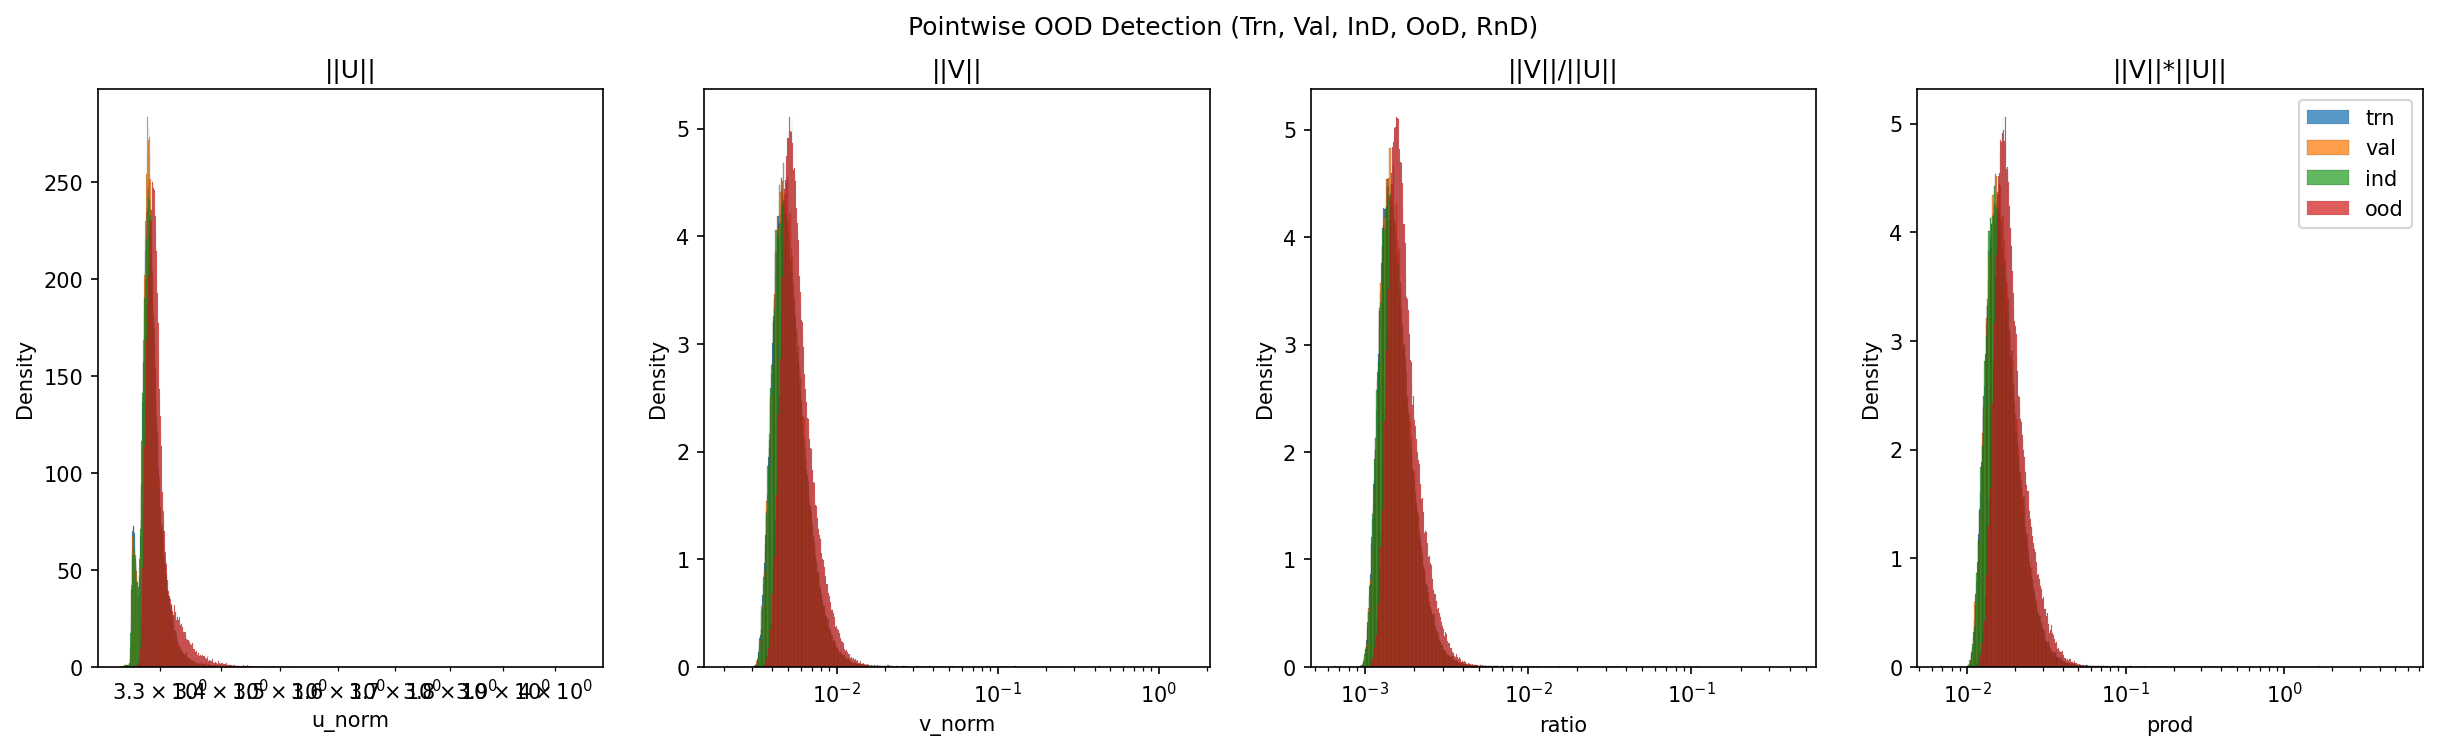

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0020922413 0.2478971 0.24580486
Val 0.003058891 0.43021095 0.42715207
Ind 0.0020922413 0.12947838 0.12738614
Ood 0.0020922413 1.4936885 1.4915962
Rnd 10.476584 13.162698 2.6861134
KstestResult(statistic=0.2271732480214335, pvalue=0.0, statistic_location=0.004703017, statistic_sign=1)


[0 1 2 3 4]


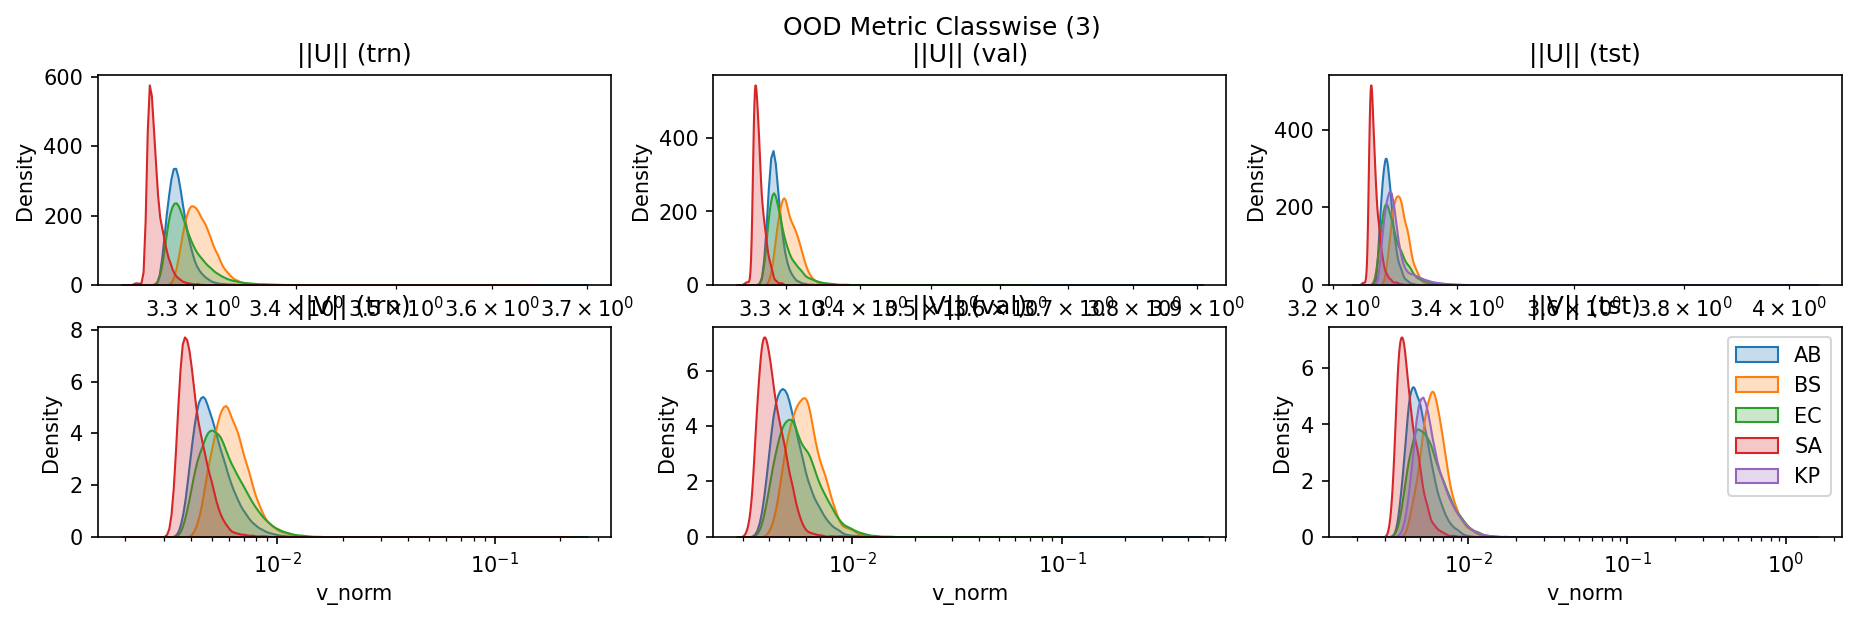

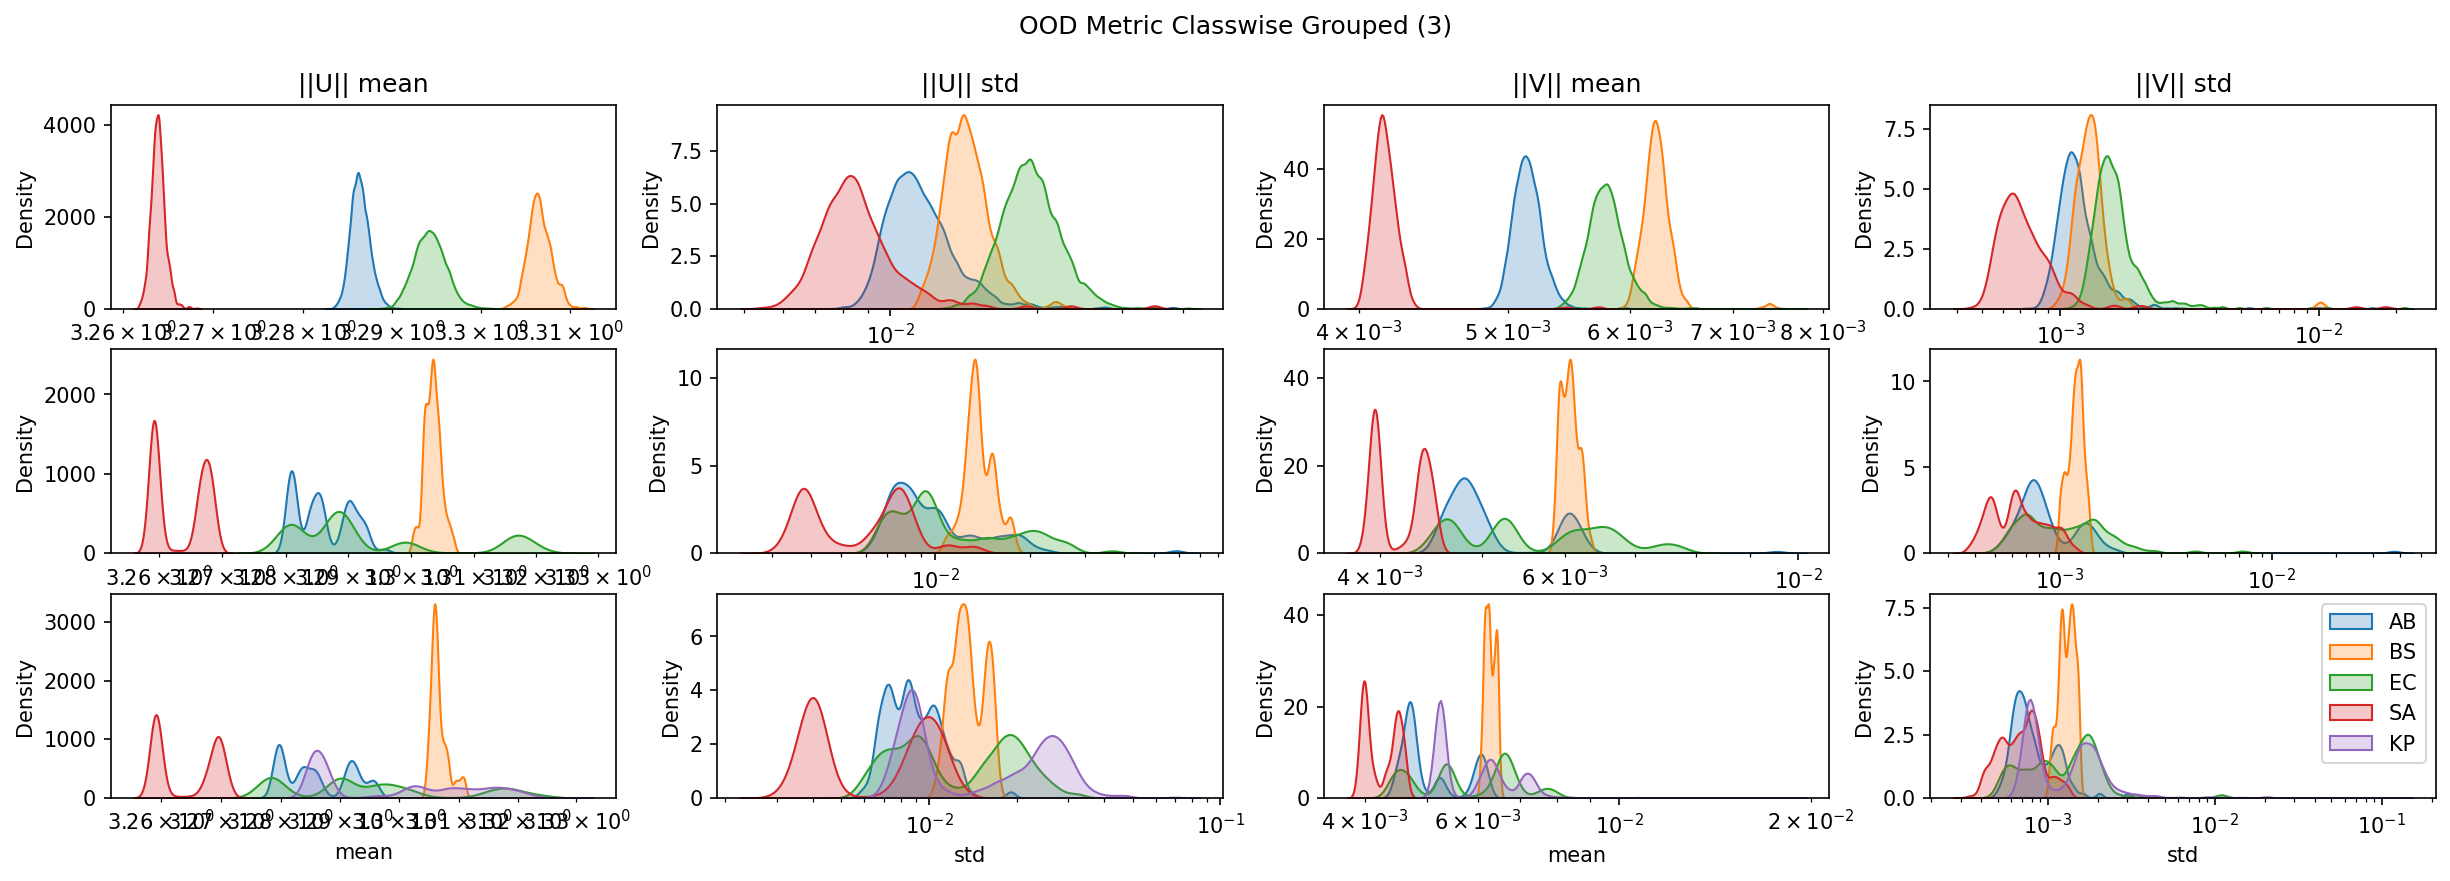

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)